In [1]:
library(Seurat)
library(hdf5r)
library(dplyr)
library(uwot)
library(ggplot2)
library(SoupX)

Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: Matrix



In [2]:
var1 = "DFCI_2100020_T1"

In [3]:
library(reticulate)
use_python("/broad/software/free/Linux/redhat_6_x86_64/pkgs/python_3.6.3-dupe/lib/python3.6")
use_virtualenv("/broad/VanAllenLab/xchip/cga_home/sjohri/myenv/")

## SoupX

For removal of ambient RNA contamination from samples. Package details: https://github.com/constantAmateur/SoupX. Detailed Vignette explaining logic behind how the package works: https://rawcdn.githack.com/constantAmateur/SoupX/6be48cdb0950ed145a3ca6cf235ec2c24d626f81/inst/doc/pbmcTutorial.html.

In [4]:
#Reading unfiltered cell ranger outputs in variable 'tod', and filtered cell ranger outputs in variable 'toc'
toc = Read10X_h5(paste(paste("/home/unix/sjohri/valab_sjohri/projects/ex-vivo/data/",var1, sep=""),
                               "_filtered_feature_bc_matrix.h5", sep=""), 
                   use.names=TRUE, unique.features=TRUE)
tod = Read10X_h5(paste(paste("/home/unix/sjohri/valab_sjohri/projects/ex-vivo/data/",var1, sep=""),
                               "_raw_feature_bc_matrix.h5", sep=""), 
                   use.names=TRUE, unique.features=TRUE)

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Centering and scaling data matrix



PC_ 1 
Positive:  CLDN5, EGFL7, AQP1, SPRY1, CAVIN2, VWF, CLEC14A, EMCN, IFI27, ADGRL4 
	   FLT1, ACKR1, GNG11, CD74, HYAL2, ECSCR, HLA-E, HLA-DRB1, RAMP2, CD93 
	   LIFR, RAMP3, PCAT19, PLVAP, NOSTRIN, RNASE1, PDLIM1, HLA-DRA, GIMAP7, MMRN2 
Negative:  LGALS1, IGFBP5, DCN, RARRES2, S100A4, IGFBP6, COL6A2, SOD3, COL1A2, TAGLN 
	   LUM, TPM2, C1S, COL14A1, SSPN, CEBPB, ABCA8, C2orf40, LTBP4, PDGFRB 
	   LRP1, ACTA2, C1R, COL6A1, NR2F1, FBLN1, SERPINF1, COL1A1, LGI4, DKK3 
PC_ 2 
Positive:  IGFBP7, SPARCL1, CALD1, TIMP3, GSN, ADIRF, MGP, VIM, DSTN, TSC22D1 
	   TPM2, TAGLN, TPM1, SOD3, SPARC, MYL9, MFGE8, COL6A2, IGFBP5, ACTA2 
	   PLAC9, CAV1, CPE, COL6A1, PDGFRB, NR2F2, C11orf96, IGFBP6, COL14A1, COL1A2 
Negative:  HCST, PTPRC, CXCR4, RGS1, CD69, LCP1, LAPTM5, CYTIP, CD48, CD37 
	   CD52, CCL5, ITGB2, CD3D, CYBA, CD53, SAMSN1, CCL4, CORO1A, TYROBP 
	   CD2, TRBC2, ALOX5AP, IL7R, CD3E, FYB1, SLA, DUSP2, FCER1G, GZMA 
PC_ 3 
Positive:  LUM, CDH19, ABCA8, SCN7A, APOD, DCN, LTBP4, ANGPTL7,

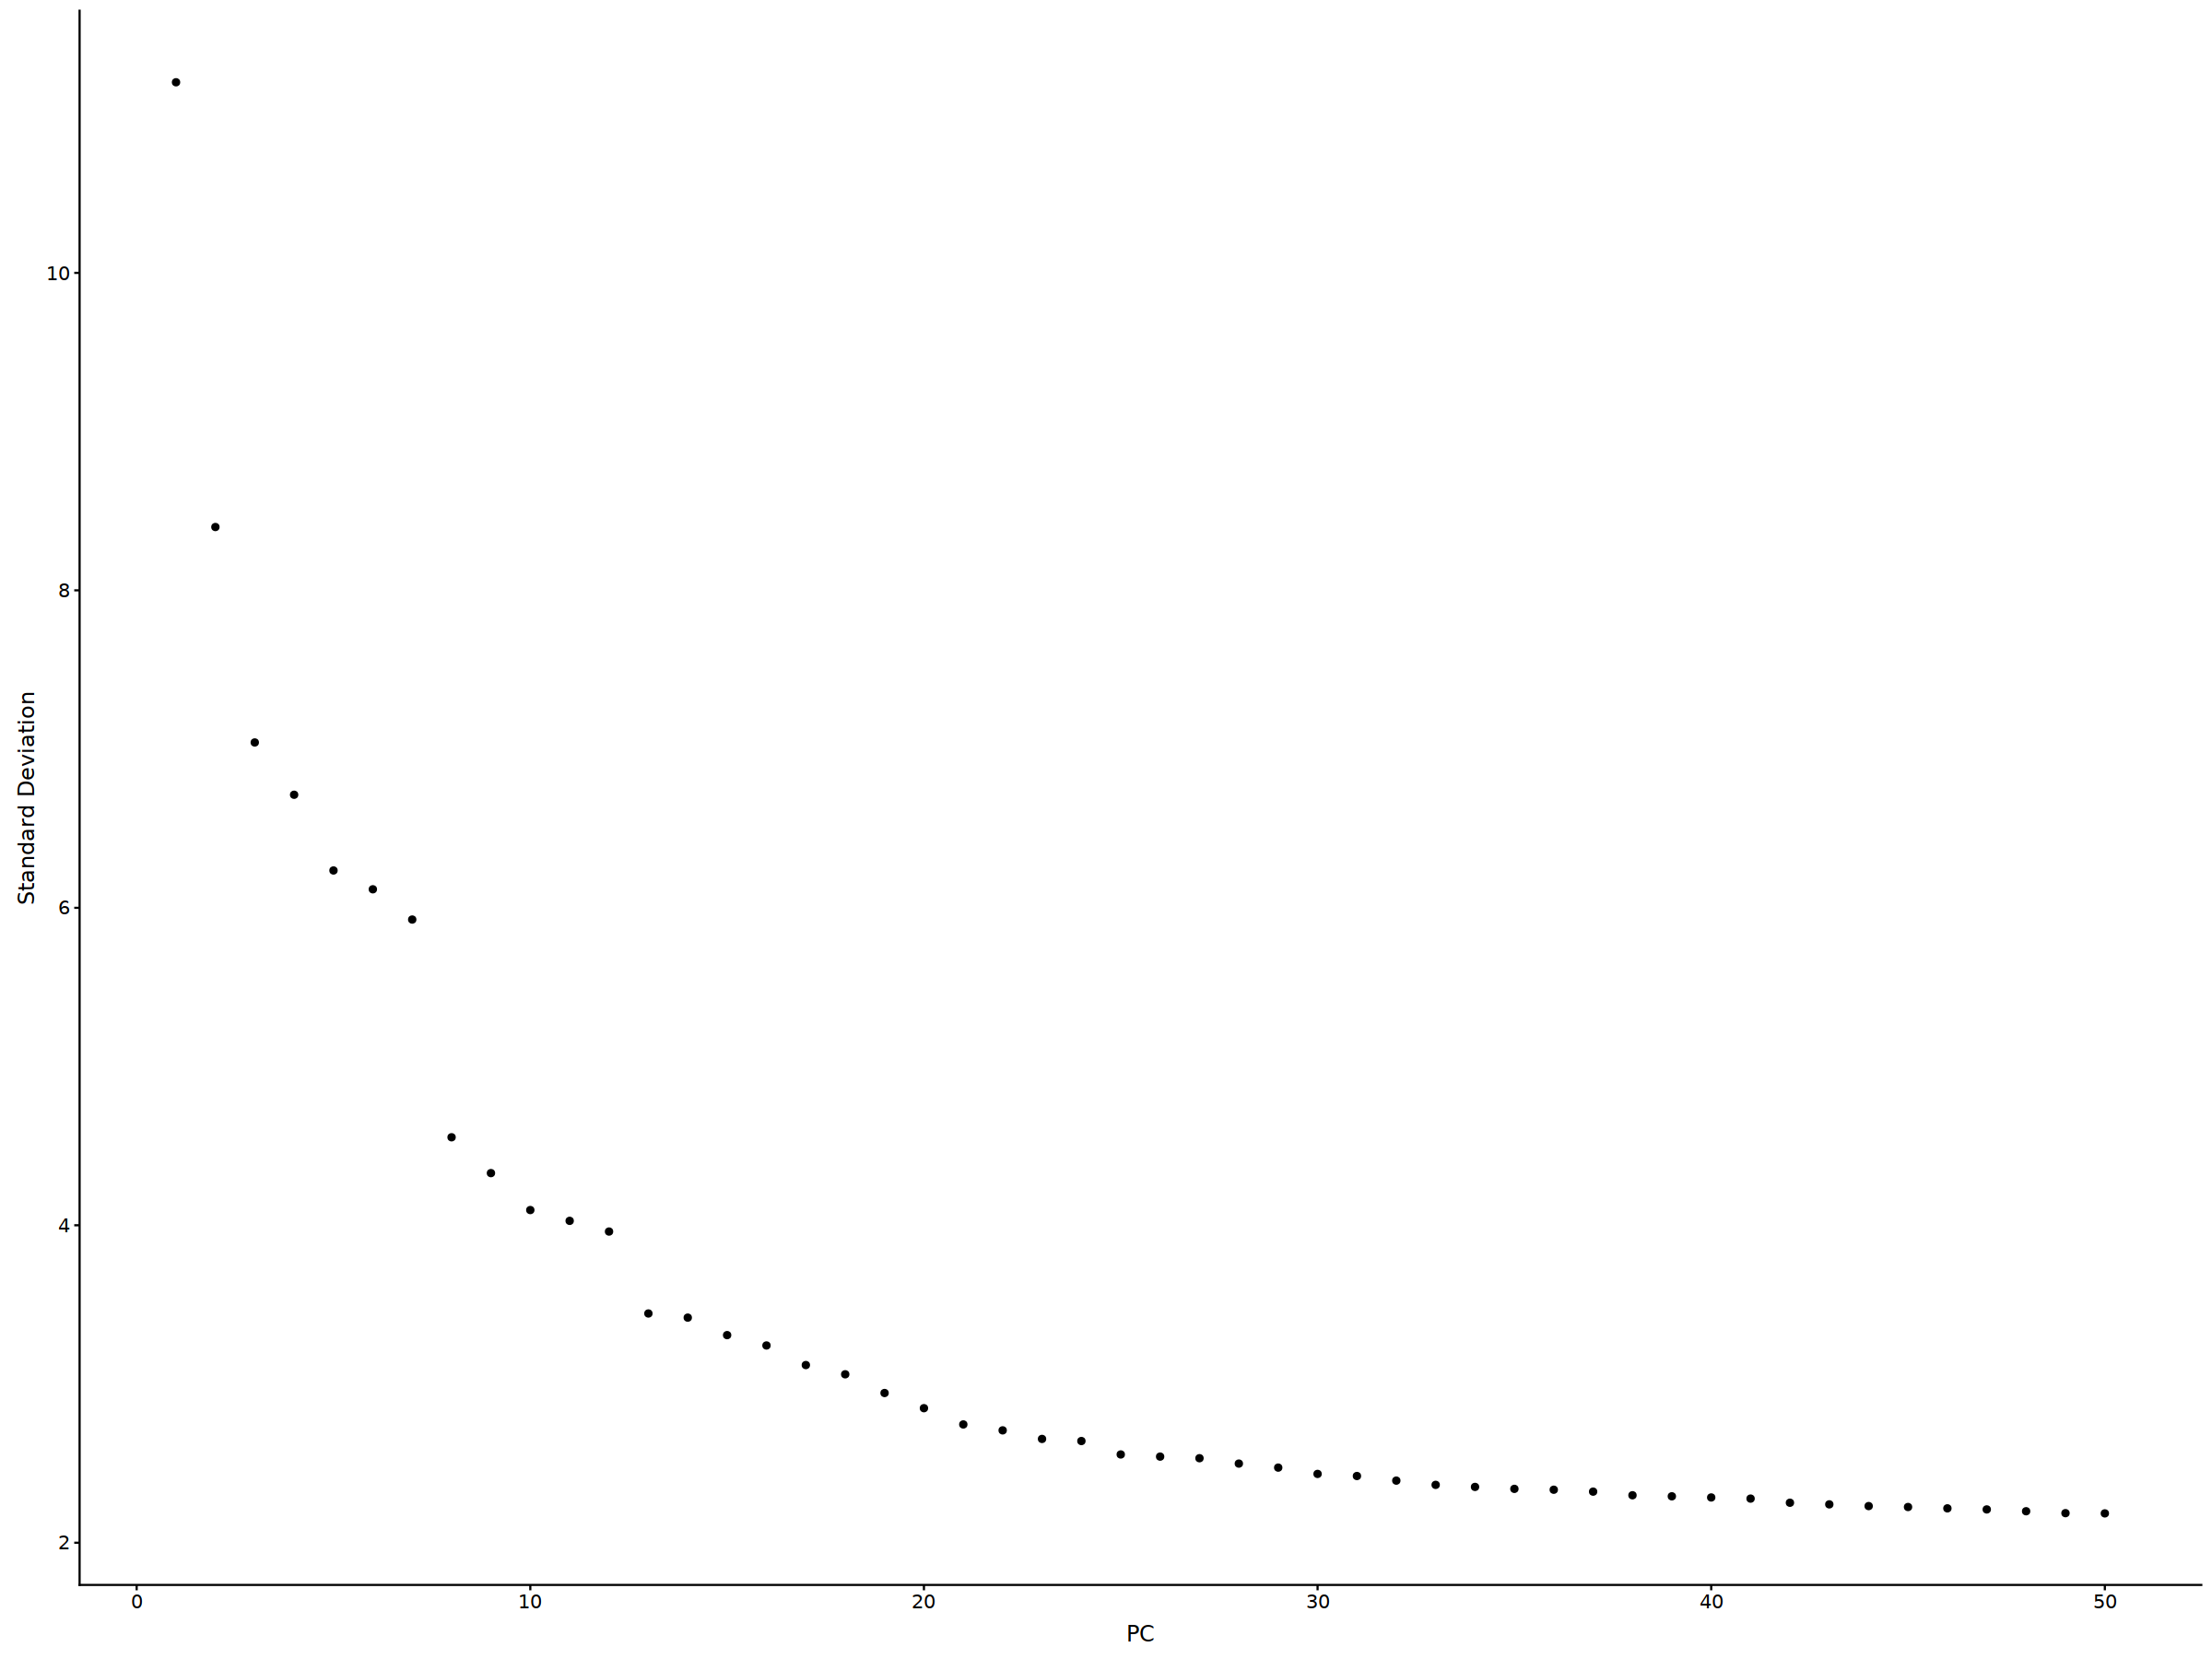

In [9]:
#Want to provide rough clustering information to SoupX for better estimation, so here using Seurat to cluster but skipping the QC steps.
#Note: filtered object's (toc) clustering information is needed not for tod
toc_obj = CreateSeuratObject(counts = toc)
toc_obj <- NormalizeData(toc_obj, normalization.method = "LogNormalize", scale.factor = 10000)
toc_obj <- FindVariableFeatures(toc_obj, selection.method = "vst", nfeatures = 5000)
toc_obj <- ScaleData(toc_obj, features = rownames(toc_obj))
toc_obj <- RunPCA(toc_obj, features = VariableFeatures(object = toc_obj))
ElbowPlot(toc_obj, ndims = 50, reduction = "pca")

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2170
Number of edges: 66324

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8825
Number of communities: 14
Elapsed time: 0 seconds


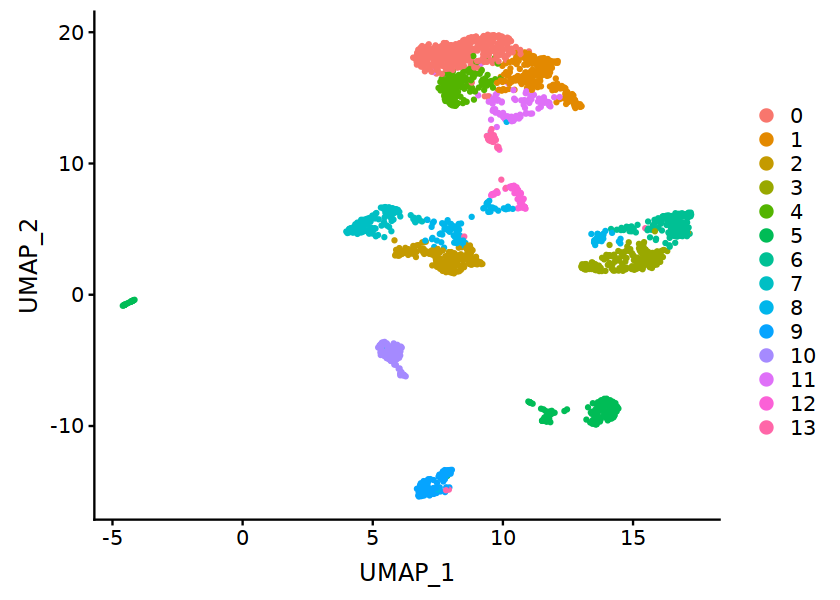

In [10]:
#Continued clustering of toc
options(repr.plot.width=7, repr.plot.height=5, cex=5)
toc_obj <- FindNeighbors(toc_obj, dims = 1:30)
toc_obj <- FindClusters(toc_obj, resolution = 0.7)
toc_obj <- RunUMAP(toc_obj, dims = 1:30)
toc_obj <- RunTSNE(toc_obj, dims = 1:30)
DimPlot(toc_obj, reduction="umap")

In [20]:
# Manual Method: 
# igGenes <- c("IGHA1", "IGHA2", "IGHG1", "IGHG2", "IGHG3", "IGHG4", "IGHD", "IGHE", "IGHM",
#              "IGLC1", "IGLC2", "IGLC3", "IGLC4", "IGLC5", "IGLC6", "IGLC7", "IGKC")
# hgGenes <- c("HBA1", "HBA2", "HBB", "HBD", "HBE1", "HBG1", "HBG2", "HBM", "HBQ1", "HBZ")
wbcGenes <- c("PTPRC")
macGenes <- c("APOE","APOC1","C1QA","C1QB","C1QC")
# macGenes <- c("C1QA","C1QB","C1QC")
epiGenes <- c("KRT8","KRT18","EPCAM")
endoGenes <- c("ECSCR","CDH5")
# fbGenes <- c("LUM","FBLN1")

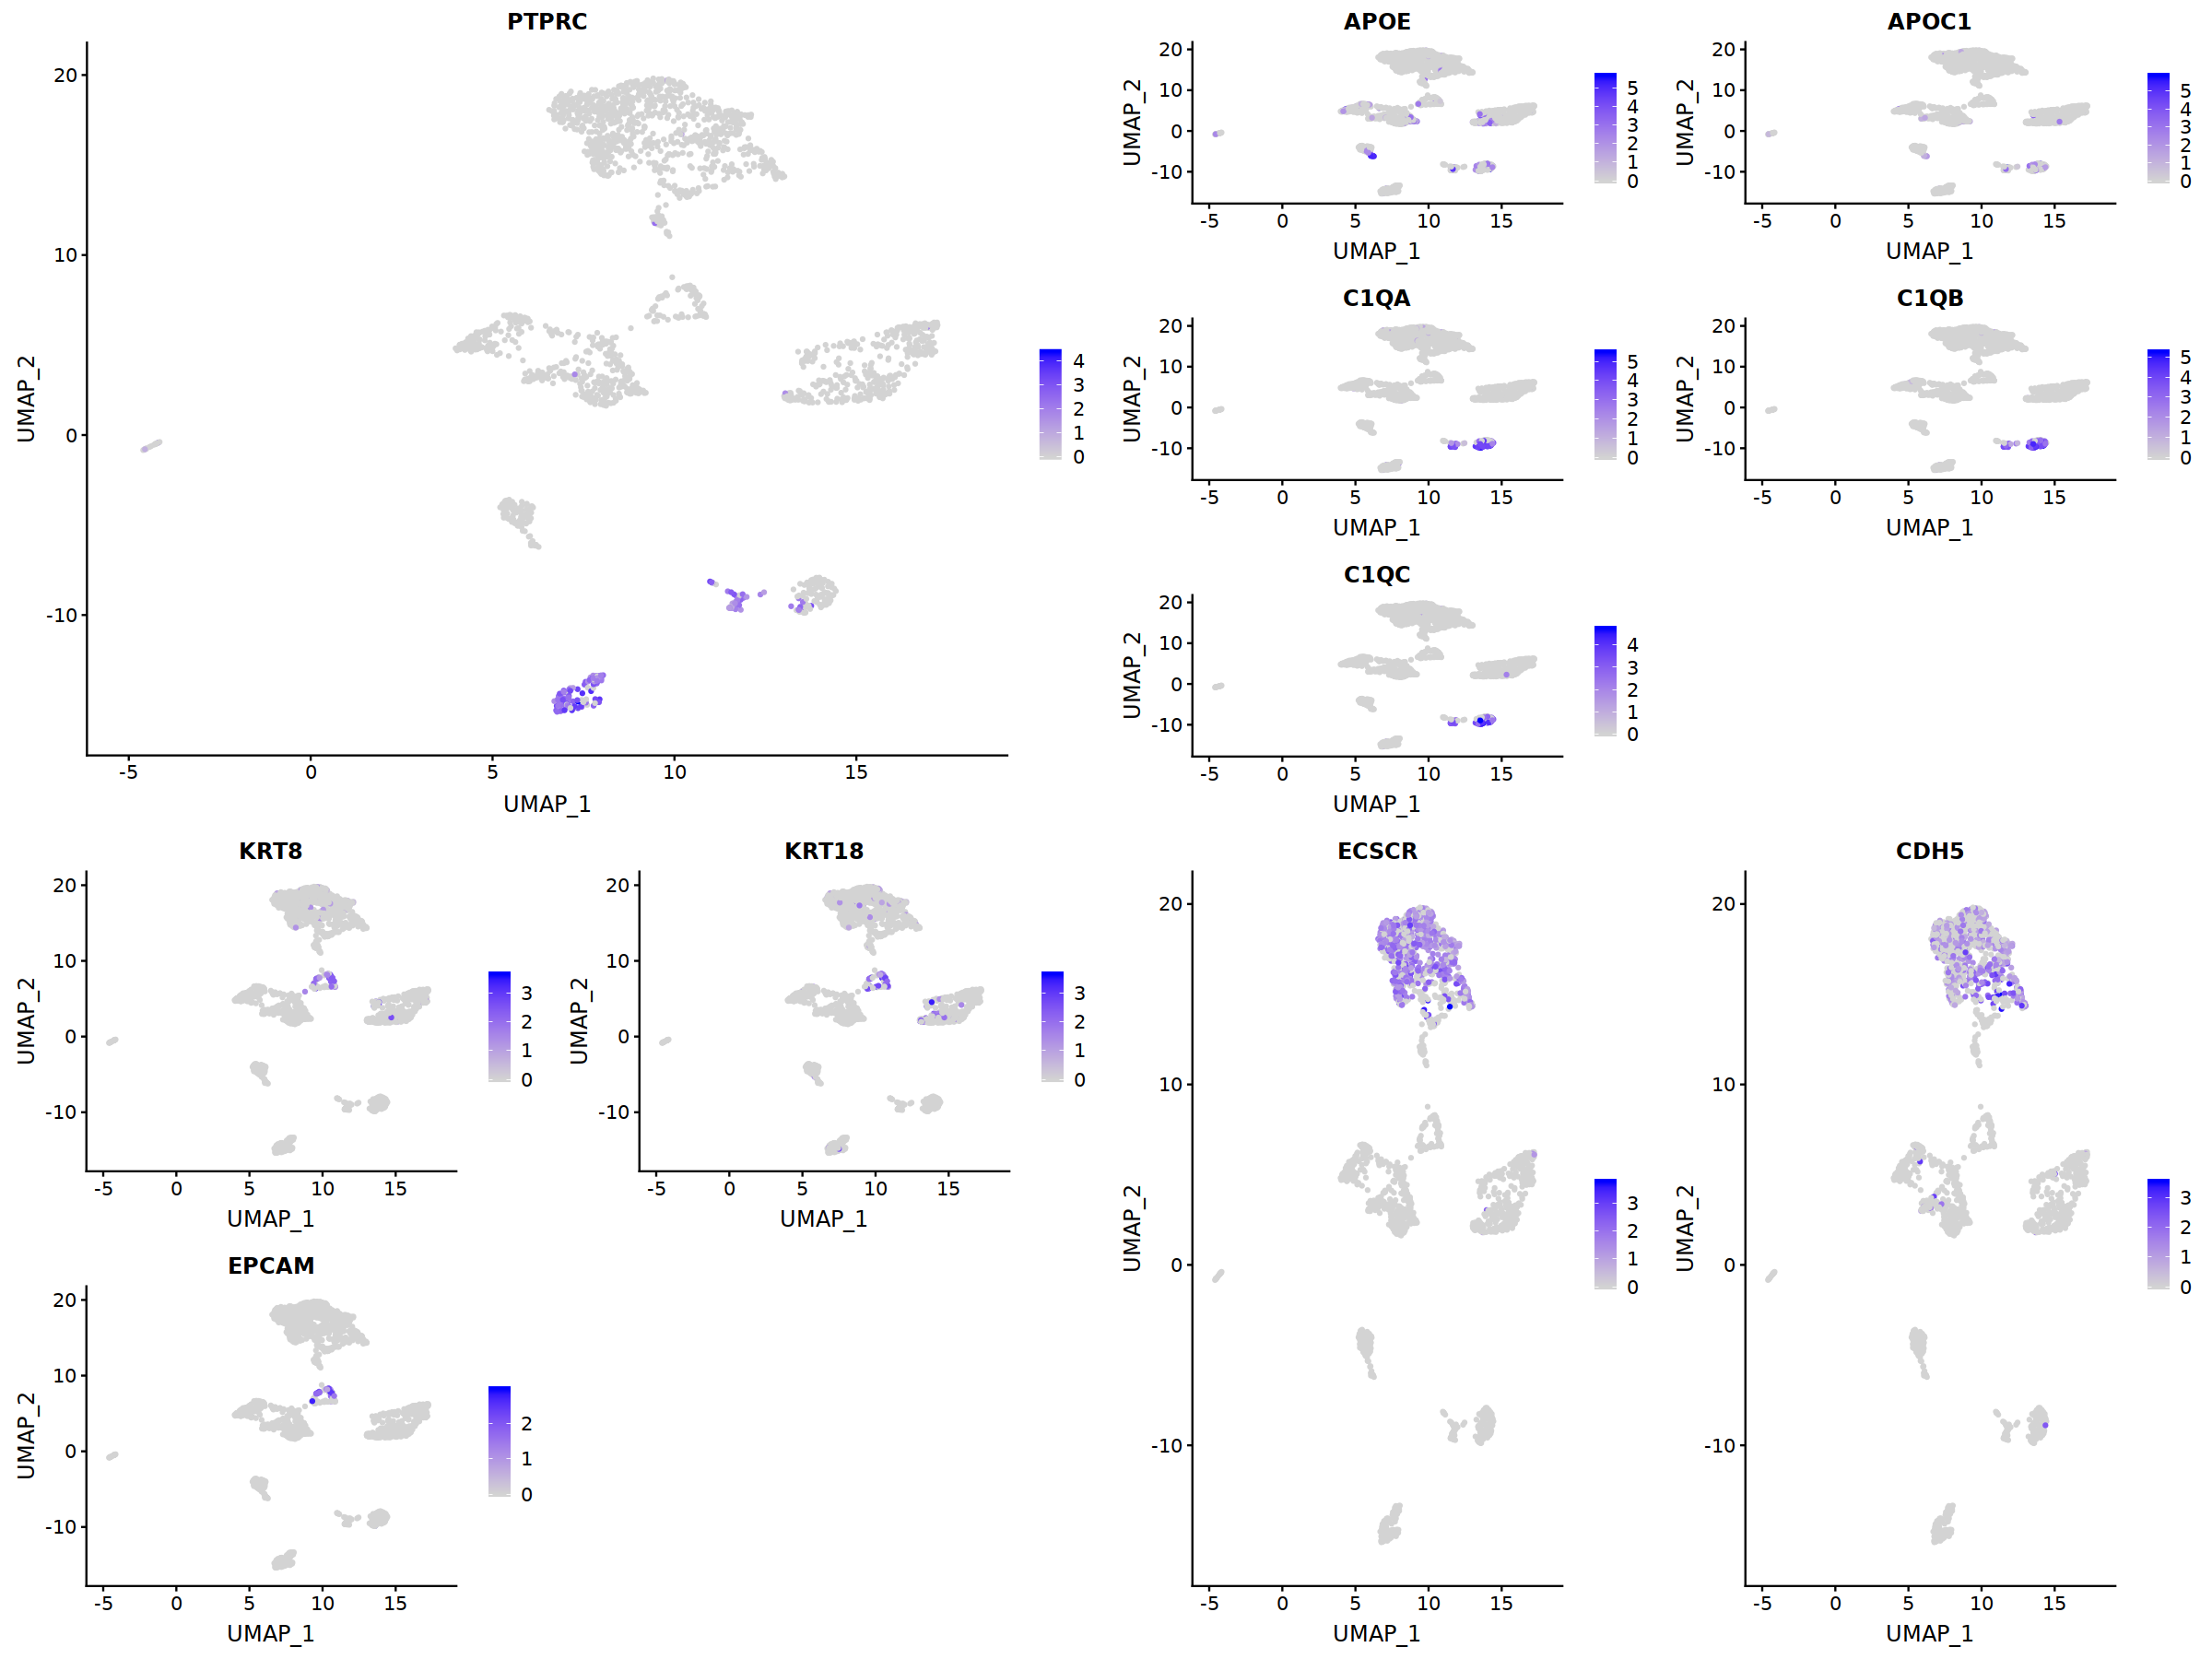

In [21]:
options(repr.plot.width=20, repr.plot.height=15, cex=5)
p1 <- FeaturePlot(toc_obj, features=wbcGenes)
p2 <- FeaturePlot(toc_obj, features=macGenes)
p3 <- FeaturePlot(toc_obj, features=epiGenes)
p4 <- FeaturePlot(toc_obj, features=endoGenes)
gridExtra::grid.arrange(p1,p2,p3,p4, nrow=2)

In [22]:
sc = SoupChannel(tod, toc)
sc

Channel with 60627 genes and 2170 cells



In [23]:
#checking the topmost genes in order of contamination that was detected. ideally should be MT- or RP genes as in this case
sc = setClusters(sc, setNames(toc_obj@meta.data$seurat_clusters, rownames(toc_obj@meta.data)))
head(sc$soupProfile[order(sc$soupProfile$est, decreasing = TRUE), ], n = 20)

est         counts
MT-RNR2 0.175553395 424644
MT-ND3  0.064134842 155135
MT-CO3  0.054379946 131539
MT-ATP6 0.051542279 124675
MT-RNR1 0.042438509 102654
MT-CYB  0.038172499  92335
MT-CO2  0.035875576  86779
MT-ND4  0.032665010  79013
MT-CO1  0.027442775  66381
MT-ND1  0.021304831  51534
MT-ND2  0.016966474  41040
MALAT1  0.015252050  36893
MT-ND5  0.006938312  16783
MT-ND4L 0.003854250   9323
RPL41   0.003393708   8209
RPLP1   0.003354434   8114
EEF1A1  0.003163024   7651
B2M     0.003135325   7584
RPL13   0.002958384   7156
RPS18   0.002951356   7139

In [24]:
useToEst = estimateNonExpressingCells(sc, nonExpressedGeneList = 
                                      list(WB=wbcGenes, MC=macGenes, EP=epiGenes, ED=endoGenes))

In [25]:
sc = calculateContaminationFraction(sc, list(WB=wbcGenes, MC=macGenes, EP=epiGenes, ED=endoGenes), 
                                    useToEst = useToEst)

Estimated global contamination fraction of 9.55%



In [26]:
# data = adjustCounts(sc, roundToInt=TRUE)
data = adjustCounts(sc)

Expanding counts from 14 clusters to 2170 cells.



## Scrublet

To remove doublets cells from our data. Code here: https://github.com/AllonKleinLab/scrublet. Paper here: https://www.cell.com/cell-systems/pdfExtended/S2405-4712(18)30474-5.

In [27]:
#Scipy is a python package. But just to make the code easier to run in one go, 
#I am calling python from R using package reticulate which provides the required interface.
colnames(data) = substr(colnames(data), 1, 16)
scipy_data <- RGF::TO_scipy_sparse(t(data))

In [28]:
nrow(data)
ncol(data)
scipy_data$shape[0]
scipy_data$shape[1]
var2 = ncol(data)

[1] 60627

[1] 2170

2170

60627

In [29]:
#syntax is different slightly for calling Python from R. 
scr <- import("scrublet")
scrub = scr$Scrublet(scipy_data, expected_doublet_rate=0.1)
x=scrub$scrub_doublets(min_counts=2, 
                      min_cells=3, 
                      min_gene_variability_pctl=85, 
                      n_prin_comps=as.integer(30))

In [30]:
scrub$expected_doublet_rate
scrub$detected_doublet_rate_

[1] 0.1

[1] 0.005990783

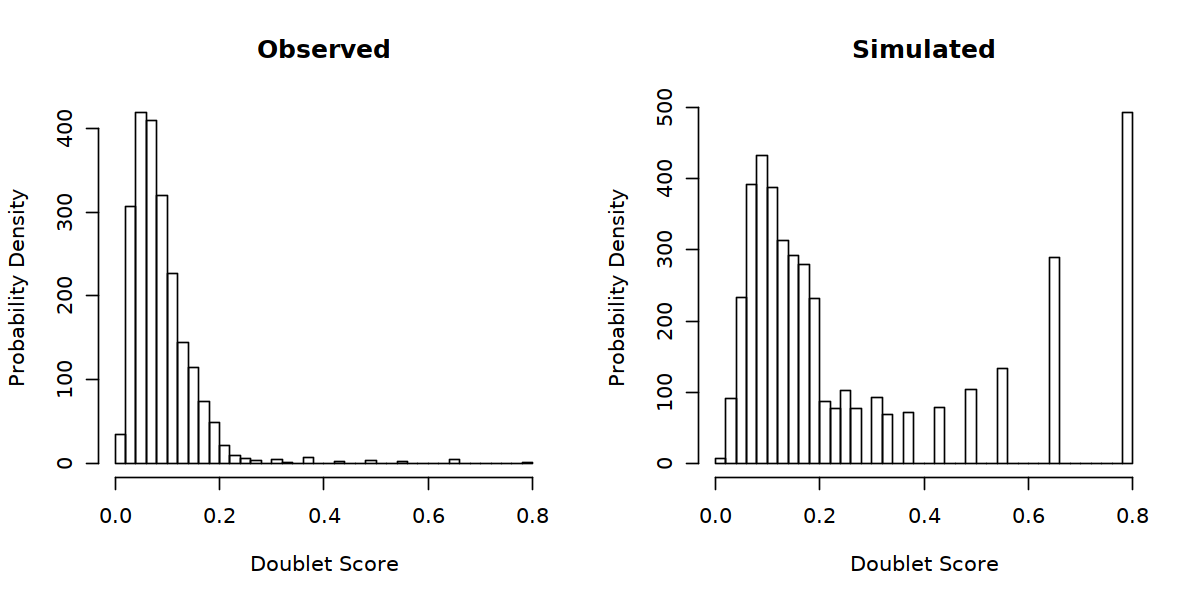

In [31]:
# We want to disregard the right half of the bimodal distribution
# scrub$plot_histogram()[[1]]
options(repr.plot.width=10, repr.plot.height=5, cex=5)
par(mfrow = c(1, 2))
hist(scrub$doublet_scores_obs_, breaks=30, ylab="Probability Density", xlab="Doublet Score", main="Observed")
hist(scrub$doublet_scores_sim_, breaks=30, ylab="Probability Density", xlab="Doublet Score", main="Simulated")
par(mfrow = c(1, 1))

In [33]:
#manually setting the cutoff because its more accurate by eye
cutoff=0.3
var3 = cutoff

In [34]:
umap_coord = as.data.frame(umap(scrub$manifold_obs_, ))
colnames(umap_coord) = c("x_coord","y_coord")
umap_coord[["score"]] = scrub$doublet_scores_obs_

In [35]:
highlight=umap_coord[scrub$call_doublets(threshold=cutoff),]

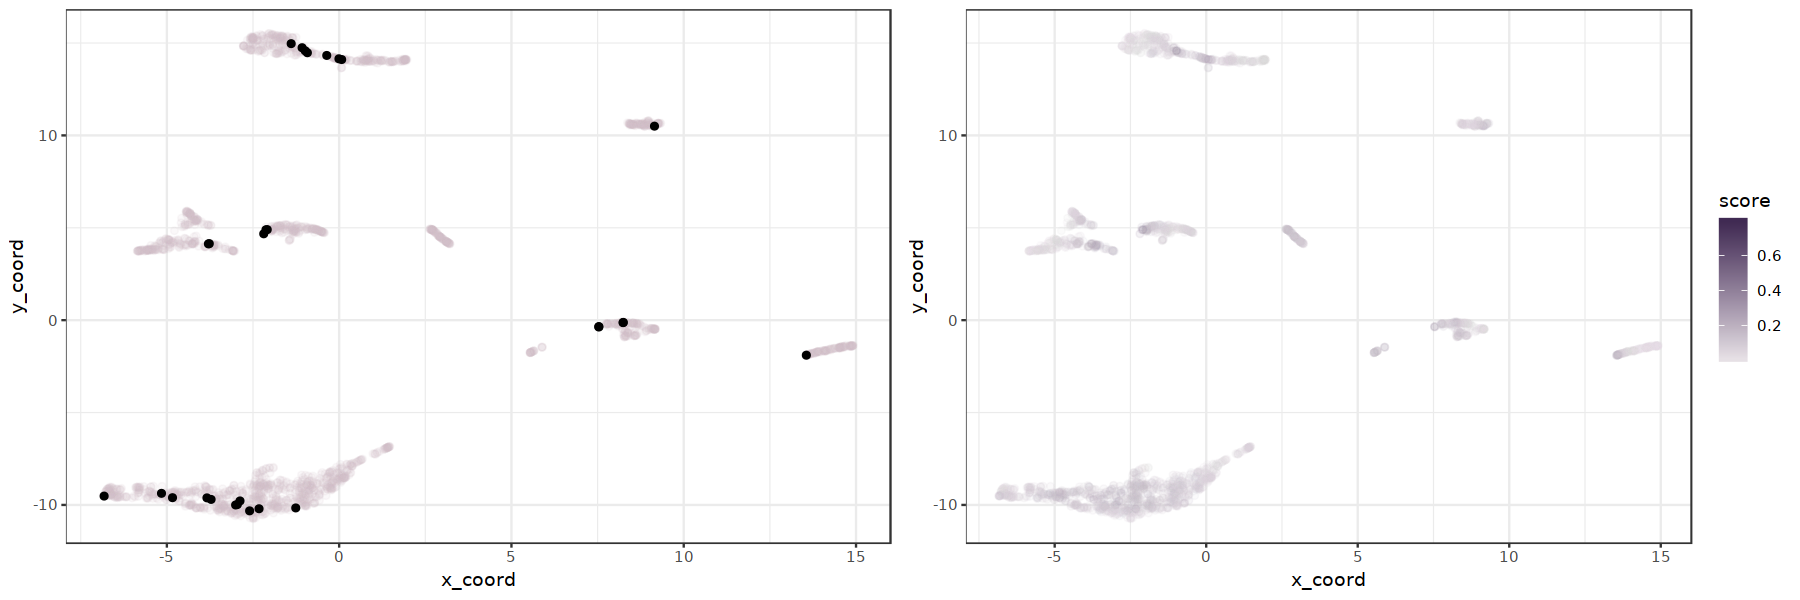

In [36]:
#visualising where doublets lie. ideally should be randomly distributed
options(repr.plot.width=15, repr.plot.height=5, cex=5)
p1 <- ggplot(umap_coord, aes(x=x_coord,y=y_coord))+ geom_point(color="#D0C3C4", alpha=0.1)+geom_point(data=highlight, color="black")+theme_bw()
p2 <- ggplot(umap_coord, aes(x=x_coord,y=y_coord, color=score))+ geom_point(alpha=0.1)+scale_color_gradient(low="#E6E0E5", high="#402A53")+theme_bw()
gridExtra::grid.arrange(p1,p2, nrow=1)

In [37]:
scrub$detected_doublet_rate_

[1] 0.01336406

In [38]:
doublet_free_data = data[,which(scrub$doublet_scores_obs_<cutoff)]
dim(doublet_free_data)
var4 = ncol(doublet_free_data)

[1] 60627  2141

## Seurat

In [39]:
# Initialize the Seurat object with the doublet free, ambient RNA free, data.
sobj <- CreateSeuratObject(counts = doublet_free_data, project = var1, min.cells = 3, min.features = 200)
sobj

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


An object of class Seurat 
18447 features across 2113 samples within 1 assay 
Active assay: RNA (18447 features)

In [40]:
sobj[["percent.mt"]] <- PercentageFeatureSet(sobj, pattern = "^MT-")

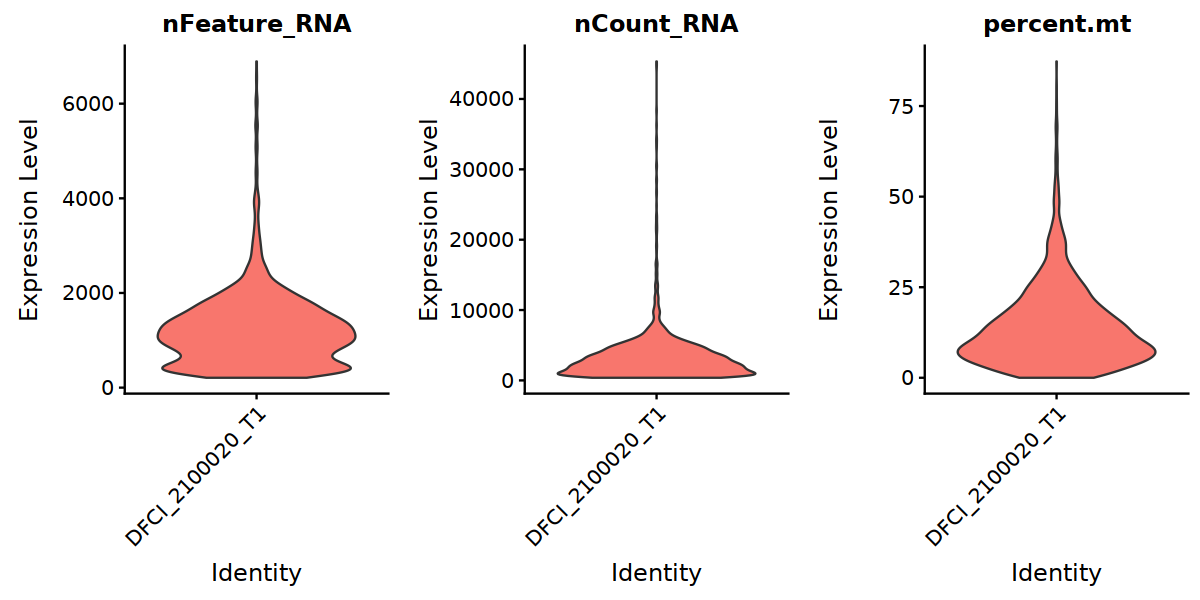

In [41]:
options(repr.plot.width=10, repr.plot.height=5, cex=5)
# Visualize QC metrics as a violin plot
VlnPlot(sobj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), pt.size=0)

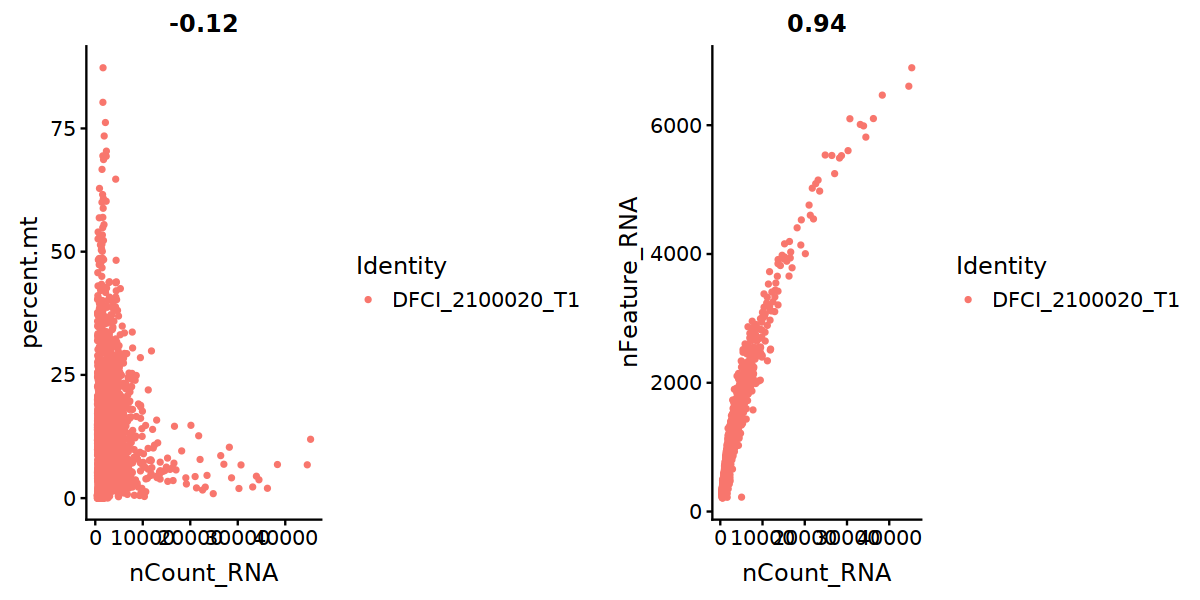

In [42]:
options(repr.plot.width=10, repr.plot.height=5, cex=5)
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.
plot1 <- FeatureScatter(sobj, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(sobj, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
gridExtra::grid.arrange(plot1,plot2, nrow=1)

In [43]:
#Based on above plots, setting the QC metrics here
sobj <- subset(sobj, subset = nFeature_RNA > 200 & percent.mt < 50)
sobj

An object of class Seurat 
18447 features across 2082 samples within 1 assay 
Active assay: RNA (18447 features)

In [44]:
var5 = ncol(sobj)

In [45]:
#Normalising the Data
sobj <- NormalizeData(sobj, normalization.method = "LogNormalize", scale.factor = 10000)

Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."


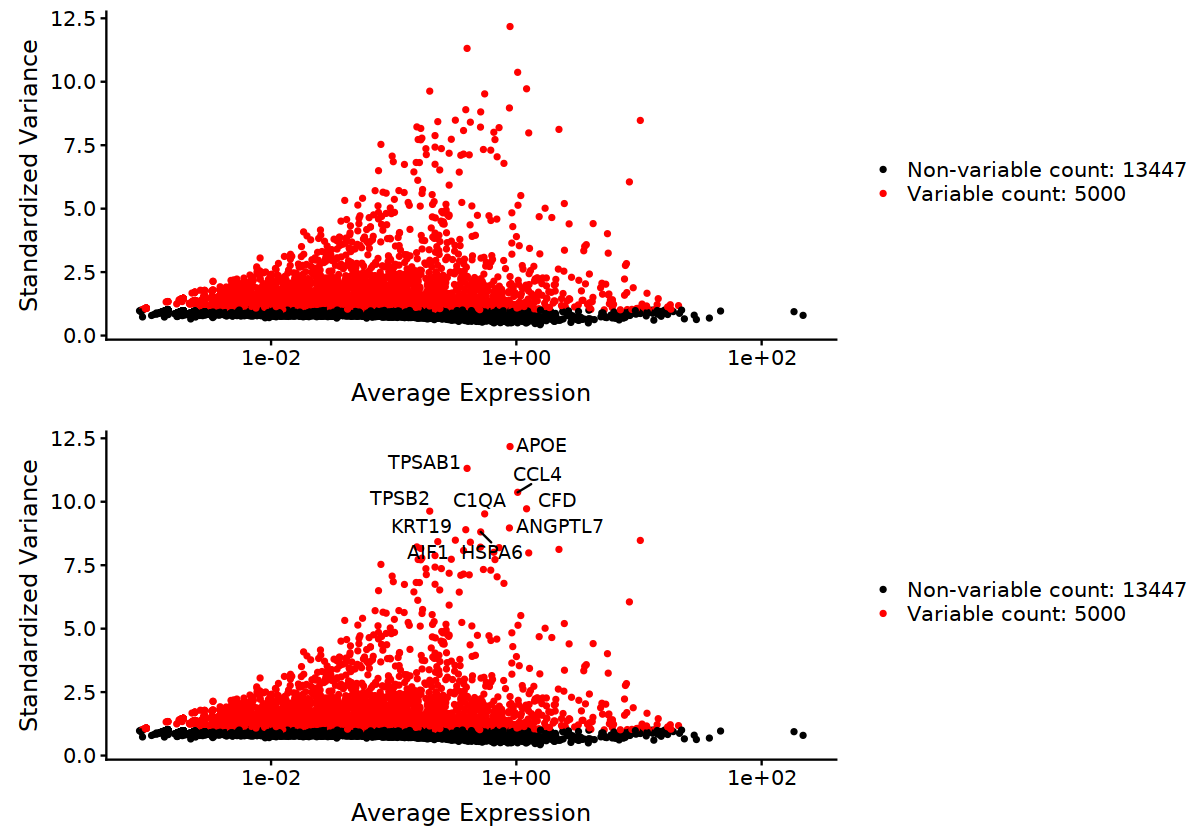

In [46]:
options(repr.plot.width=10, repr.plot.height=7, cex=5)
#Identification of highly variable features (feature selection)
sobj <- FindVariableFeatures(sobj, selection.method = "vst", nfeatures = 5000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(sobj), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(sobj)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE, xnudge=0, ynudge=0)
gridExtra::grid.arrange(plot1,plot2)

In [47]:
var_features = sobj@assays$RNA@var.features
var6 = var_features[grep("^MT", var_features)]

In [48]:
#Scaling the data
all.genes <- rownames(sobj)
sobj <- ScaleData(sobj, features = all.genes)

Centering and scaling data matrix



In [49]:
#Perform linear dimensionality reduction with top variable features
sobj <- RunPCA(sobj, features = VariableFeatures(object = sobj))

PC_ 1 
Positive:  LGALS1, IGFBP6, IGFBP5, S100A4, DCN, RARRES2, COL6A2, TAGLN, SOD3, TPM2 
	   COL1A2, CEBPB, C1S, LUM, COL14A1, SSPN, C2orf40, LTBP4, C1R, ACTA2 
	   PDGFRB, COL6A1, NR2F1, MYL9, ABCA8, LRP1, FBLN1, APOD, SERPINF1, FTH1 
Negative:  CLDN5, EGFL7, AQP1, SPRY1, CAVIN2, VWF, CLEC14A, EMCN, IFI27, ADGRL4 
	   FLT1, CD74, ACKR1, GNG11, HLA-DRB1, HYAL2, HLA-E, LIFR, ECSCR, CD93 
	   RAMP2, RAMP3, PLVAP, PCAT19, RNASE1, NOSTRIN, HLA-DRA, PDLIM1, GIMAP7, MMRN2 
PC_ 2 
Positive:  IGFBP7, SPARCL1, CALD1, TIMP3, GSN, ADIRF, VIM, DSTN, MGP, TSC22D1 
	   TAGLN, TPM2, TPM1, SOD3, SPARC, MYL9, CAV1, PLAC9, IGFBP5, MFGE8 
	   ACTA2, COL6A2, CPE, C11orf96, NR2F2, COL6A1, PDGFRB, IGFBP6, MT2A, COL14A1 
Negative:  HCST, PTPRC, CXCR4, RGS1, LAPTM5, CD69, LCP1, CD37, CD48, CYTIP 
	   CD52, ITGB2, CCL5, CYBA, CD53, SAMSN1, CD3D, TYROBP, CORO1A, CCL4 
	   ALOX5AP, FYB1, CD2, SLA, TRBC2, IL7R, DUSP2, FCER1G, CD3E, AIF1 
PC_ 3 
Positive:  CDH19, ABCA8, SCN7A, LUM, PLP1, DCN, S100B, NRXN1, APOD,

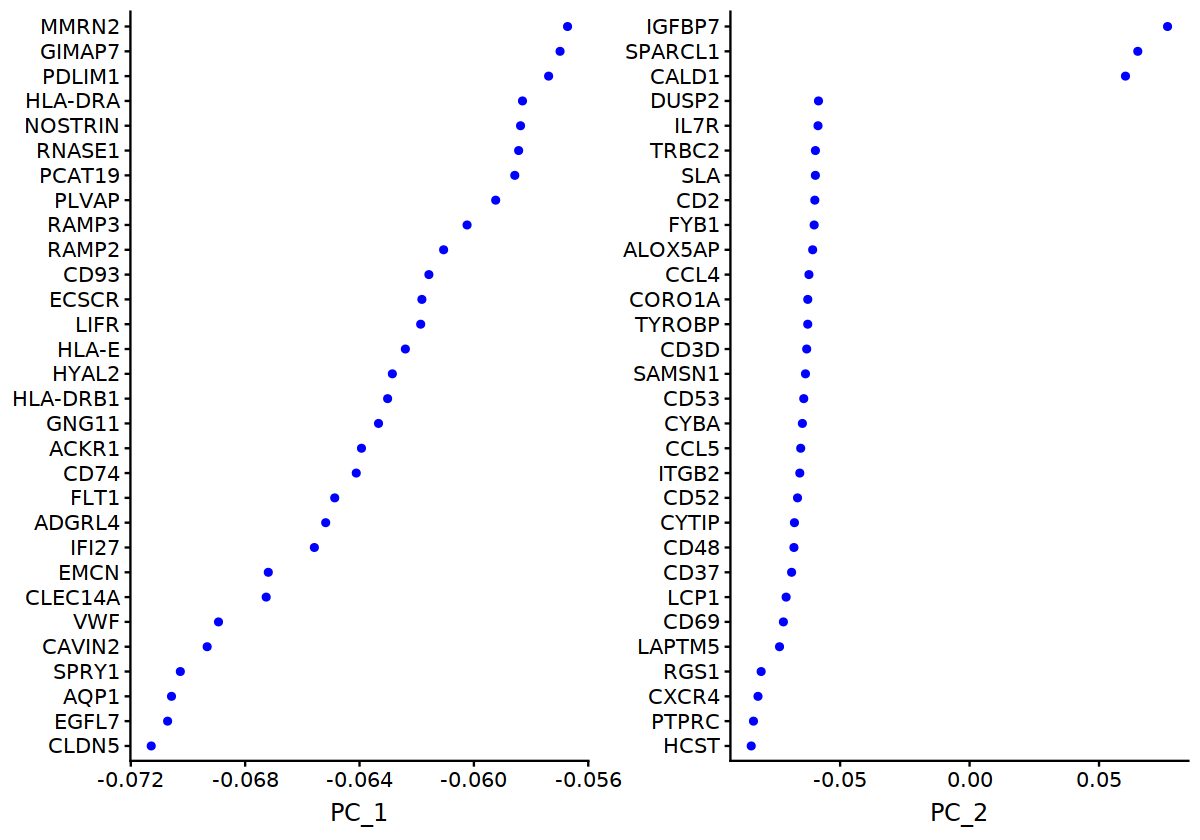

In [50]:
VizDimLoadings(sobj, dims = 1:2, reduction = "pca")

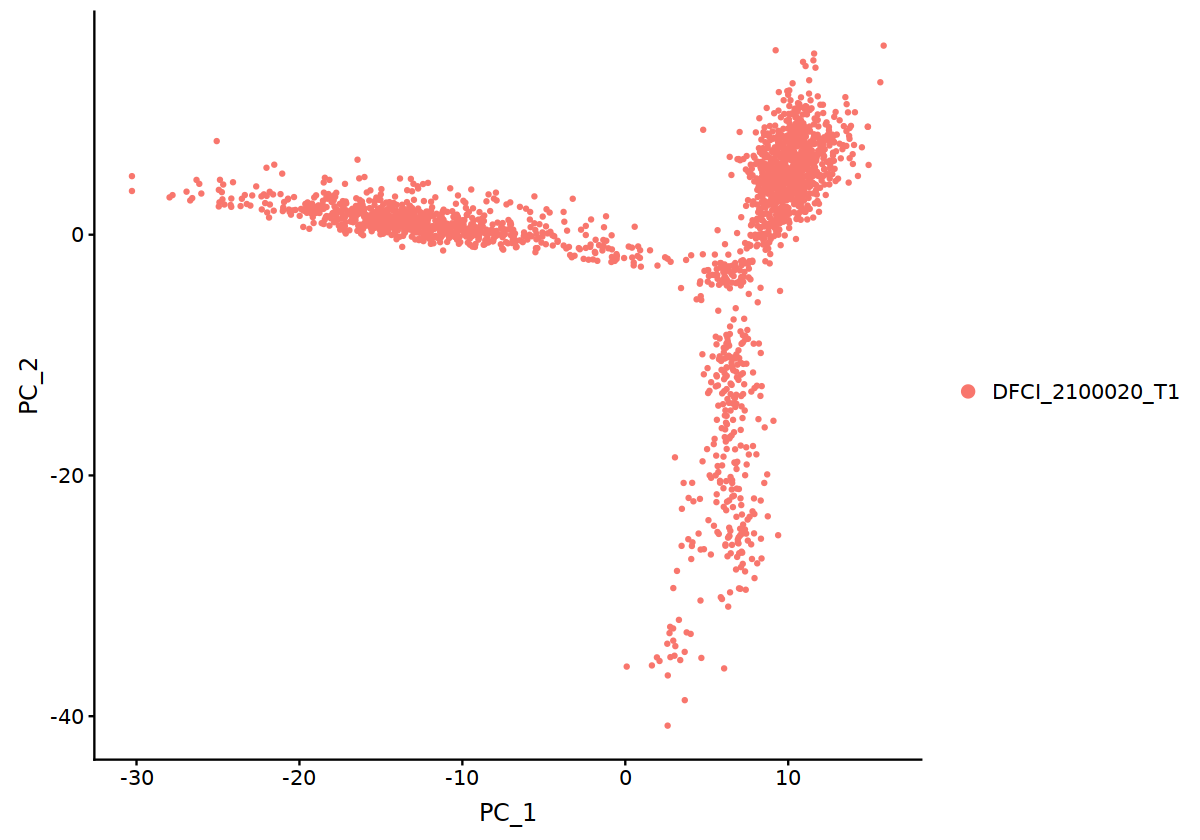

In [51]:
DimPlot(sobj, reduction = "pca")

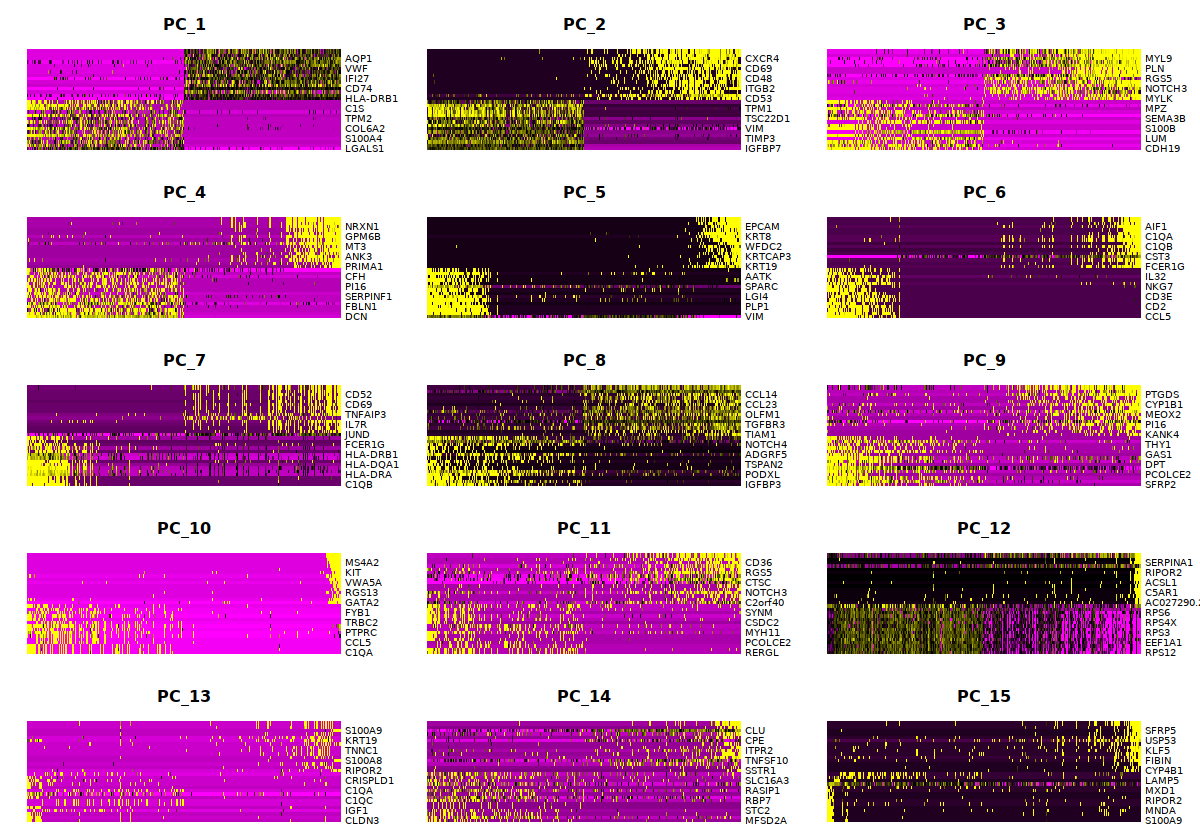

In [52]:
DimHeatmap(sobj, dims = 1:15, cells = 500, balanced = TRUE)

In [53]:
# #Determining the dimensionality of the dataset
# p1 <- JackStraw(p1, num.replicate = 100)
# p1 <- ScoreJackStraw(p1, dims = 1:20)

In [54]:
# JackStrawPlot(p1, dims = 1:20)

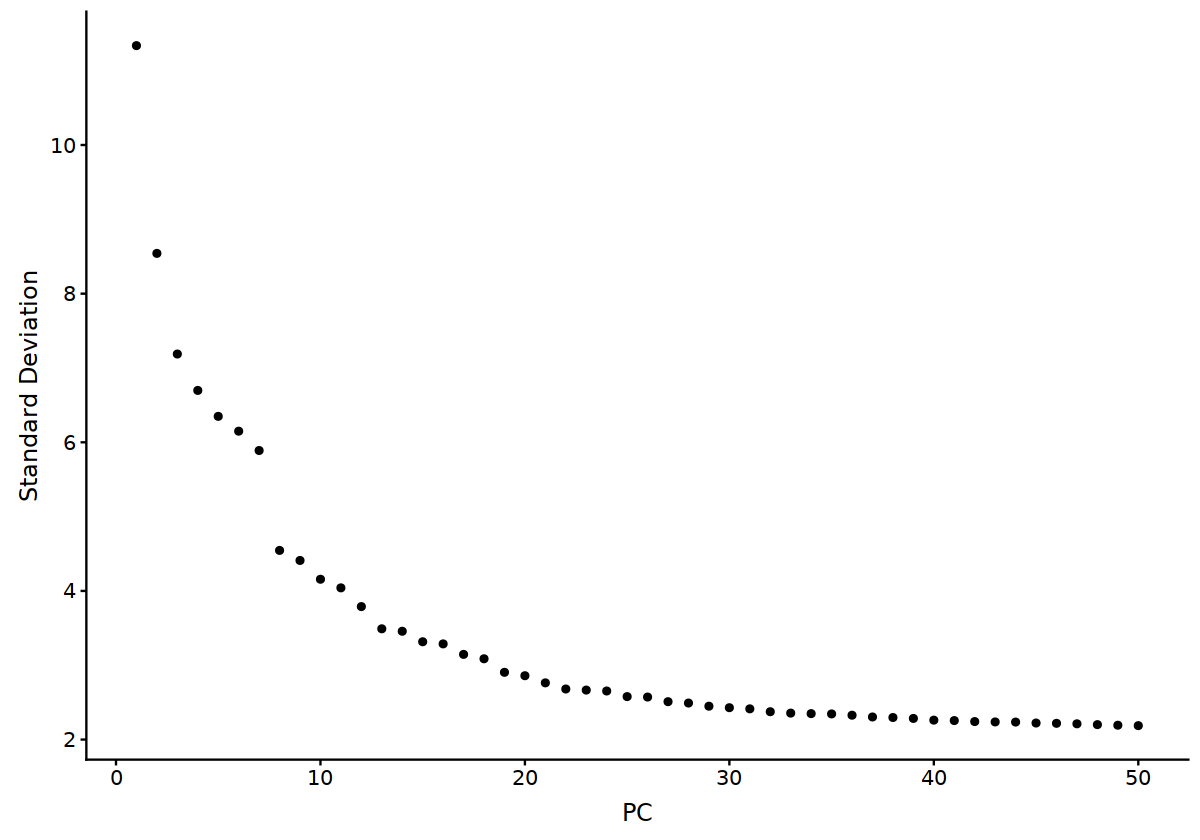

In [55]:
# easiest way to determine how many PCs to use. estimating on the higher side is always suggested.
# for example - the curve flattens at around 30 so choosing anything above 30 would be good.
ElbowPlot(sobj, ndims = 50, reduction = "pca")

In [56]:
dim = 30
var7 = dim

In [57]:
# Cluster the cells. resolution parameter describes how granular you want the clusters to be
# higher resolution means more clusters. usually we tune this paramter after seeing the results 
# from differential analysis to make sure we are not over clustering or under clustering
sobj <- FindNeighbors(sobj, dims = 1:dim)
sobj <- FindClusters(sobj, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2082
Number of edges: 62860

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9053
Number of communities: 10
Elapsed time: 0 seconds


In [58]:
# tSNE and UMAP for 2D visualisation
sobj <- RunUMAP(sobj, dims = 1:dim)
sobj <- RunTSNE(sobj, dims = 1:dim)

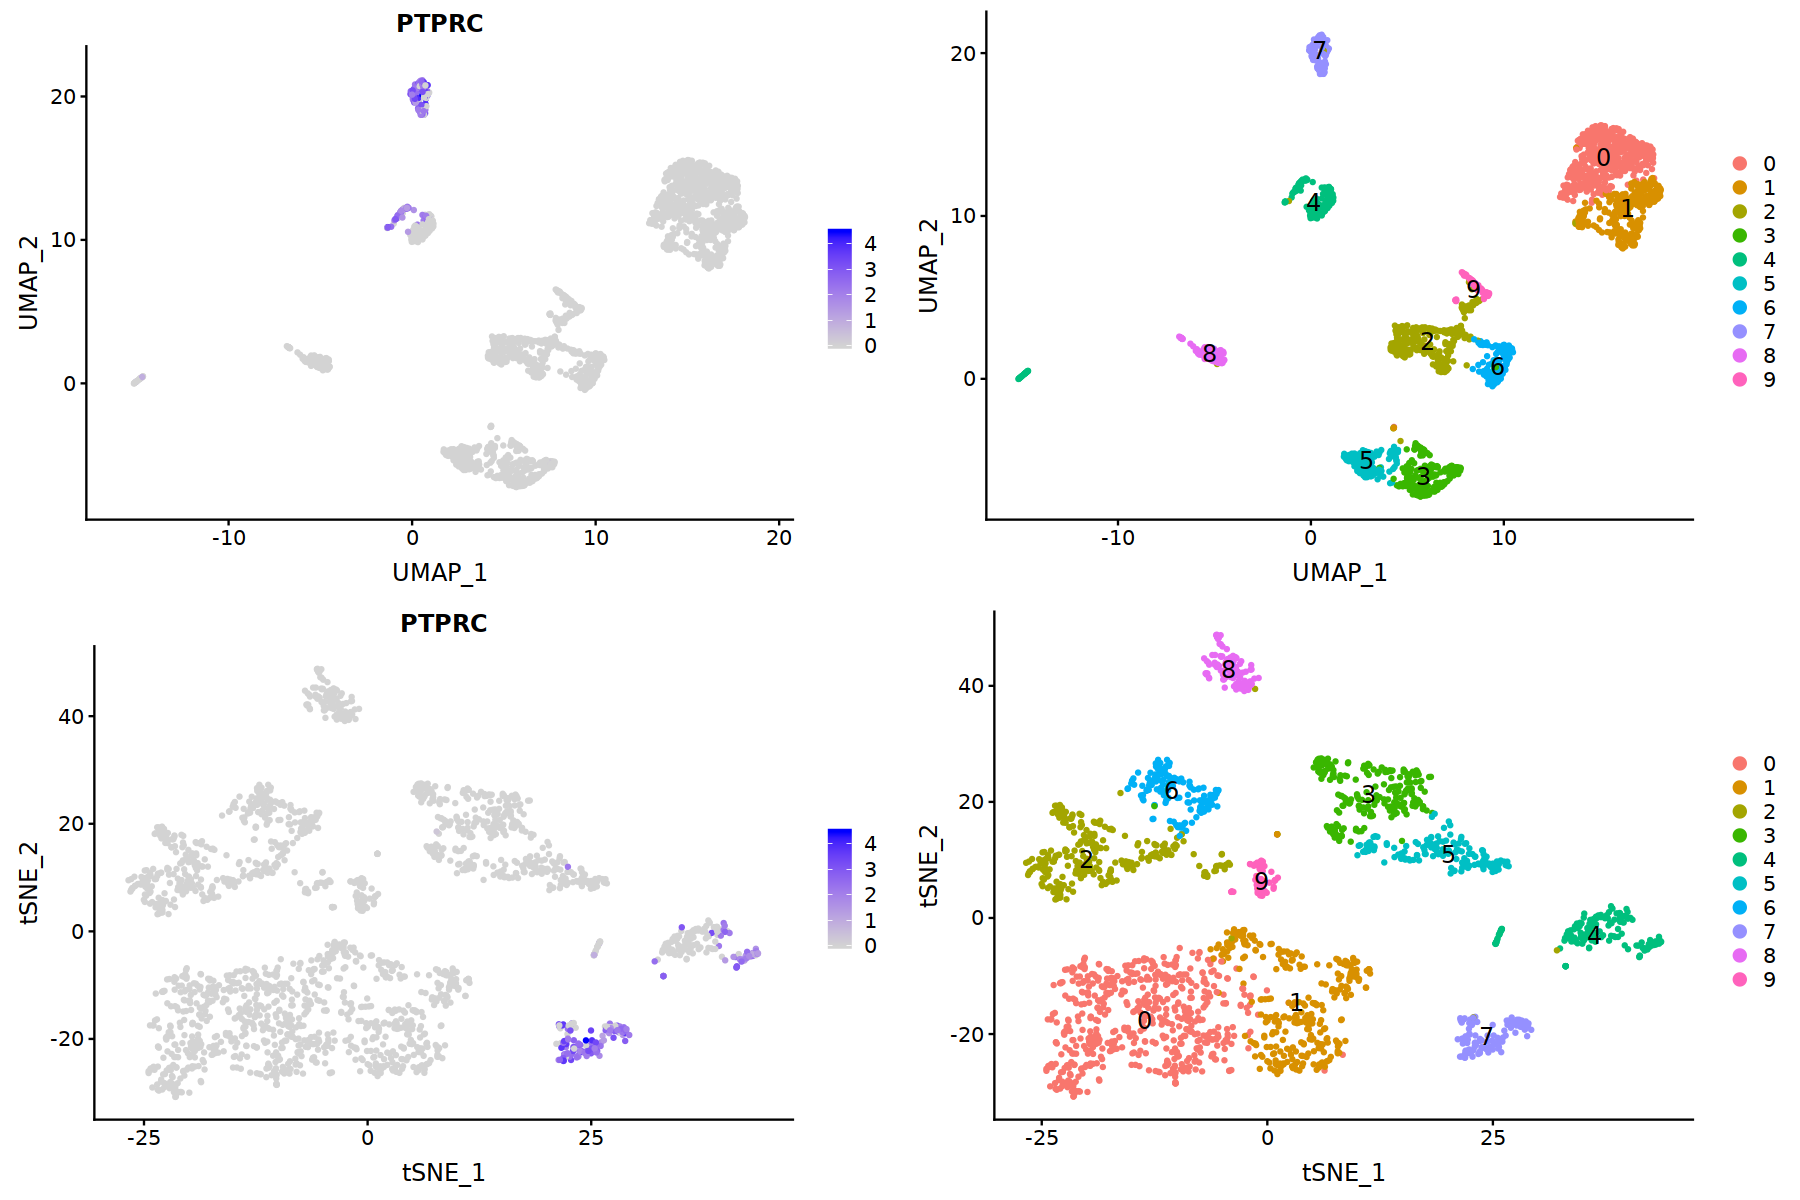

In [59]:
# Trying to visualise which clusters are immune cells by expression of PTPRC. UMAP better than tSNE usually.
options(repr.plot.width=15, repr.plot.height=10, cex=5)
plot1 <- FeaturePlot(sobj, reduction="umap", features = c("PTPRC"))
plot2 <- DimPlot(sobj, reduction = "umap", label=TRUE, label.size=5)
plot3 <- FeaturePlot(sobj, reduction="tsne", features = c("PTPRC"))
plot4 <- DimPlot(sobj, reduction = "tsne", label=TRUE, label.size=5)
gridExtra::grid.arrange(plot1, plot2, plot3, plot4, nrow=2)

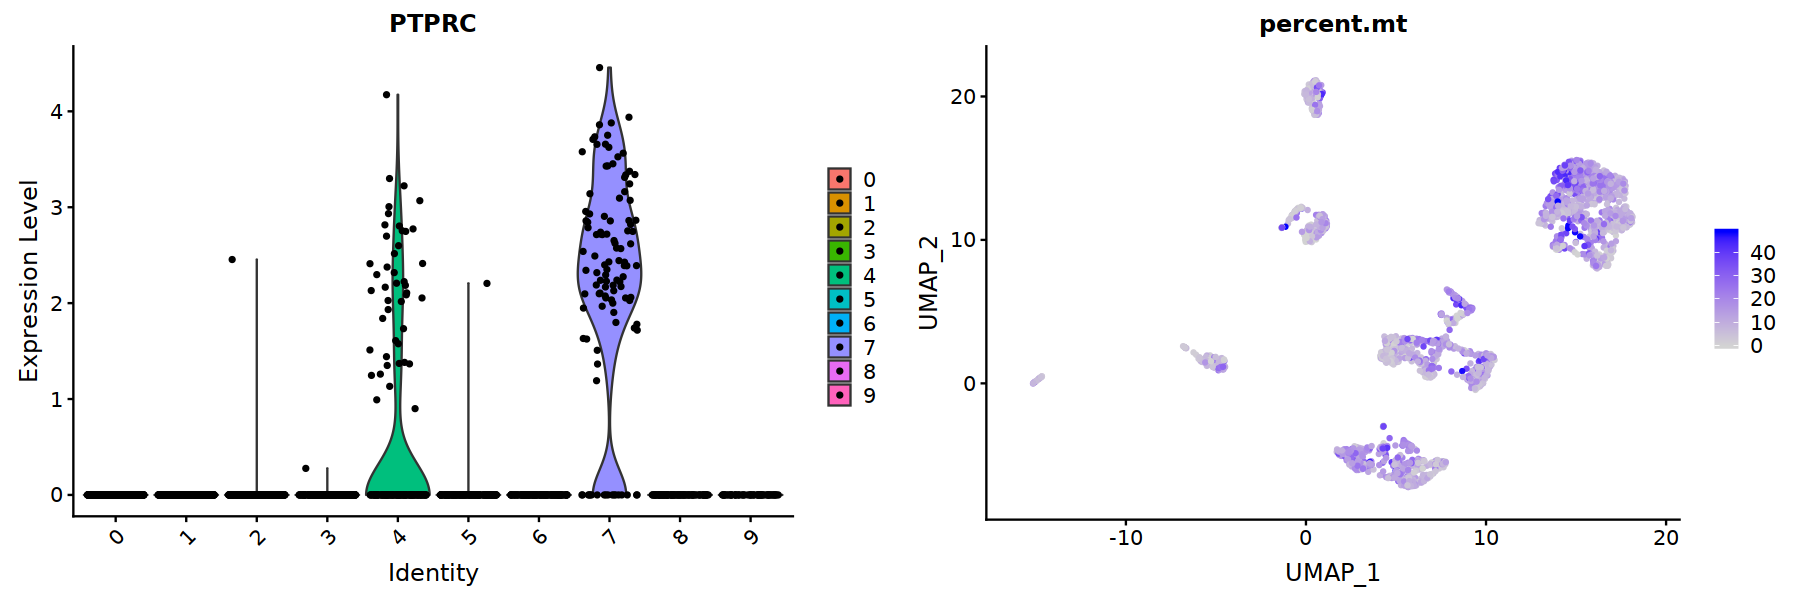

In [60]:
options(repr.plot.width=15, repr.plot.height=5, cex=5)
plot1 <- VlnPlot(sobj, features = c("PTPRC"))
plot2 <- FeaturePlot(sobj, reduction="umap", features = "percent.mt")
gridExtra::grid.arrange(plot1, plot2, nrow=1)

In [61]:
ptprc_pos_clusters = c(4,7)
var8 = length(unique(sobj@meta.data$seurat_clusters))
var9 = ptprc_pos_clusters

In [62]:
# adding a column to metadata for cell type (immune or non-immune)
sobj[["type"]] <- NA
sobj$type[WhichCells(object = sobj, ident = ptprc_pos_clusters)] <- "immune"
sobj$type[WhichCells(object = sobj, ident = ptprc_pos_clusters, invert=TRUE)] <- "non-immune"

In [63]:
# # find all markers distinguishing cluster 7 from others
# cluster7.markers <- FindMarkers(sobj, ident.1 = 7, ident.2 = 13, min.pct = 0.25)
# head(cluster7.markers, n = 5)

In [64]:
# Differential Analysis
sobj.markers <- FindAllMarkers(sobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9



In [65]:
# sobj.markers %>% group_by(cluster) %>% top_n(n = 2, wt = avg_logFC)
# top_per_cluster=subset(Reduce(rbind,by(p1.markers, p1.markers["cluster"], head, n=5)), avg_logFC>2)
top_per_cluster=Reduce(rbind,by(sobj.markers, sobj.markers["cluster"], head, n=10))

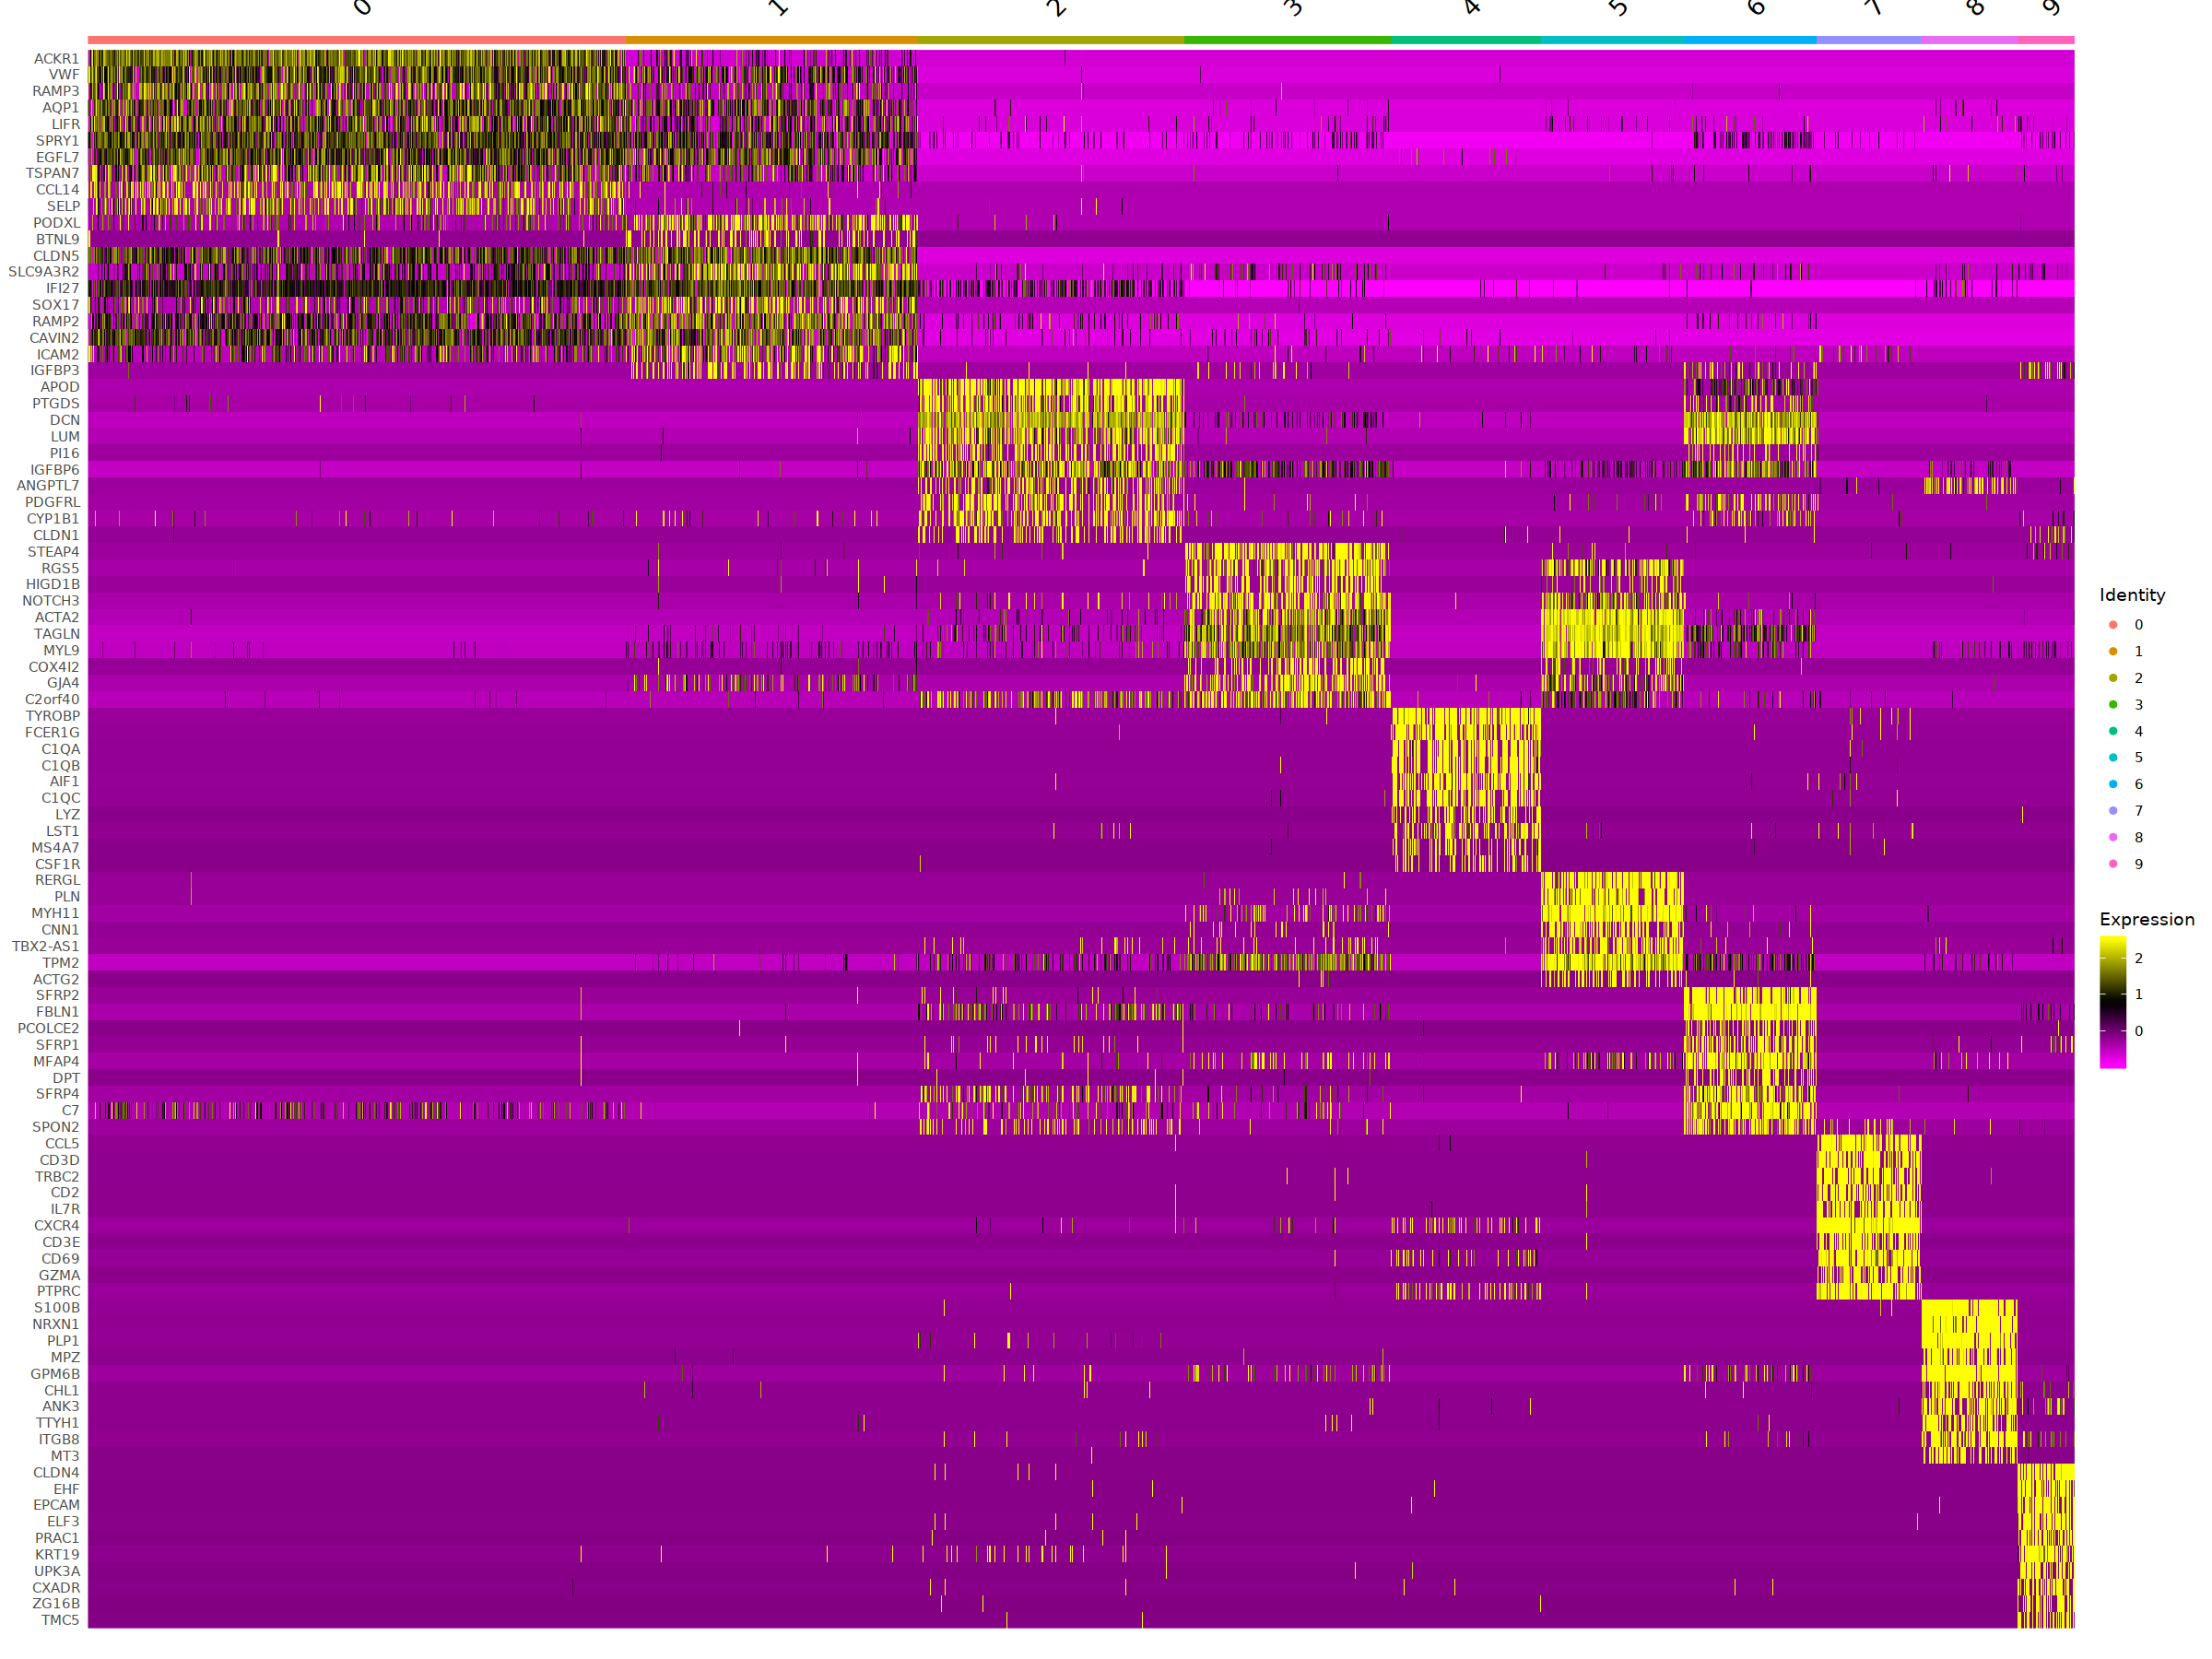

In [66]:
options(repr.plot.width=20, repr.plot.height=15, cex=10)
DoHeatmap(sobj, features = top_per_cluster$gene)

Warning message in FetchData(object = object, vars = c(dims, features), cells = cells):
"The following requested variables were not found: SPINK1, LIPF, MSMB, HBB, AFT3"


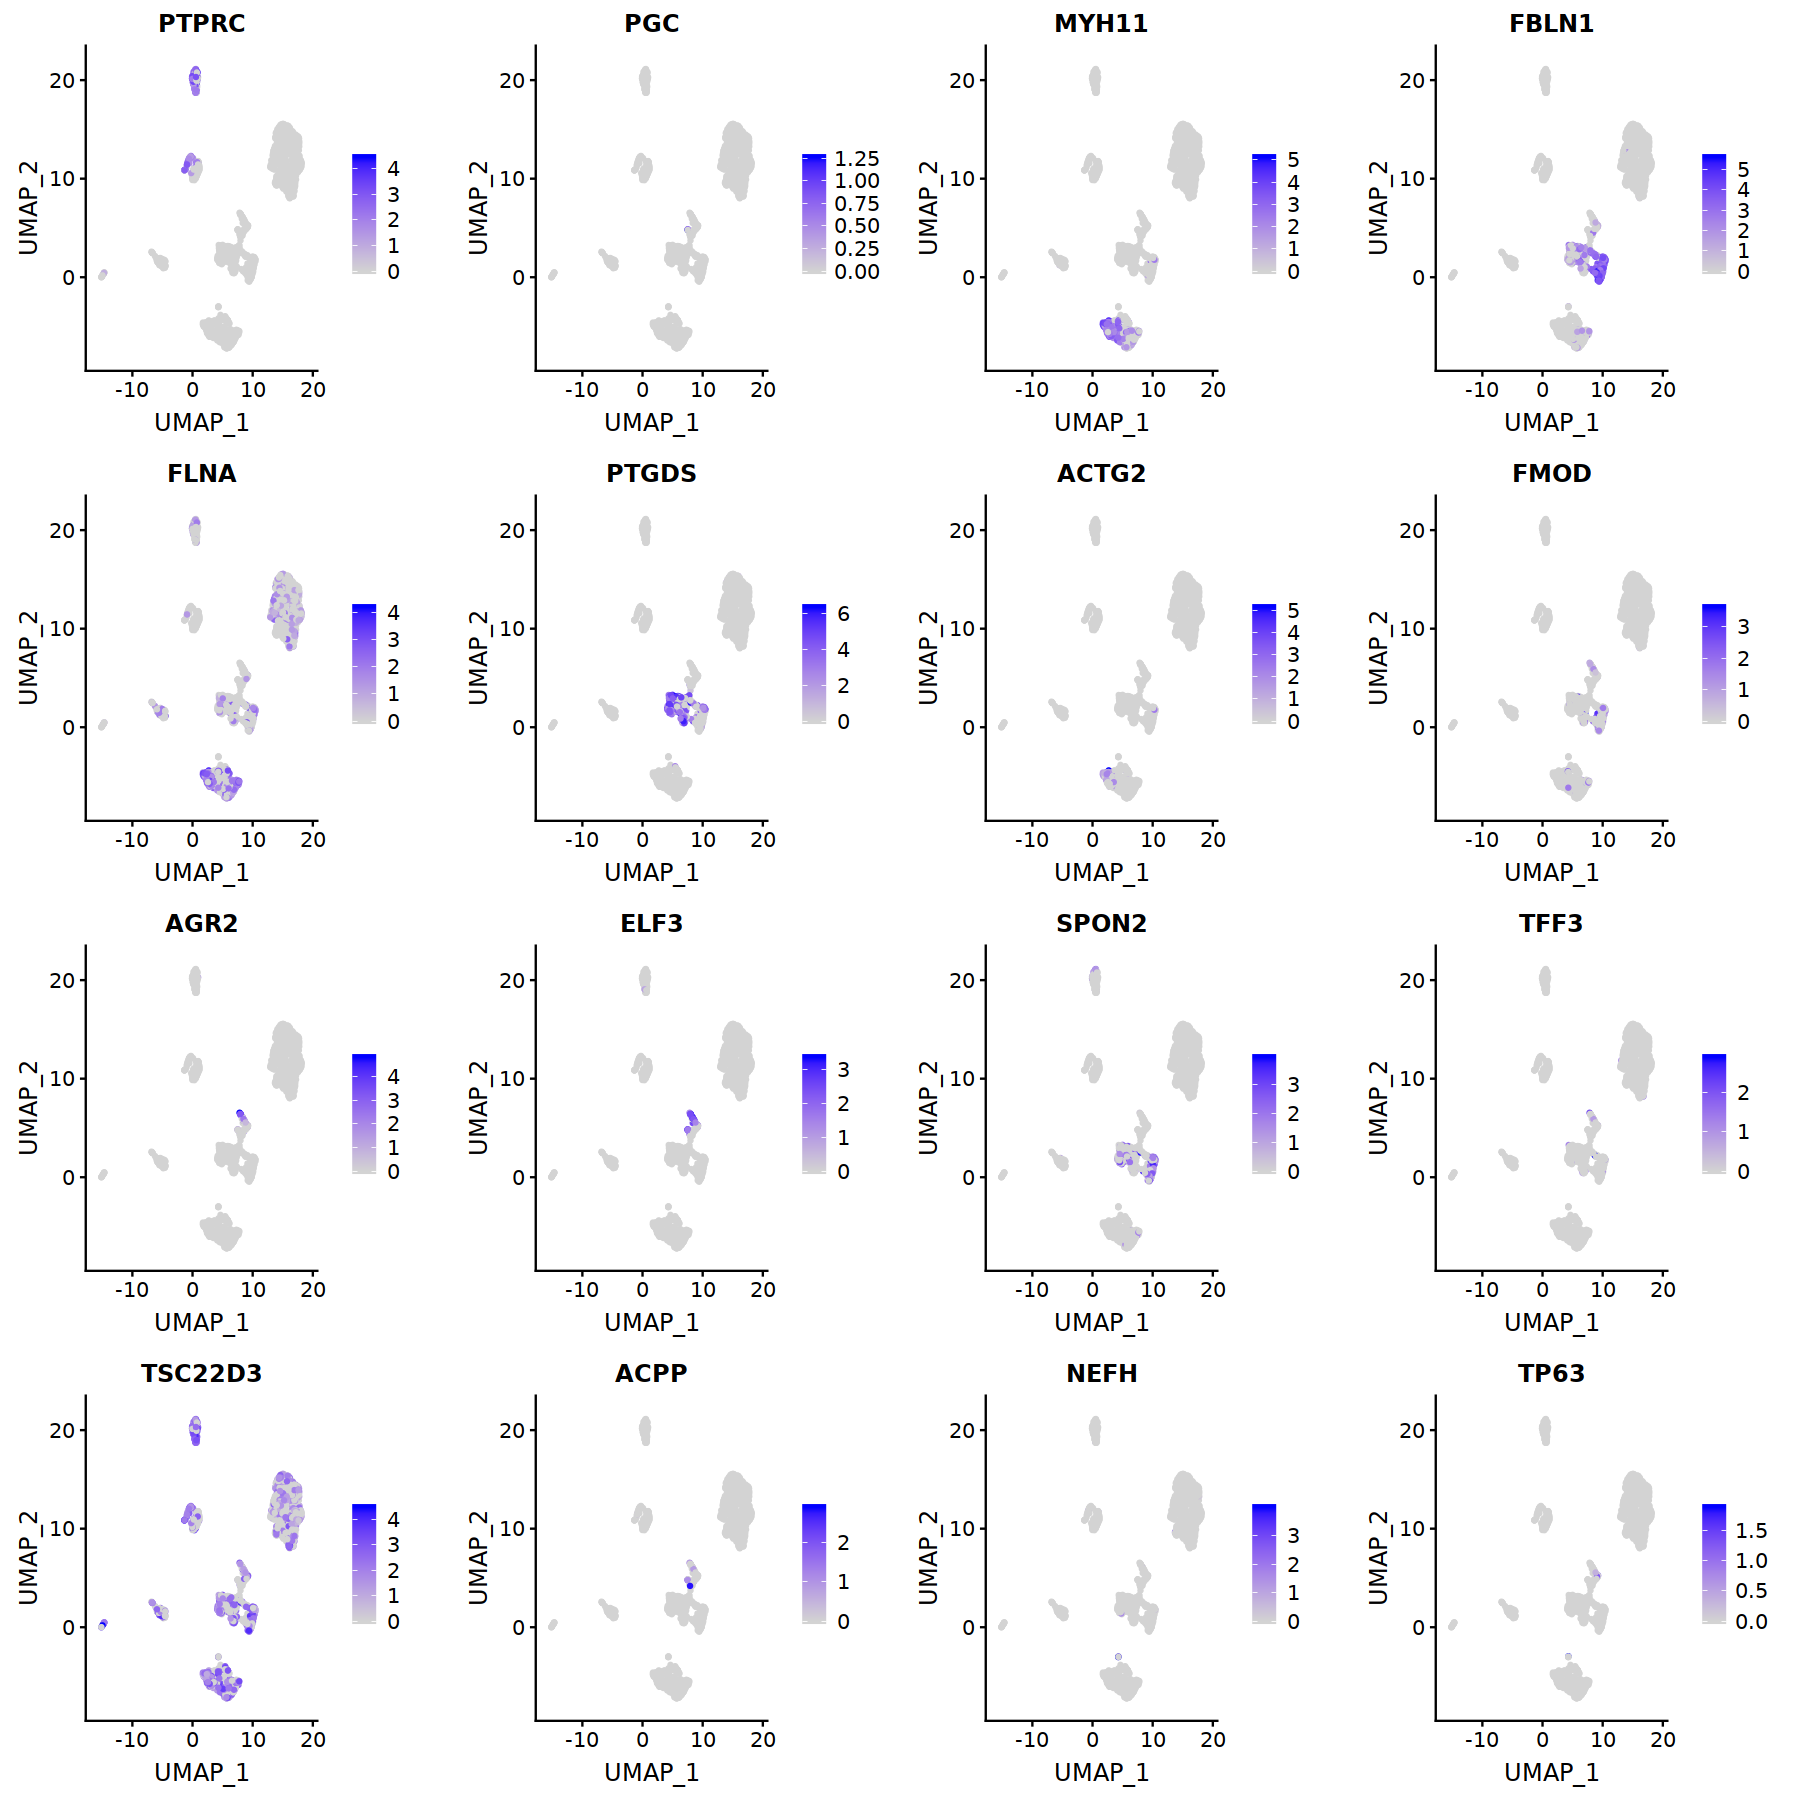

In [67]:
# High/low expression in cancer
options(repr.plot.width=15, repr.plot.height=15, cex=10)
FeaturePlot(sobj, reduction="umap", 
            features = c("PTPRC",
                         "SPINK1","PGC","MYH11", "FBLN1", "FLNA", "PTGDS", "ACTG2","LIPF", "FMOD", "AGR2", "ELF3", 
                         "SPON2","TFF3", 
                         "MSMB","TSC22D3","ACPP", "NEFH","HBB", "AFT3", "TP63"))

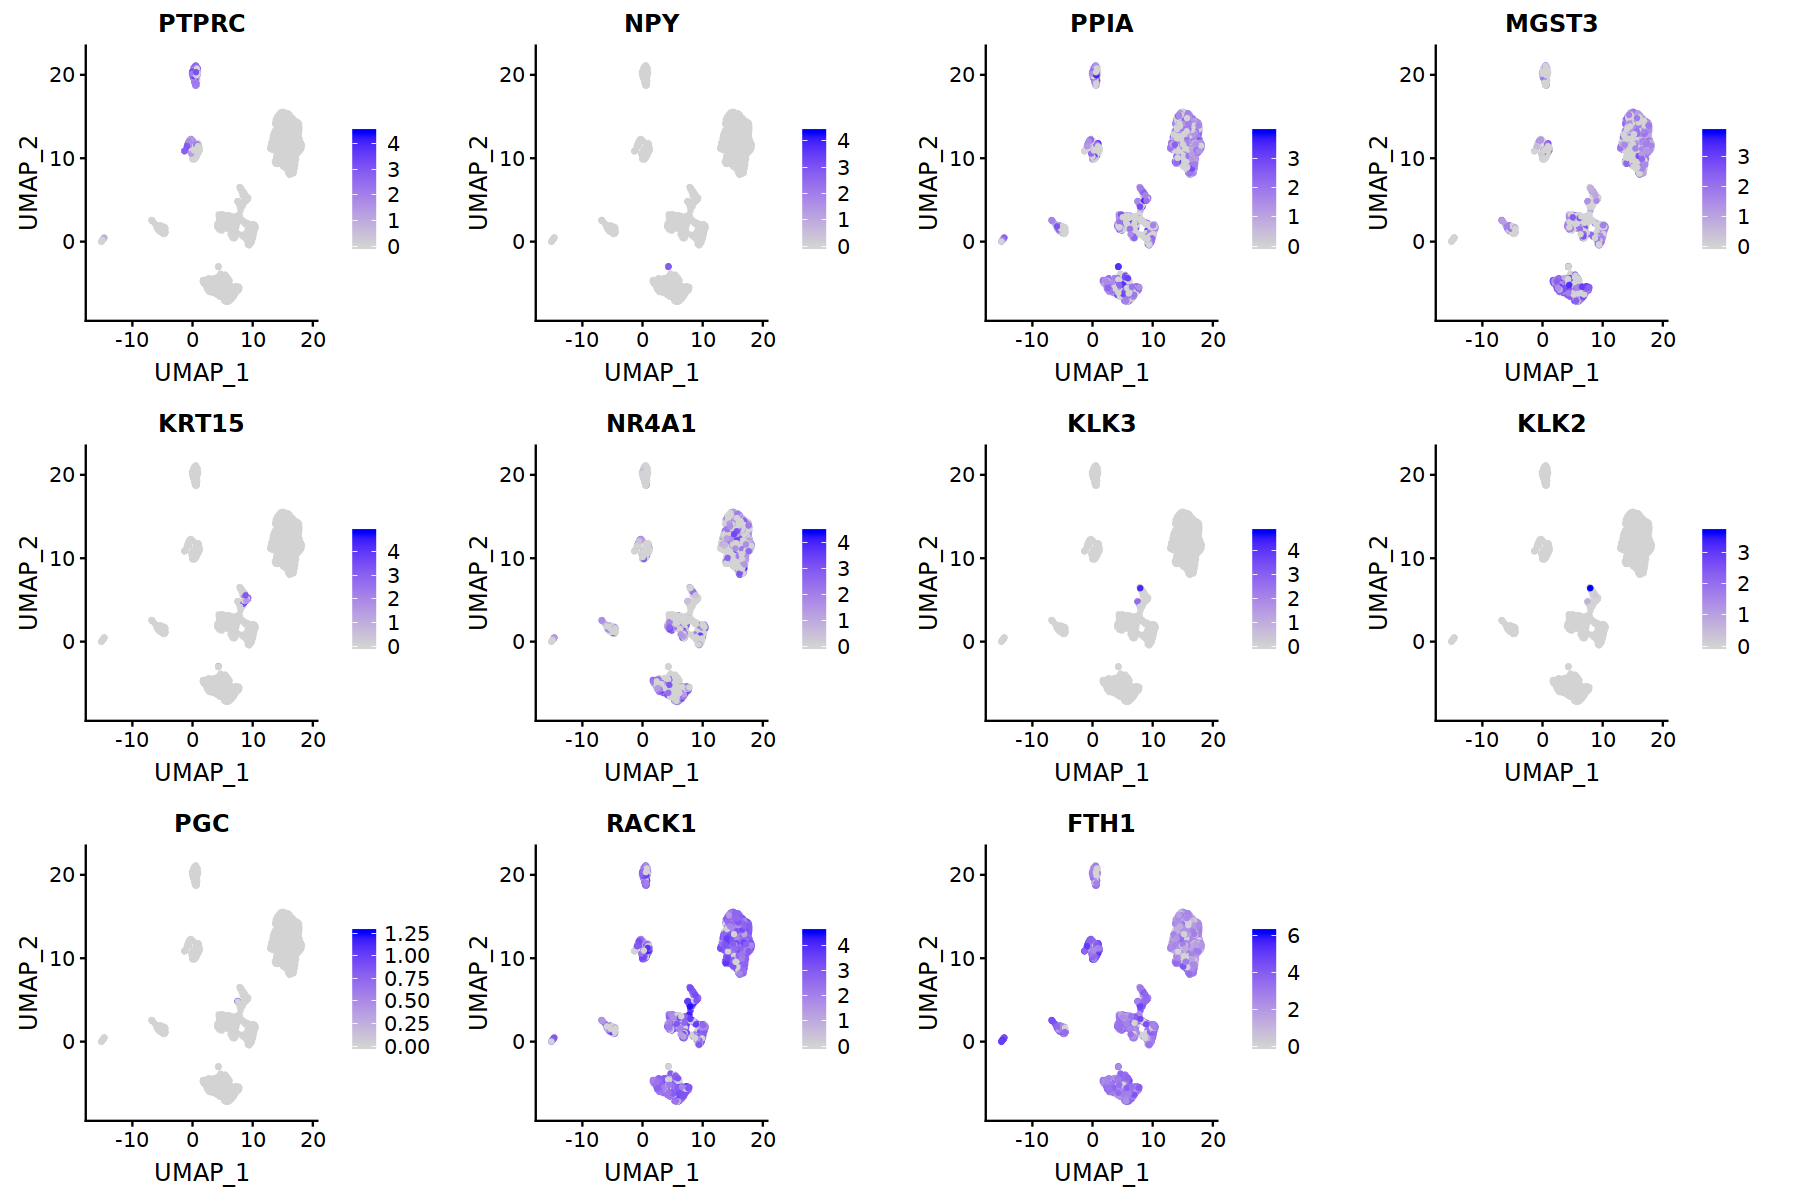

In [68]:
# High expression in PIN
options(repr.plot.width=15, repr.plot.height=10, cex=10)
FeaturePlot(sobj, reduction="umap", 
            features = c("PTPRC","NPY", "PPIA", "MGST3", "KRT15",
                         "NR4A1",
                        "KLK3","KLK2","PGC", "RACK1", "FTH1"))

Warning message in FetchData(object = object, vars = c(dims, features), cells = cells):
"The following requested variables were not found: PSCA, SPINK1"


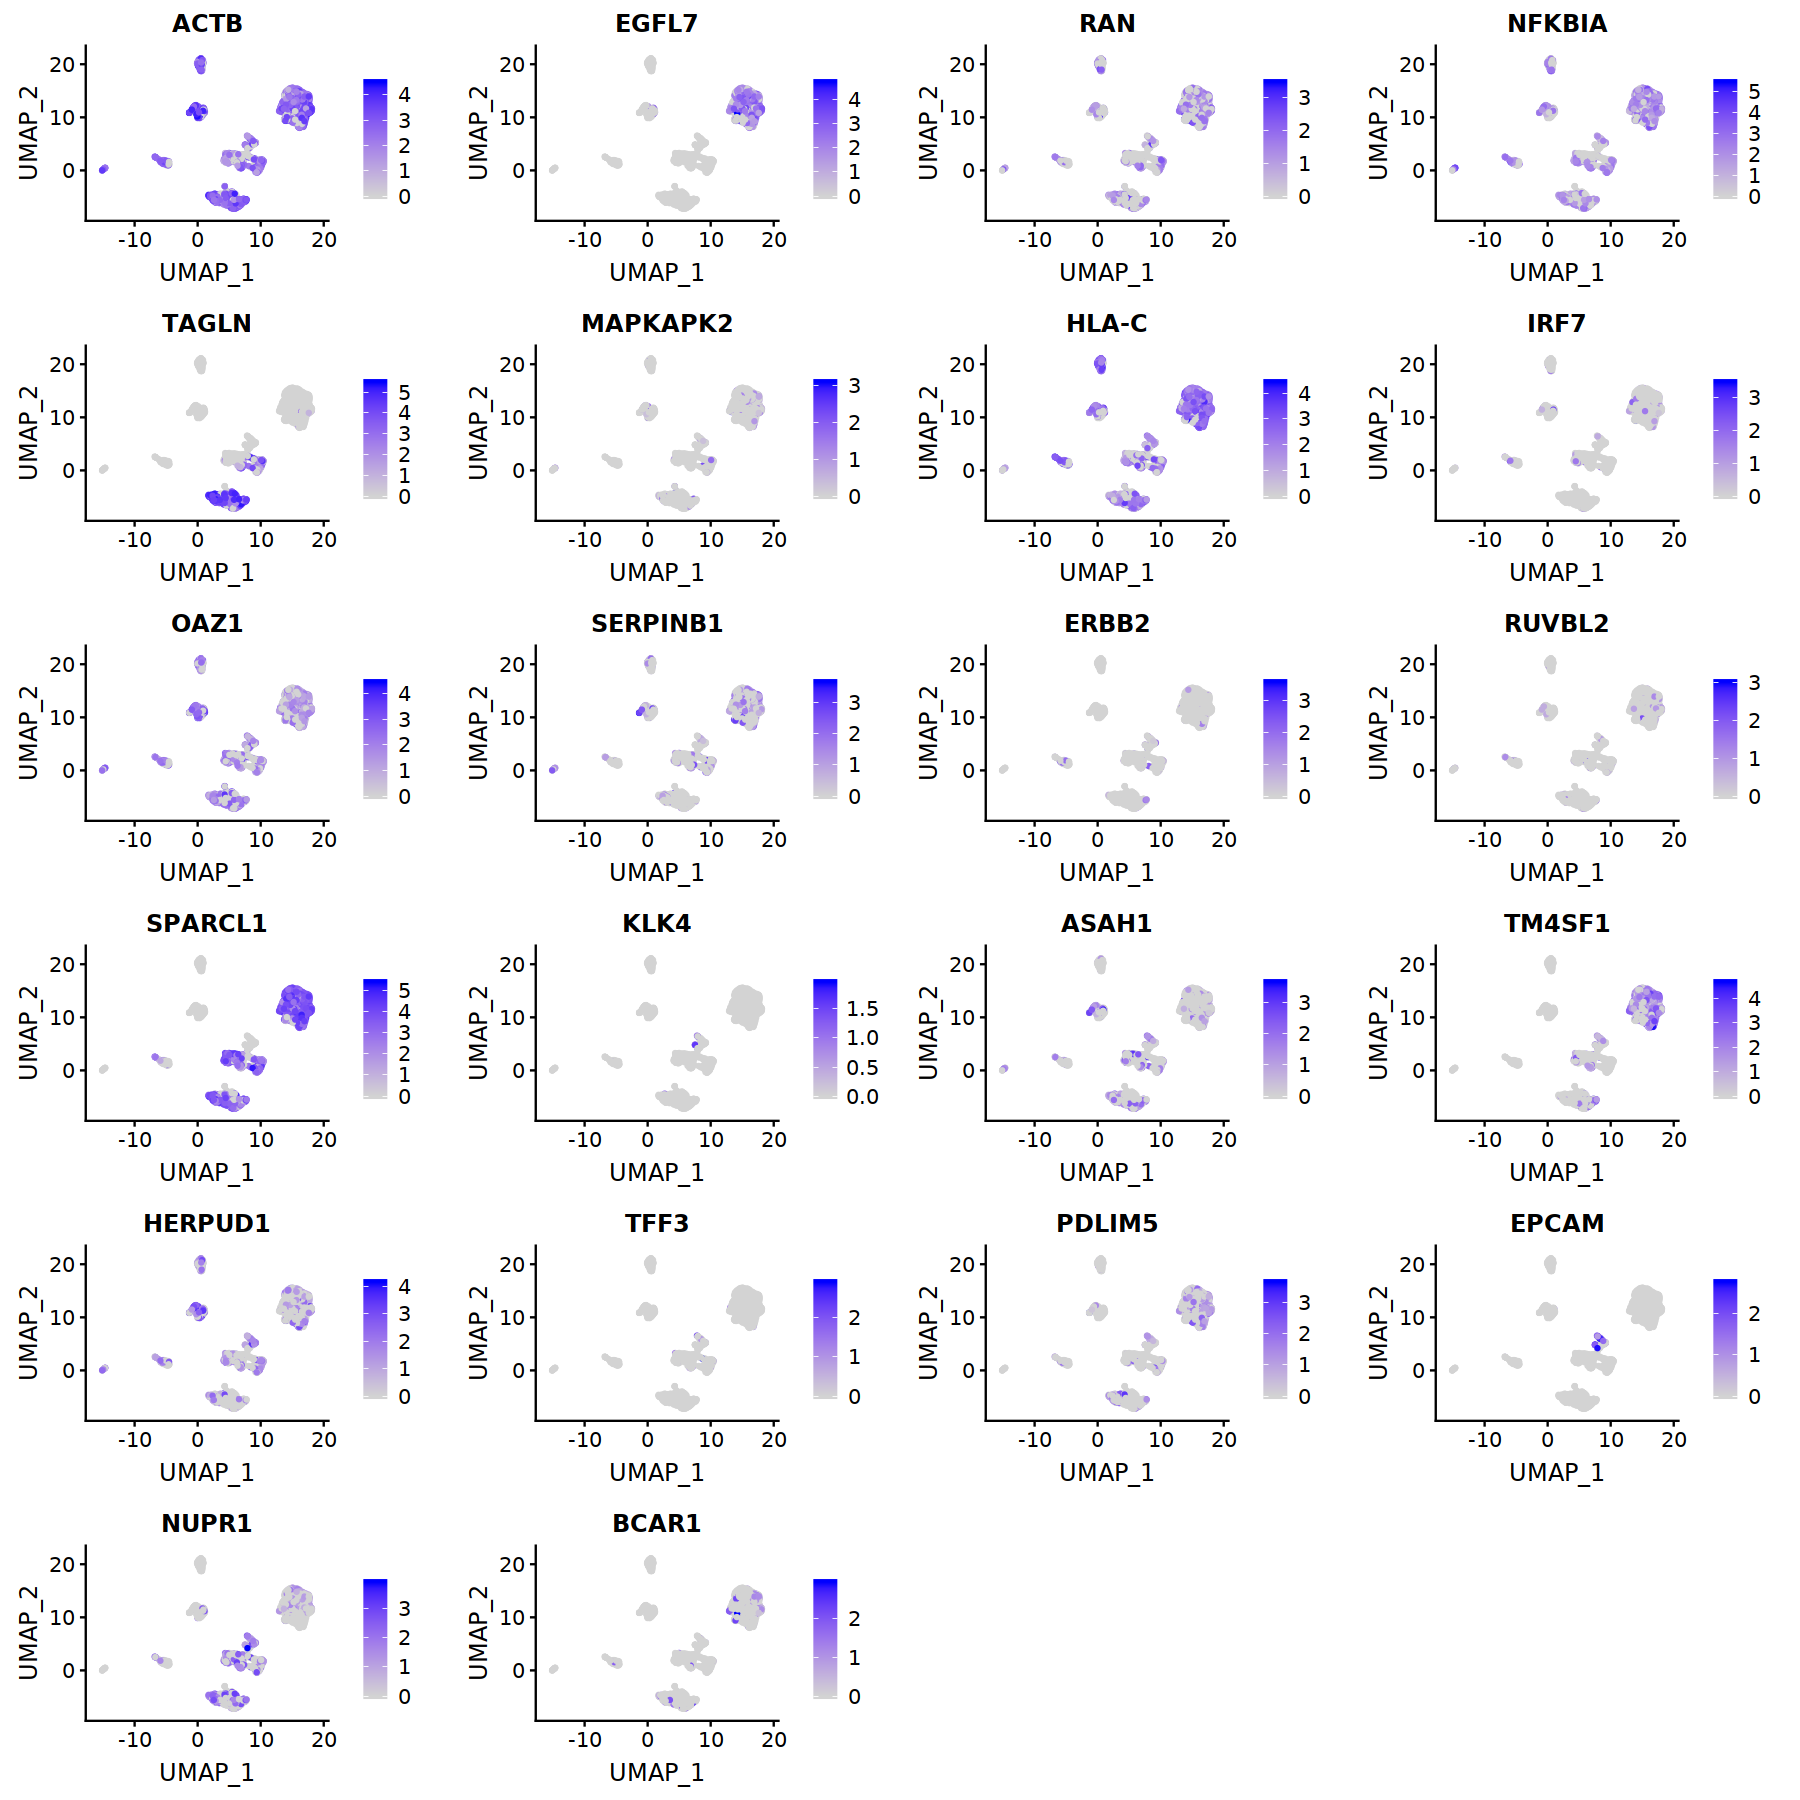

In [69]:
#Separating core from periphery cells
options(repr.plot.width=15, repr.plot.height=15, cex=10)
FeaturePlot(sobj, reduction="umap", 
            features = c("ACTB","EGFL7","RAN","NFKBIA","TAGLN","MAPKAPK2", "HLA-C","IRF7","OAZ1","SERPINB1",
                         "ERBB2","RUVBL2","SPARCL1","KLK4","ASAH1","TM4SF1","PSCA","HERPUD1","TFF3","PDLIM5","EPCAM", "SPINK1","NUPR1", "BCAR1"
                        ))

Warning message in FetchData(object = object, vars = features):
"The following requested variables were not found: DUOXA2, GPX2, TRIM31, TMPRSS4, CLCA4, PSCA"
Warning message in FetchData(object = object, vars = features):
"The following requested variables were not found: PSCA, SPINK1, DUOXA2, CEACAM6, CEACAM5, LINC01207"
Warning message in FetchData(object = object, vars = features):
"The following requested variables were not found: CYR61"
Warning message in FetchData(object = object, vars = features):
"The following requested variables were not found: MSMB, CD24, PSCA, FLJ20021"
Warning message in FetchData(object = object, vars = features):
"The following requested variables were not found (10 out of 15 shown): GRP, CALCA, ASCL1, ZACN, MS4A8, DDC, SCG3, SLC35D3, MIR7-3HG, HTR3C"
Warning message in FetchData(object = object, vars = features):
"The following requested variables were not found: ECSCR.1"


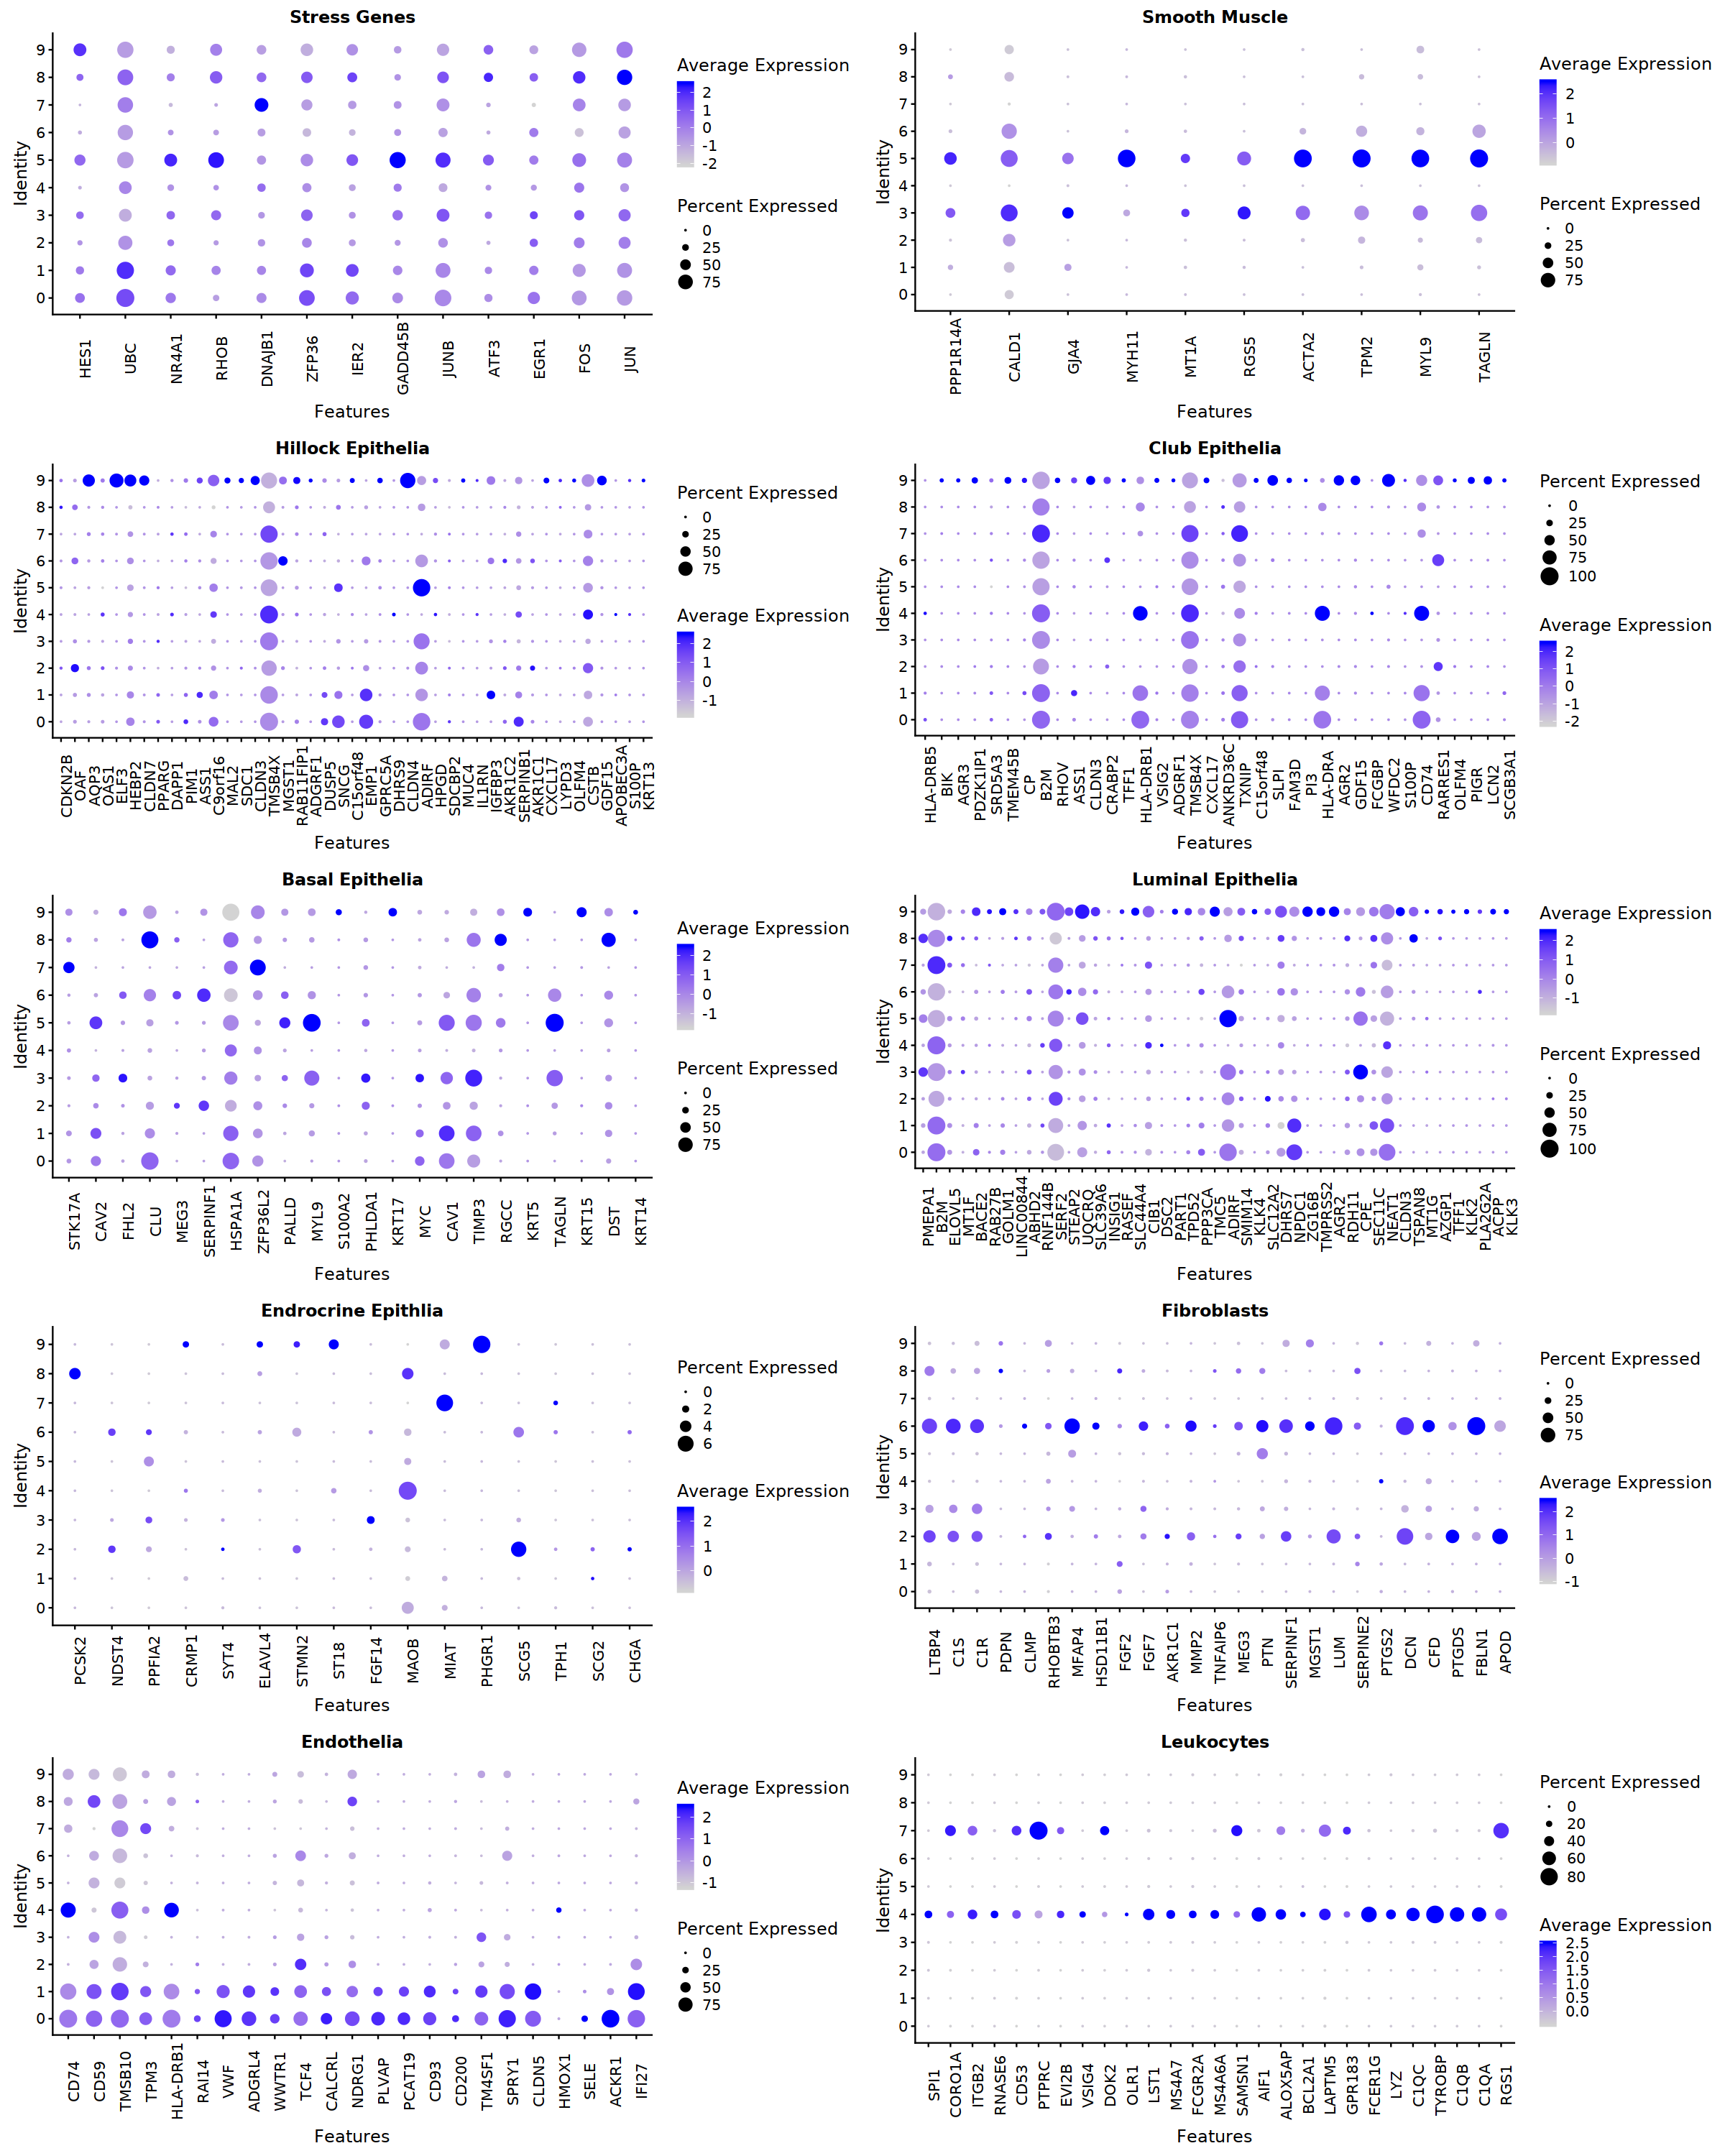

In [70]:
# markers from Henry et al. (2018): https://www.cell.com/cell-reports/pdf/S2211-1247(18)31877-1.pdf
options(repr.plot.width=20, repr.plot.height=25, cex=10)
celltype=read.csv("/home/unix/sjohri/valab_sjohri/projects/ex-vivo/data/henry_et_al.csv")
p1 <- DotPlot(sobj, features=unlist(lapply(list(as.character(celltype$X...stress)), function(x) x[!x %in% ""])))+theme(axis.text.x = element_text(angle = 90))+ggtitle("Stress Genes")
p2 <- DotPlot(sobj, features=unlist(lapply(list(as.character(celltype$smooth_muscle)), function(x) x[!x %in% ""])))+theme(axis.text.x = element_text(angle = 90))+ggtitle("Smooth Muscle")
p3 <- DotPlot(sobj, features=unlist(lapply(list(as.character(celltype$hillock_epithelia)), function(x) x[!x %in% ""])))+theme(axis.text.x = element_text(angle = 90))+ggtitle("Hillock Epithelia")
p4 <- DotPlot(sobj, features=unlist(lapply(list(as.character(celltype$club_epithelia)), function(x) x[!x %in% ""])))+theme(axis.text.x = element_text(angle = 90))+ggtitle("Club Epithelia")
p5 <- DotPlot(sobj, features=unlist(lapply(list(as.character(celltype$basal_epithelia)), function(x) x[!x %in% ""])))+theme(axis.text.x = element_text(angle = 90))+ggtitle("Basal Epithelia")
p6 <- DotPlot(sobj, features=unlist(lapply(list(as.character(celltype$luminal_epithelia)), function(x) x[!x %in% ""])))+theme(axis.text.x = element_text(angle = 90))+ggtitle("Luminal Epithelia")
p7 <- DotPlot(sobj, features=unlist(lapply(list(as.character(celltype$neuroendocrine_epithelia)), function(x) x[!x %in% ""])))+theme(axis.text.x = element_text(angle = 90))+ggtitle("Endrocrine Epithlia")
p8 <- DotPlot(sobj, features=unlist(lapply(list(as.character(celltype$fibroblasts)), function(x) x[!x %in% ""])))+theme(axis.text.x = element_text(angle = 90))+ggtitle("Fibroblasts")
p9 <- DotPlot(sobj, features=unlist(lapply(list(as.character(celltype$endothelia)), function(x) x[!x %in% ""])))+theme(axis.text.x = element_text(angle = 90))+ggtitle("Endothelia")
p10 <- DotPlot(sobj, features=unlist(lapply(list(as.character(celltype$leukocytes)), function(x) x[!x %in% ""])))+theme(axis.text.x = element_text(angle = 90))+ggtitle("Leukocytes")
gridExtra::grid.arrange(p1,p2,p3,p4,p5,p6,p7,p8,p9,p10, nrow=5)

## Analysis of Immune Cells

In [71]:
# Subset PTPRC+ clusters and create a seurat object
ntumor_data = as.matrix(GetAssayData(sobj, slot = "counts")[, WhichCells(sobj, ident = ptprc_pos_clusters)])
ntumor_obj = CreateSeuratObject(counts = ntumor_data, project = var1)
ntumor_obj

An object of class Seurat 
18447 features across 268 samples within 1 assay 
Active assay: RNA (18447 features)

In [72]:
var10 = ncol(ntumor_obj)
var10

[1] 268

In [73]:
# Normalisation
ntumor_obj = NormalizeData(ntumor_obj, normalization.method = "LogNormalize", scale.factor = 10000)

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Transformation introduced infinite values in continuous x-axis"


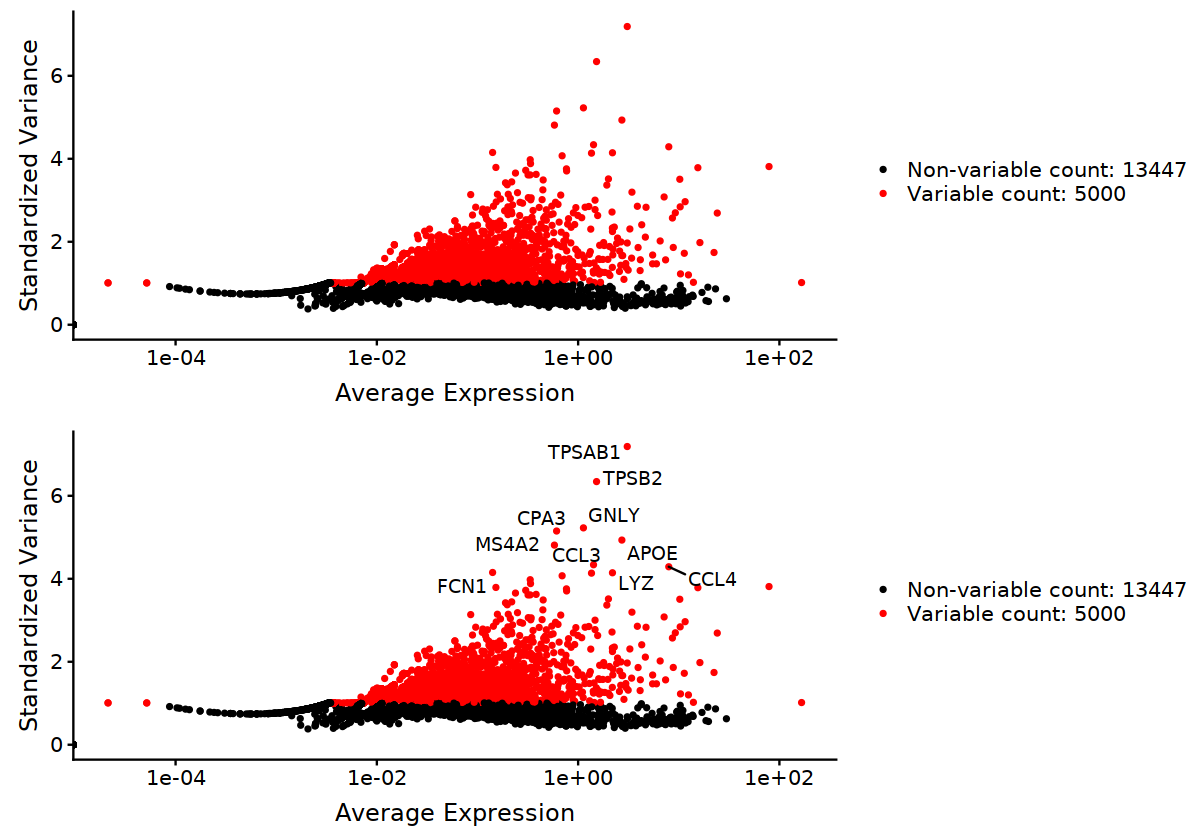

In [74]:
options(repr.plot.width=10, repr.plot.height=7, cex=5)
#Identification of highly variable features (feature selection)
ntumor_obj <- FindVariableFeatures(ntumor_obj, selection.method = "vst", nfeatures = 5000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(ntumor_obj), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(ntumor_obj)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE, xnudge=0, ynudge=0)
gridExtra::grid.arrange(plot1,plot2)

In [75]:
#Scaling the data
all.genes <- rownames(ntumor_obj)
ntumor_obj <- ScaleData(ntumor_obj, features = all.genes)

Centering and scaling data matrix



In [76]:
#Perform linear dimensionality reduction with top variable features
ntumor_obj <- RunPCA(ntumor_obj, features = VariableFeatures(object = ntumor_obj));

PC_ 1 
Positive:  RHOB, KLF4, CLEC7A, EPB41L3, KCTD12, IER3, MGAT1, FGL2, SGK1, WSB1 
	   SLC1A3, VMP1, C5AR1, FCGR2A, MAFB, IFI30, NEAT1, CEBPD, LRRC25, MS4A7 
	   CIITA, SRGAP1, PTPN12, CYBB, ZNF812P, HBEGF, MEF2C, GLUL, FMNL2, IRS2 
Negative:  CCL5, IL32, IL7R, GZMA, CD3G, GZMK, MT-ATP6, SYNE2, NKG7, CST7 
	   CD8A, CD52, CD8B, PYHIN1, TRAT1, LINC01871, GZMM, CEMIP2, GZMH, CD27 
	   CD69, KLRB1, TIGIT, SH2D1A, CXCR6, RORA, MT-ND3, CLEC2D, OCIAD2, CD40LG 
PC_ 2 
Positive:  HLA-DRA, HLA-DPA1, HLA-DPB1, CD74, C1QB, C1QA, HLA-DRB1, C1QC, HLA-DQA1, CST3 
	   HLA-DQB1, FTL, HLA-DRB6, AIF1, TYROBP, SELENOP, HLA-DMA, FCGRT, CD14, FOLR2 
	   RNASE1, A2M, GGTA1P, GPX1, DAB2, NPC2, CTSB, CTSZ, CD163, F13A1 
Negative:  MALAT1, CD69, CPA3, IL1RL1, TPSAB1, TPSB2, KIT, S100A4, MS4A2, S100A6 
	   SRGN, ACSL4, TRIM63, SAMSN1, SLC18A2, CD52, ID2, BATF, JUNB, GATA2 
	   MLPH, VIM, BIRC3, VWA5A, RHEX, DUSP2, DUSP1, ANXA1, NFKBIZ, FOSB 
PC_ 3 
Positive:  TPSAB1, TPSB2, CPA3, MS4A2, IL1RL1, KIT, VWA5A, R

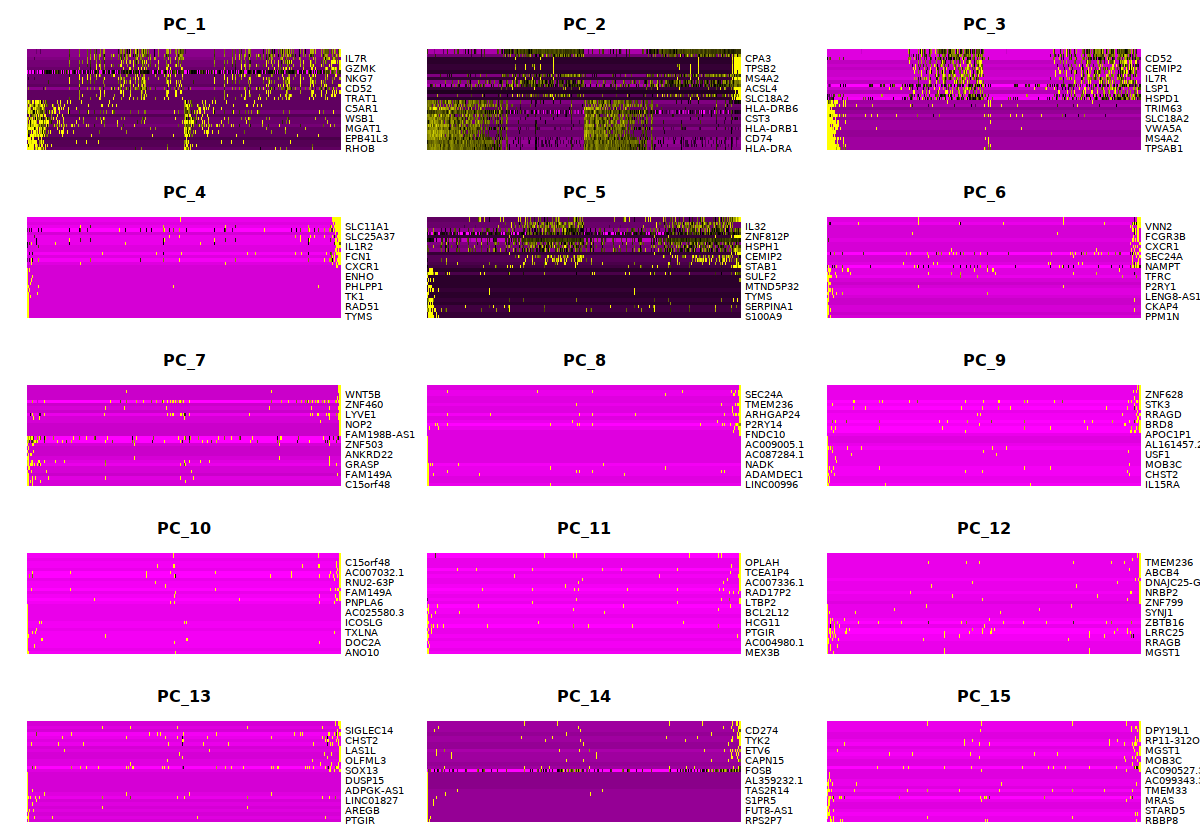

In [77]:
DimHeatmap(ntumor_obj, dims = 1:15, cells = 500, balanced = TRUE)

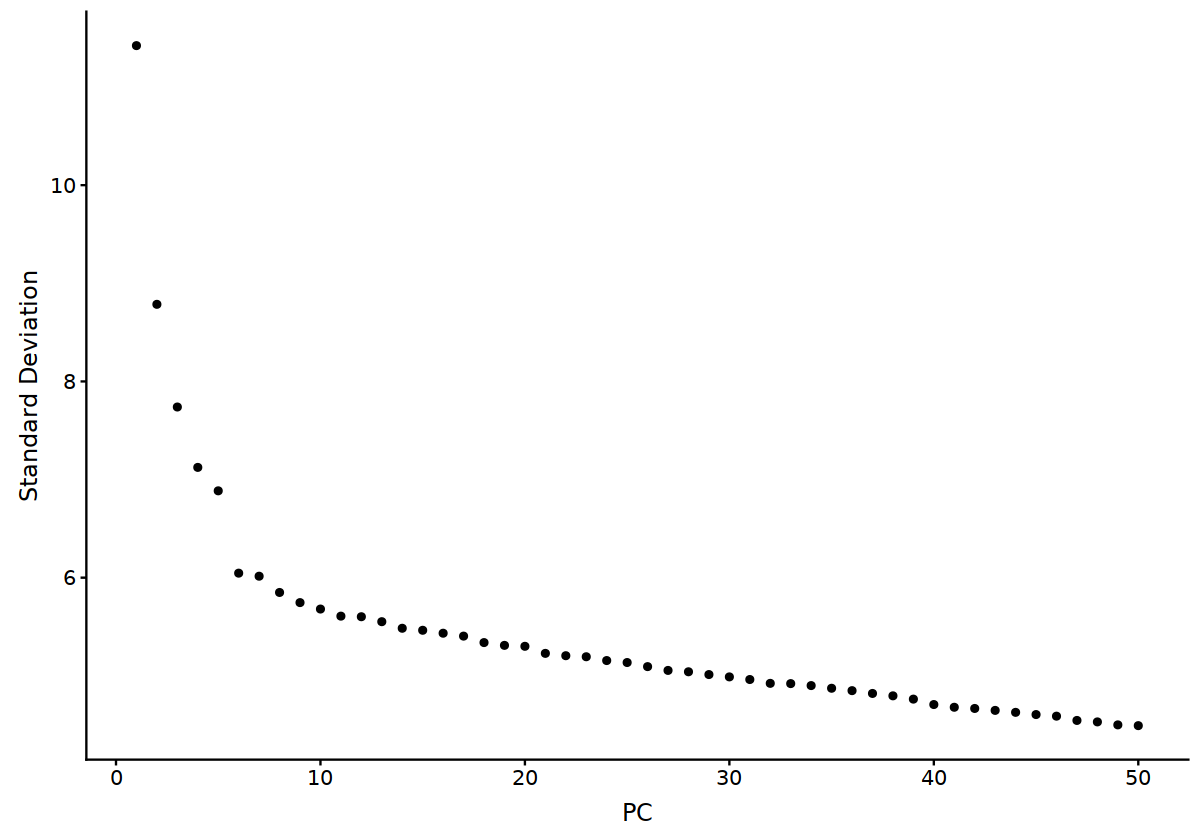

In [78]:
ElbowPlot(ntumor_obj, ndims = 50, reduction = "pca")

In [79]:
# Cluster the cells
ntumor_obj <- FindNeighbors(ntumor_obj, dims = 1:50)
ntumor_obj <- FindClusters(ntumor_obj, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 268
Number of edges: 11587

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7159
Number of communities: 2
Elapsed time: 0 seconds


In [80]:
ntumor_obj <- RunUMAP(ntumor_obj, dims = 1:50)
ntumor_obj <- RunTSNE(ntumor_obj, dims = 1:50)

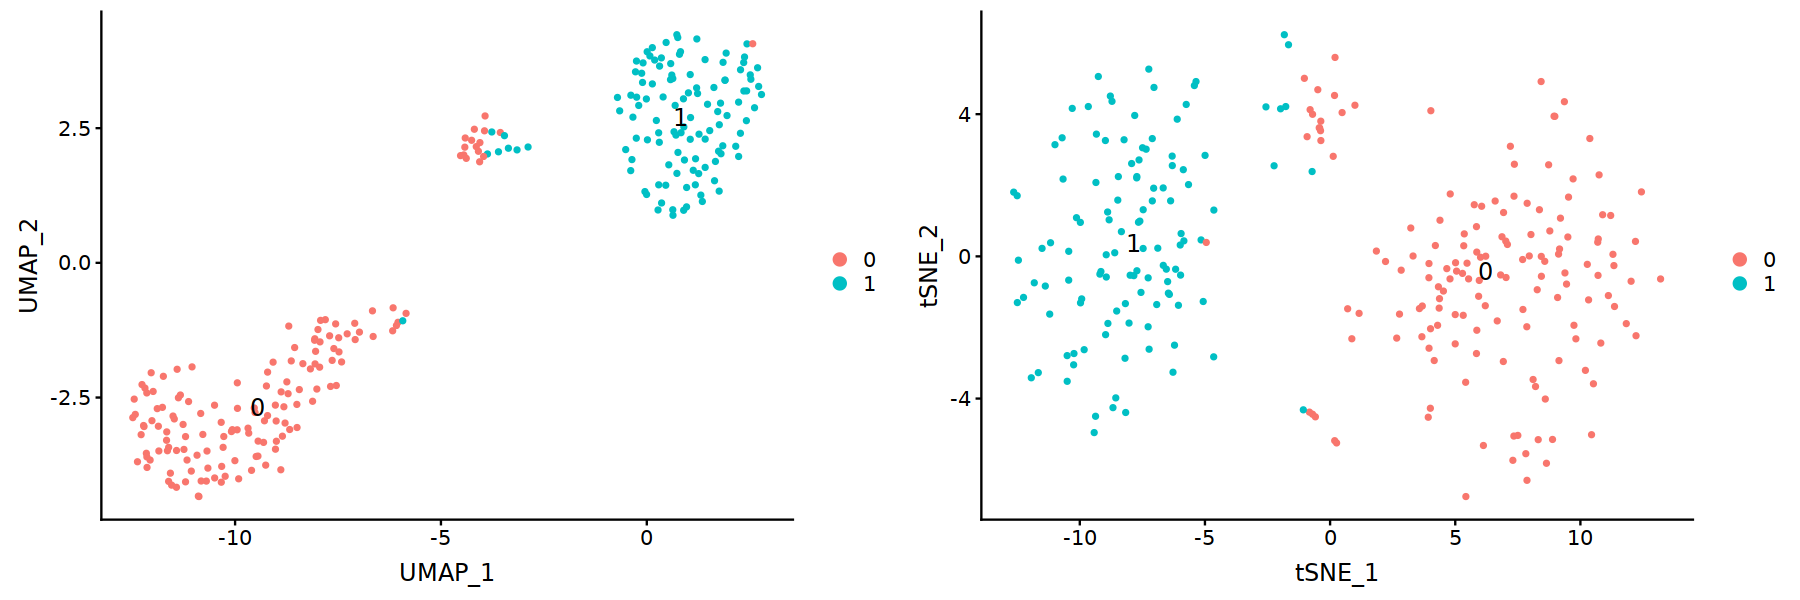

In [81]:
options(repr.plot.width=15, repr.plot.height=5, cex=5)
plot1 <- DimPlot(ntumor_obj, reduction = "umap", label=TRUE, label.size=5)
plot2 <- DimPlot(ntumor_obj, reduction = "tsne", label=TRUE, label.size=5)
gridExtra::grid.arrange(plot1, plot2, nrow=1)

In [82]:
ntumor.markers <- FindAllMarkers(ntumor_obj, 
                                 only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0

Calculating cluster 1



In [83]:
ntumor_top_per_cluster=Reduce(rbind,by(ntumor.markers, ntumor.markers["cluster"], head, n=10))

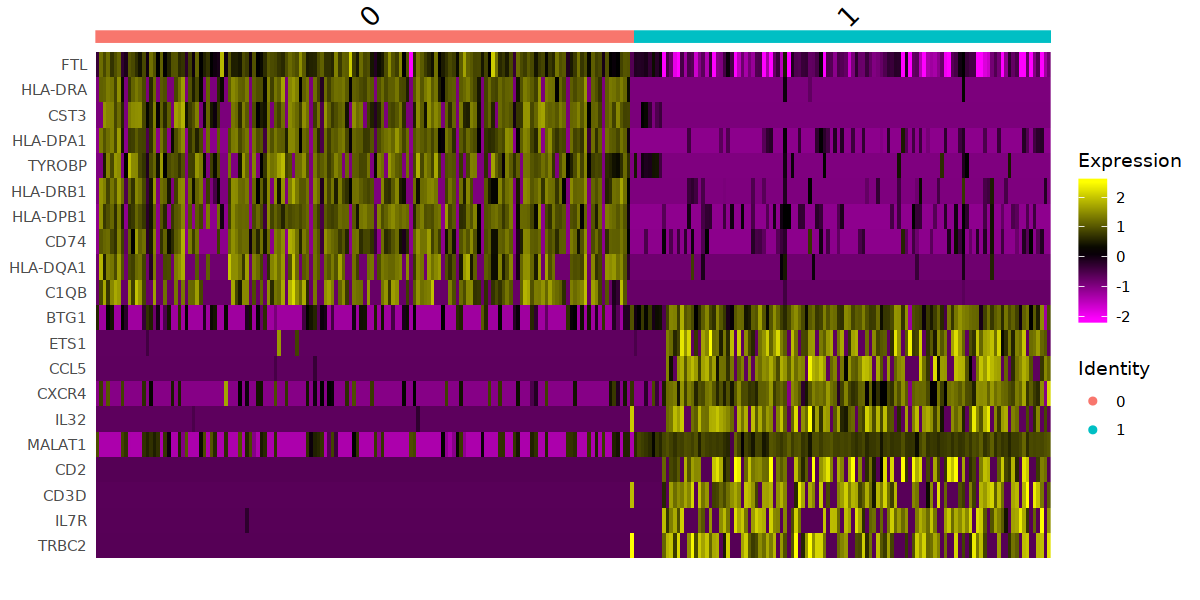

In [84]:
options(repr.plot.width=10, repr.plot.height=5, cex=10)
DoHeatmap(ntumor_obj, features = ntumor_top_per_cluster$gene)

In [85]:
# Tabulation of how many cells per cluster are there
table(ntumor_obj@meta.data$seurat_clusters)


  0   1 
151 117 

## Analysis of Tumor Cells

In [86]:
# Selecting PTPRC- clusters and creating seurat object
tumor_data = as.matrix(GetAssayData(sobj, slot = "counts")[, WhichCells(sobj, ident = ptprc_pos_clusters,invert=TRUE)])
tumor_obj = CreateSeuratObject(counts = tumor_data, project = var1)
tumor_obj

An object of class Seurat 
18447 features across 1814 samples within 1 assay 
Active assay: RNA (18447 features)

In [87]:
var11 = ncol(tumor_obj)
var11

[1] 1814

In [88]:
tumor_obj = NormalizeData(tumor_obj, normalization.method = "LogNormalize", scale.factor = 10000)

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Transformation introduced infinite values in continuous x-axis"


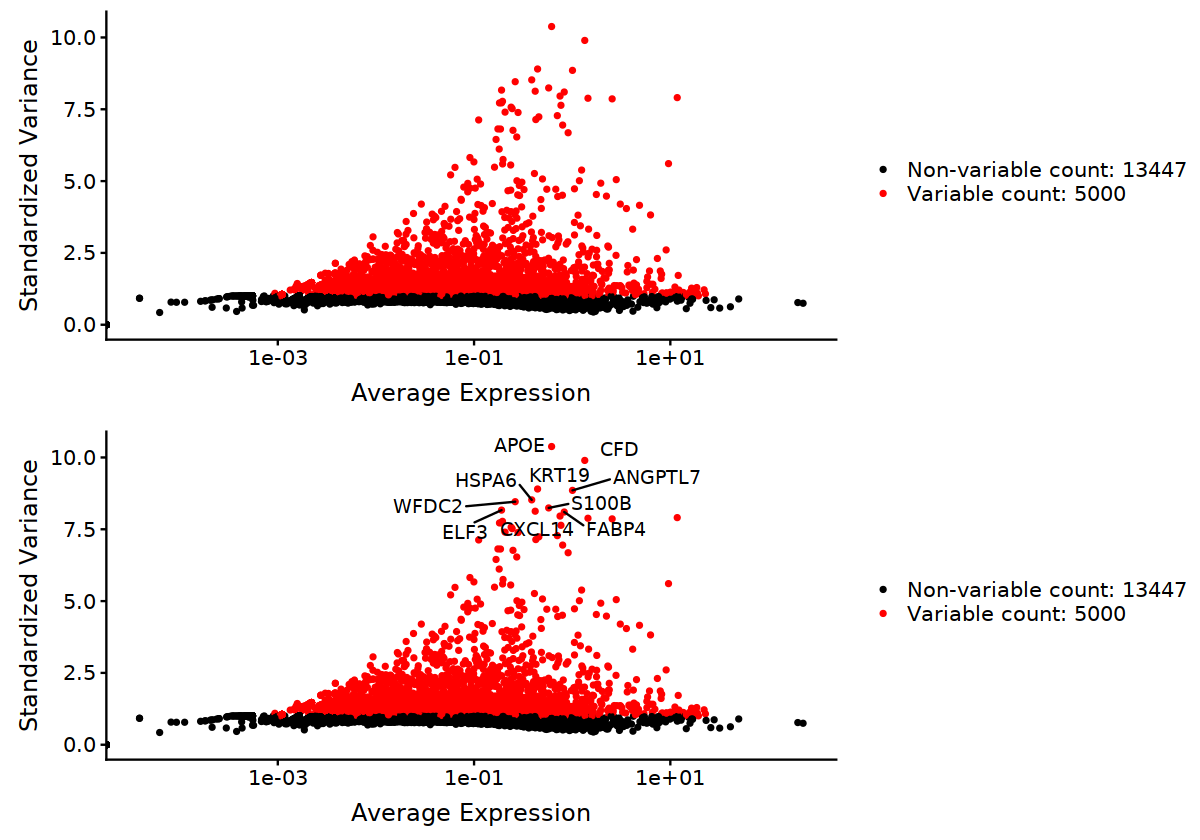

In [89]:
options(repr.plot.width=10, repr.plot.height=7, cex=5)
#Identification of highly variable features (feature selection)
tumor_obj <- FindVariableFeatures(tumor_obj, selection.method = "vst", nfeatures = 5000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(tumor_obj), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(tumor_obj)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE, xnudge=0, ynudge=0)
gridExtra::grid.arrange(plot1,plot2)

In [90]:
#Scaling the data
all.genes <- rownames(tumor_obj)
tumor_obj <- ScaleData(tumor_obj, features = all.genes)

Centering and scaling data matrix



In [91]:
#Perform linear dimensionality reduction with top variable features
tumor_obj <- RunPCA(tumor_obj, features = VariableFeatures(object = tumor_obj))

PC_ 1 
Positive:  CD74, HLA-DRA, EGFL7, CLDN5, SPRY1, HLA-DPA1, AQP1, CAVIN2, VWF, HLA-E 
	   HLA-DPB1, CLEC14A, EMCN, RNASE1, IFI27, SRGN, ADGRL4, FLT1, ACKR1, GNG11 
	   GIMAP7, HYAL2, CD93, ECSCR, LIFR, RAMP2, RAMP3, PLVAP, PCAT19, NOSTRIN 
Negative:  LGALS1, IGFBP6, IGFBP5, DCN, RARRES2, COL6A2, TAGLN, S100A4, TPM2, SOD3 
	   COL1A2, C1S, LUM, CEBPB, COL14A1, LTBP4, CALD1, SSPN, C1R, COL6A1 
	   C2orf40, MYL9, ACTA2, PDGFRB, NR2F1, ABCA8, LRP1, MFGE8, PLAC9, FBLN1 
PC_ 2 
Positive:  ACTA2, MYH11, MYL9, C11orf96, TAGLN, TPM2, PLN, RERGL, RGS5, HES4 
	   RCAN2, NOTCH3, TPM1, LBH, GJA4, DSTN, PPP1R14A, MYLK, LMOD1, GADD45B 
	   CNN1, NDUFA4L2, PHLDA2, MYL6, CSRP2, KLHL23, TSC22D1, MT1A, MAP3K20, PDGFRB 
Negative:  CDH19, SCN7A, ABCA8, PLP1, S100B, NRXN1, LUM, SEMA3B, DCN, ANGPTL7 
	   MPZ, APOD, ITGB8, CHL1, GPM6B, LTBP4, CLU, FN1, MARCKS, GAS7 
	   ANK3, NRP2, ERBB3, ALDH1A1, NCAM1, MATN2, MIA, TTYH1, PTGDS, ADD3 
PC_ 3 
Positive:  DCN, LUM, APOD, IGFBP6, IGFBP7, FBLN1, PTGDS, SERPIN

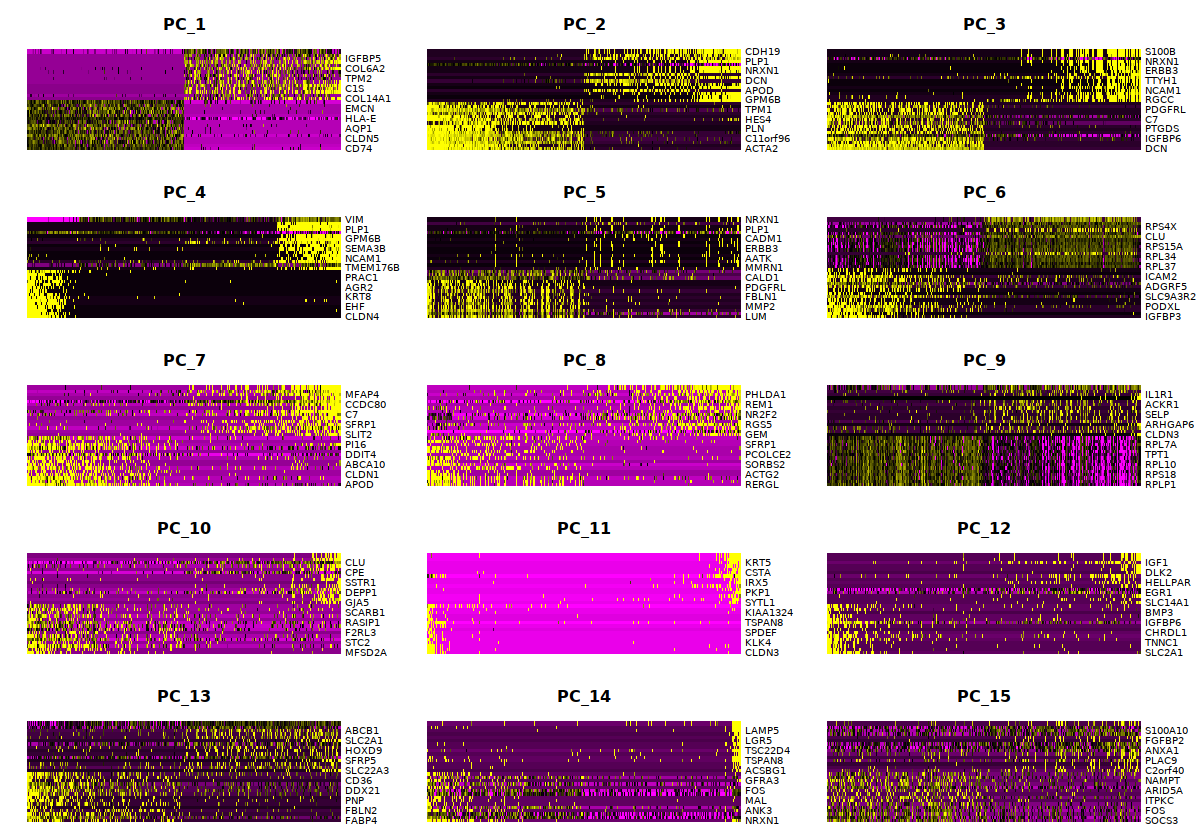

In [92]:
DimHeatmap(tumor_obj, dims = 1:15, cells = 500, balanced = TRUE)

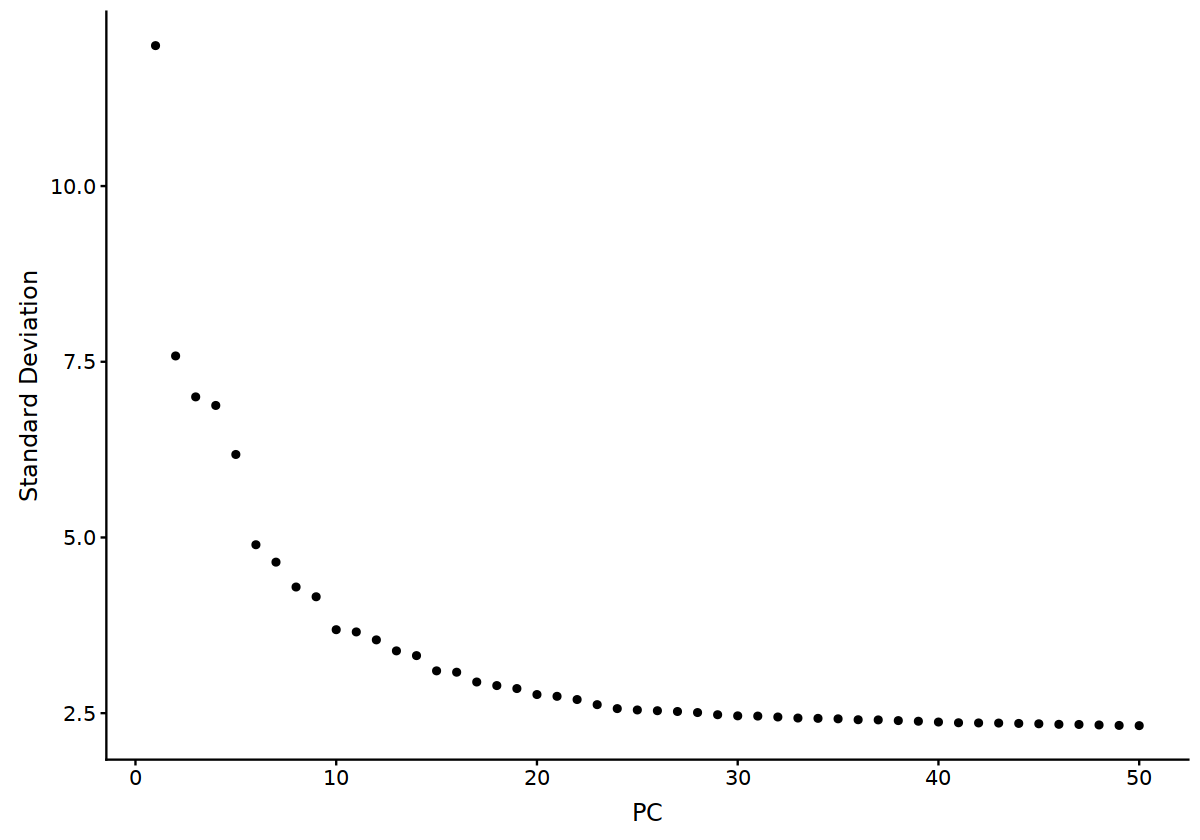

In [93]:
ElbowPlot(tumor_obj, ndims = 50, reduction = "pca")

In [94]:
# Cluster the cells
tumor_obj <- FindNeighbors(tumor_obj, dims = 1:25)
tumor_obj <- FindClusters(tumor_obj, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1814
Number of edges: 57368

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8811
Number of communities: 9
Elapsed time: 0 seconds


In [95]:
tumor_obj <- RunUMAP(tumor_obj, dims = 1:25)
tumor_obj <- RunTSNE(tumor_obj, dims = 1:25)

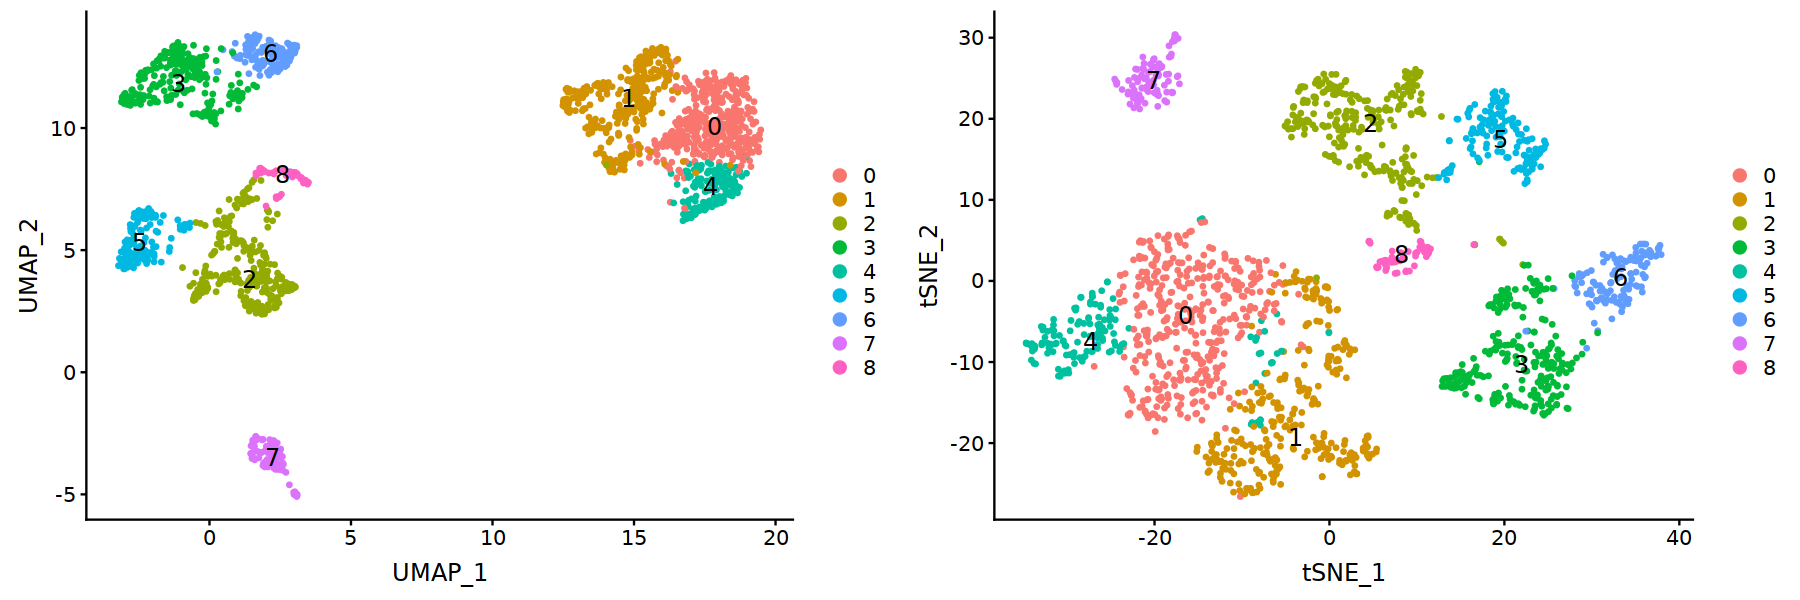

In [96]:
options(repr.plot.width=15, repr.plot.height=5, cex=5)
plot1 <- DimPlot(tumor_obj, reduction = "umap", label=TRUE, label.size=5)
plot2 <- DimPlot(tumor_obj, reduction = "tsne", label=TRUE, label.size=5)
gridExtra::grid.arrange(plot1, plot2, nrow=1)

In [97]:
tumor.markers <- FindAllMarkers(tumor_obj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



In [98]:
tumor_top_per_cluster=Reduce(rbind,by(tumor.markers, tumor.markers["cluster"], head, n=10))

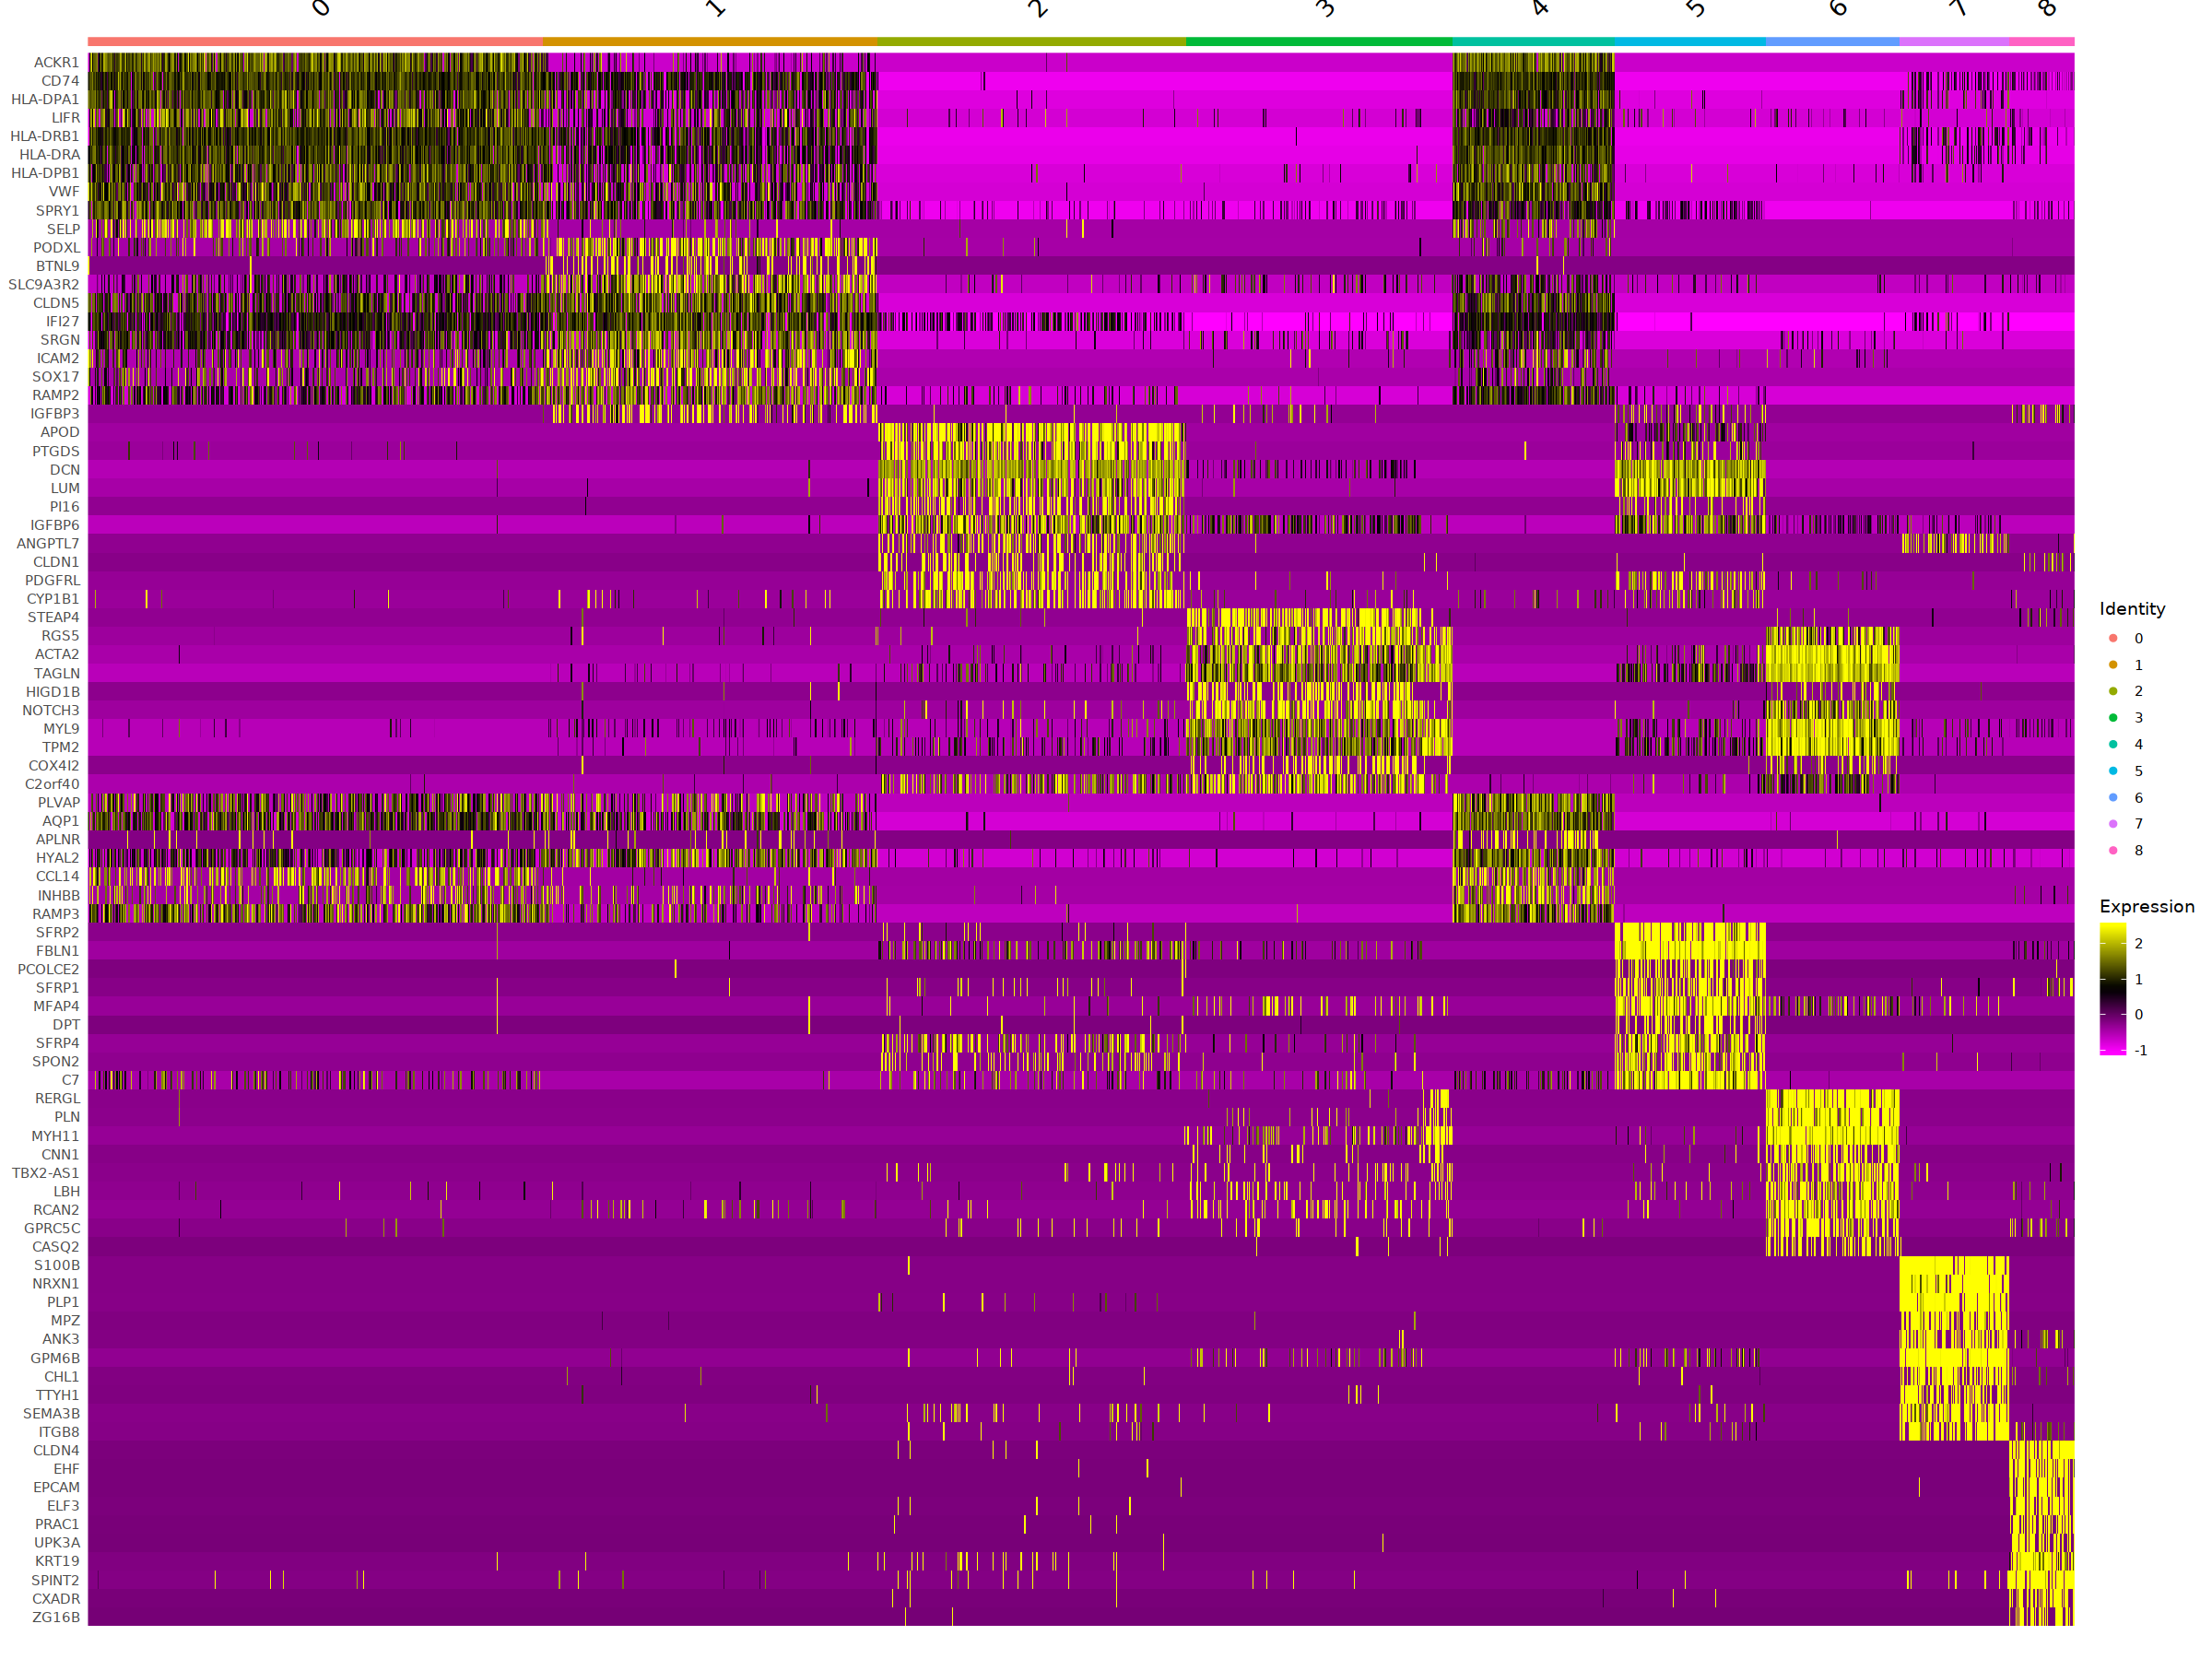

In [99]:
options(repr.plot.width=20, repr.plot.height=15, cex=10)
DoHeatmap(tumor_obj, features = tumor_top_per_cluster$gene)

In [100]:
# Number and Names of mitochondrial genes which get selected in top 5000 most variable genes. 
# The number is insignificant as can be seen below, which is good
tumor_var_features = tumor_obj@assays$RNA@var.features
tumor_var_features[grep("^MT", tumor_var_features)]

[1] "MT1A"     "MT1M"     "MT1X"     "MT3"      "MT2A"     "MT1E"    
 [7] "MT1L"     "MT1G"     "MTHFD2"   "MTCO1P12" "MT-ND6"   "MTMR11"  
[13] "MT1JP"    "MTUS1"    "MTMR9"    "MTMR7"    "MT-TN"    "MTSS1"   
[19] "MT-TA"    "MTND6P18" "MTFP1"    "MTRF1L"   "MTHFS"    "MTAP"    
[25] "MTX3"

In [101]:
var6

[1] "MT1A"     "MT1M"     "MT1X"     "MT3"      "MT2A"     "MT1E"    
 [7] "MT1L"     "MT1G"     "MTND5P32" "MTCO1P12" "MTHFD2"   "MT-ND6"  
[13] "MTUS1"    "MT1JP"    "MT-TI"    "MTMR11"   "MTMR7"    "MT-TK"   
[19] "MTMR9"    "MT-TN"    "MTSS1"    "MT-TA"    "MT-ND2"   "MT2P1"   
[25] "MTFR2"    "MTND6P18"

In [102]:
# cell_anatomy_genes = c("KRT14", "DST", "KRT15","RGCC",
#                        "MSMB", "KLK3", "ACPP", "KLK2",
#                        "SCGB3A1", "LCN2", "PIGR", "WFDC2", "FCGBP",
#                        "KRT13", "APOBEC3A", "CSTB", "LYPD3", "SERPINB1",
#                        "CHGA", "GRP", "CALCA", "SCG2", "TPH1",
#                        "APOD", "FBLN1", "PTGDS", "CFD", "DCN",
#                        "TPM2", "ACTA2", "RGS5", "MT1A", "MYH11",
#                        "IFI27", "ACKR1", "SELE", "HMOX1", "CLDN5",
#                        "RGS1", "C1QA", "C1QB", "TYROBP", "C1QC")
# DotPlot(tumor_obj, features=cell_anatomy_genes)+theme(axis.text.x = element_text(angle = 90))

Warning message in FetchData(object = object, vars = features):
"The following requested variables were not found: DUOXA2, GPX2, TRIM31, TMPRSS4, CLCA4, PSCA"
Warning message in FetchData(object = object, vars = features):
"The following requested variables were not found: PSCA, SPINK1, DUOXA2, CEACAM6, CEACAM5, LINC01207"
Warning message in FetchData(object = object, vars = features):
"The following requested variables were not found: CYR61"
Warning message in FetchData(object = object, vars = features):
"The following requested variables were not found: MSMB, CD24, PSCA, FLJ20021"
Warning message in FetchData(object = object, vars = features):
"The following requested variables were not found (10 out of 15 shown): GRP, CALCA, ASCL1, ZACN, MS4A8, DDC, SCG3, SLC35D3, MIR7-3HG, HTR3C"
Warning message in FetchData(object = object, vars = features):
"The following requested variables were not found: ECSCR.1"


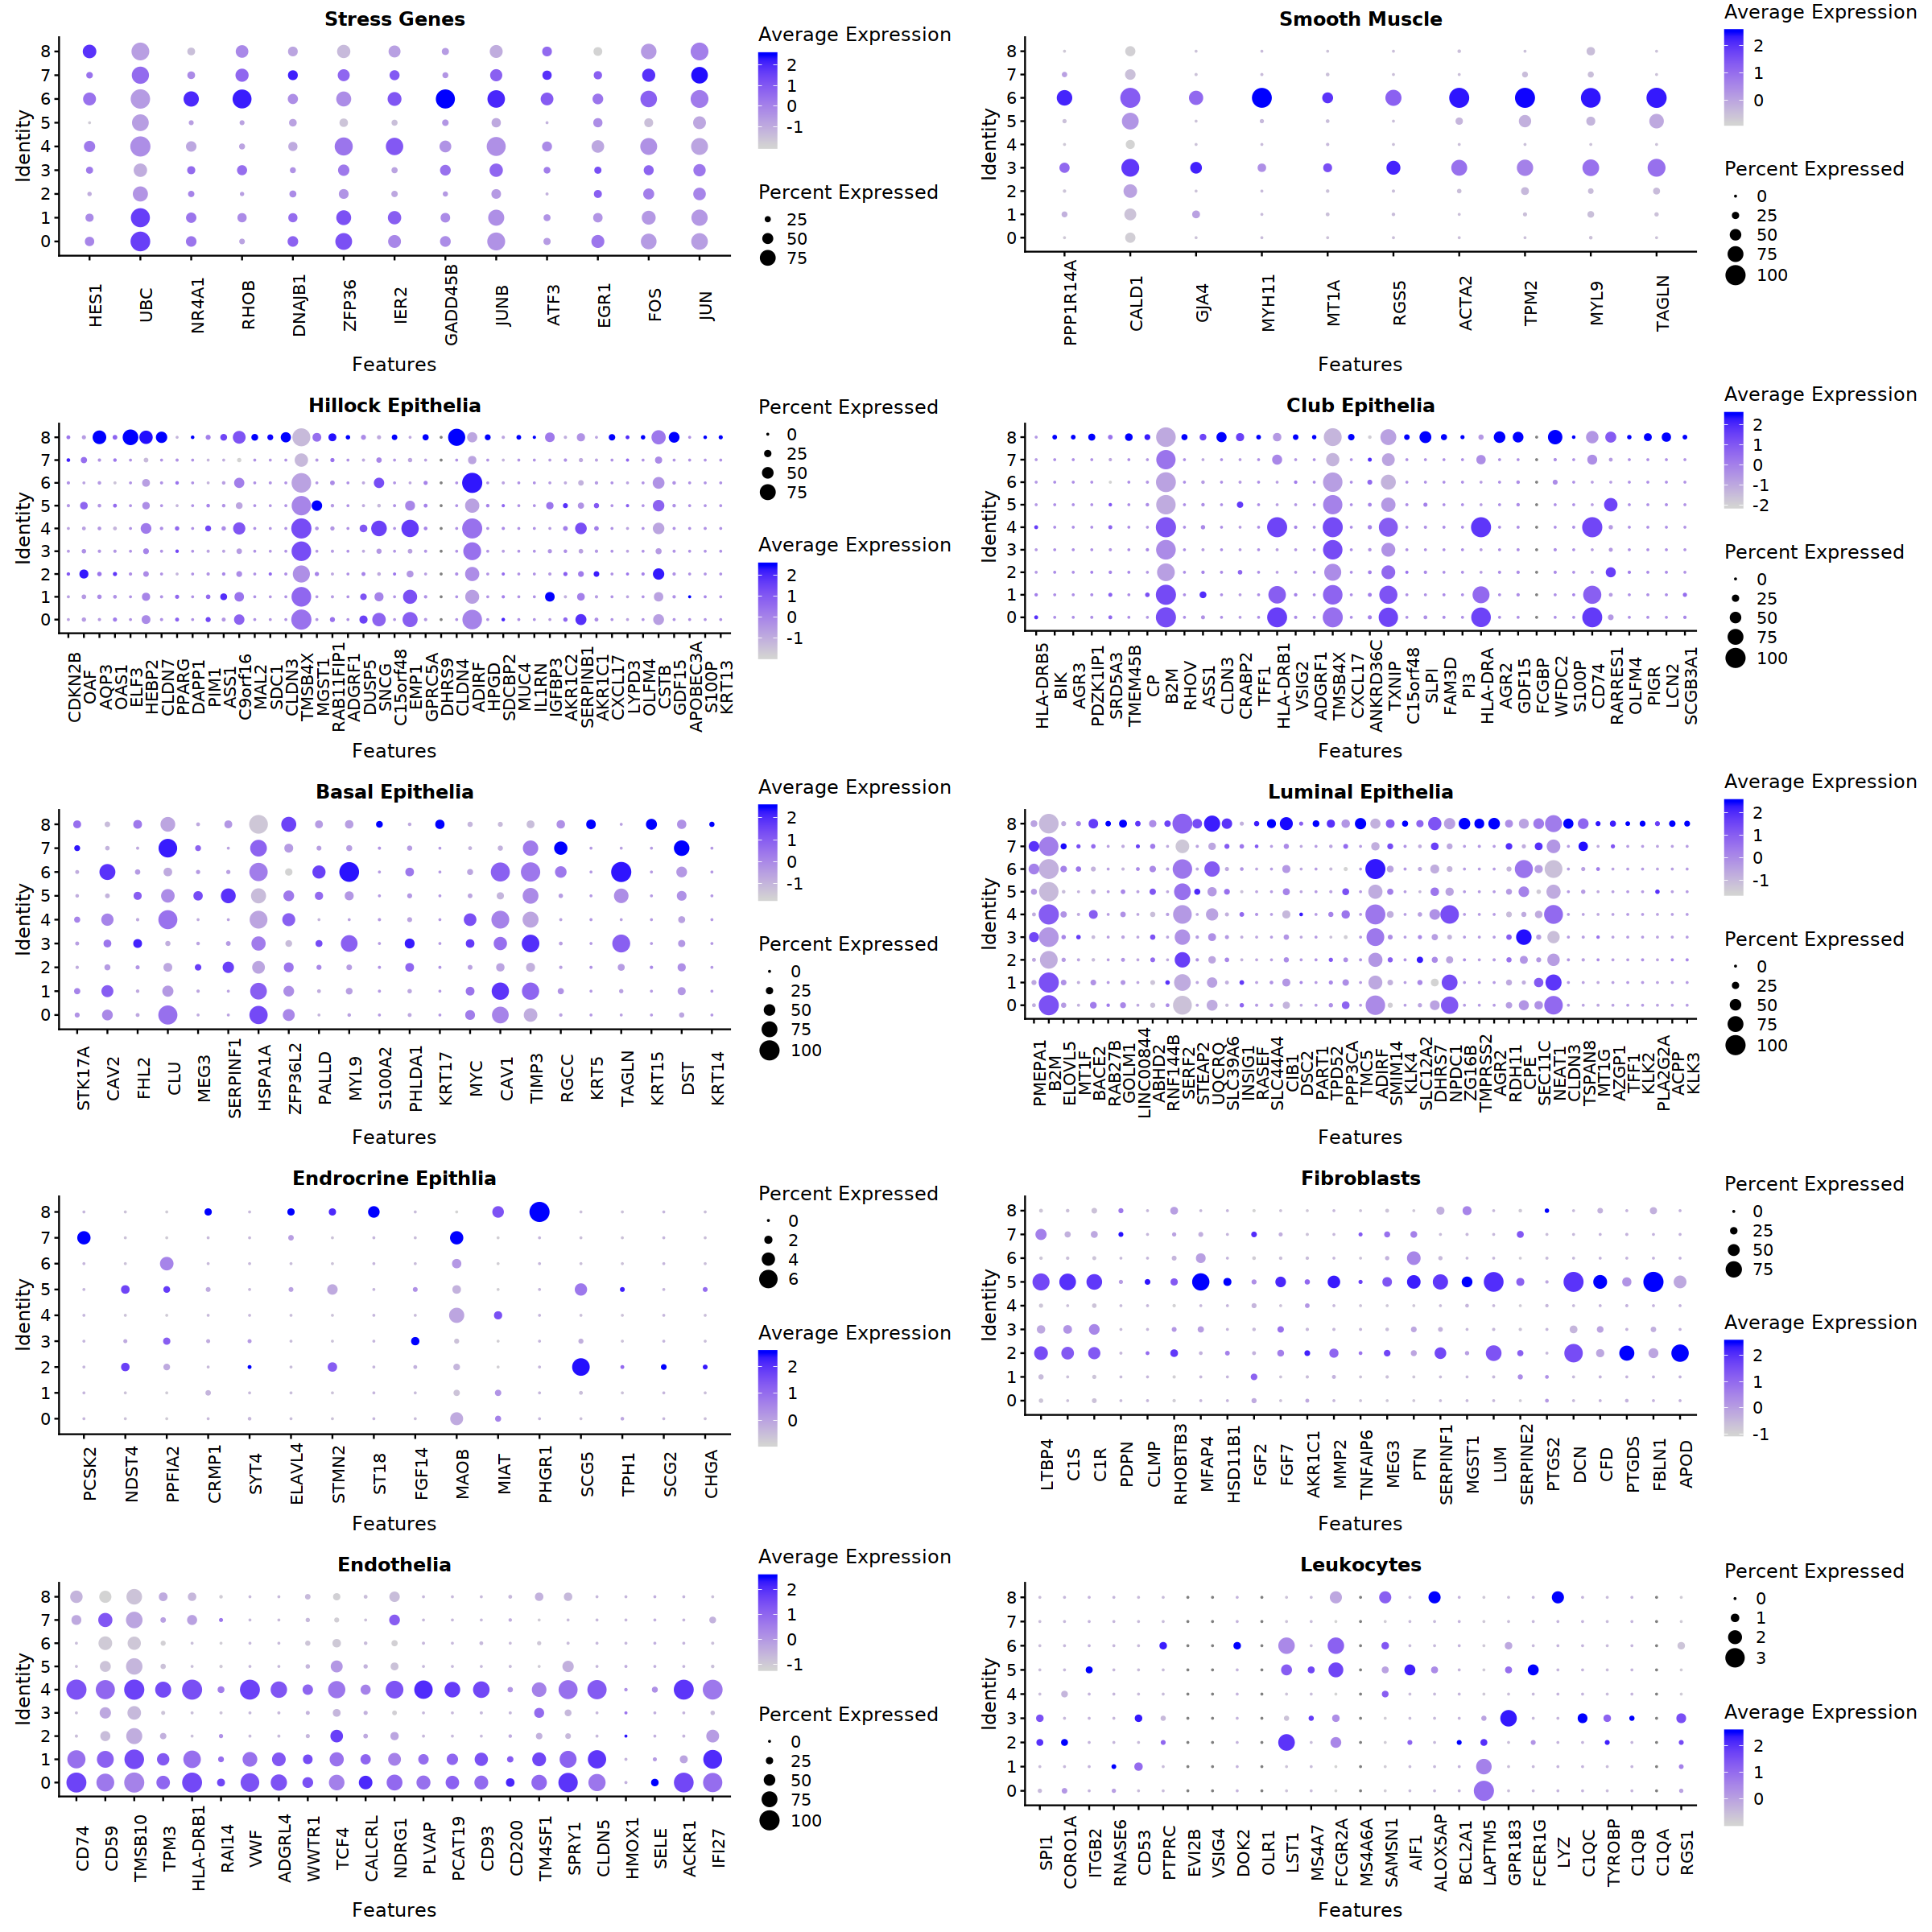

In [103]:
options(repr.plot.width=20, repr.plot.height=20, cex=10)
celltype=read.csv("/home/unix/sjohri/valab_sjohri/projects/ex-vivo/data/henry_et_al.csv")
p1 <- DotPlot(tumor_obj, features=unlist(lapply(list(as.character(celltype$X...stress)), function(x) x[!x %in% ""])))+theme(axis.text.x = element_text(angle = 90))+ggtitle("Stress Genes")
p2 <- DotPlot(tumor_obj, features=unlist(lapply(list(as.character(celltype$smooth_muscle)), function(x) x[!x %in% ""])))+theme(axis.text.x = element_text(angle = 90))+ggtitle("Smooth Muscle")
p3 <- DotPlot(tumor_obj, features=unlist(lapply(list(as.character(celltype$hillock_epithelia)), function(x) x[!x %in% ""])))+theme(axis.text.x = element_text(angle = 90))+ggtitle("Hillock Epithelia")
p4 <- DotPlot(tumor_obj, features=unlist(lapply(list(as.character(celltype$club_epithelia)), function(x) x[!x %in% ""])))+theme(axis.text.x = element_text(angle = 90))+ggtitle("Club Epithelia")
p5 <- DotPlot(tumor_obj, features=unlist(lapply(list(as.character(celltype$basal_epithelia)), function(x) x[!x %in% ""])))+theme(axis.text.x = element_text(angle = 90))+ggtitle("Basal Epithelia")
p6 <- DotPlot(tumor_obj, features=unlist(lapply(list(as.character(celltype$luminal_epithelia)), function(x) x[!x %in% ""])))+theme(axis.text.x = element_text(angle = 90))+ggtitle("Luminal Epithelia")
p7 <- DotPlot(tumor_obj, features=unlist(lapply(list(as.character(celltype$neuroendocrine_epithelia)), function(x) x[!x %in% ""])))+theme(axis.text.x = element_text(angle = 90))+ggtitle("Endrocrine Epithlia")
p8 <- DotPlot(tumor_obj, features=unlist(lapply(list(as.character(celltype$fibroblasts)), function(x) x[!x %in% ""])))+theme(axis.text.x = element_text(angle = 90))+ggtitle("Fibroblasts")
p9 <- DotPlot(tumor_obj, features=unlist(lapply(list(as.character(celltype$endothelia)), function(x) x[!x %in% ""])))+theme(axis.text.x = element_text(angle = 90))+ggtitle("Endothelia")
p10 <- DotPlot(tumor_obj, features=unlist(lapply(list(as.character(celltype$leukocytes)), function(x) x[!x %in% ""])))+theme(axis.text.x = element_text(angle = 90))+ggtitle("Leukocytes")
gridExtra::grid.arrange(p1,p2,p3,p4,p5,p6,p7,p8,p9,p10, nrow=5)

In [104]:
table(tumor_obj@meta.data$seurat_clusters)


  0   1   2   3   4   5   6   7   8 
415 306 282 243 148 138 122 100  60 

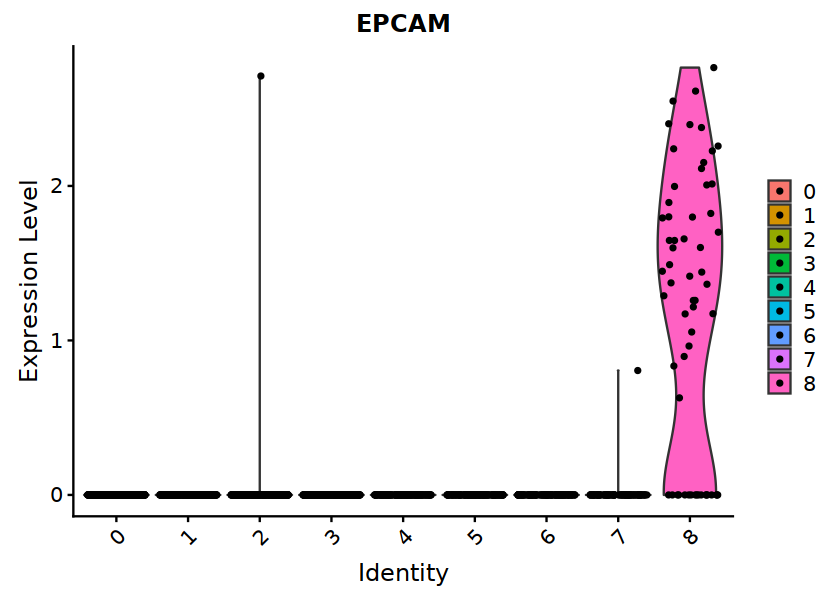

In [105]:
options(repr.plot.width=7, repr.plot.height=5, cex=10)
VlnPlot(tumor_obj, features="EPCAM")

In [106]:
# labelling cell types in non-immune compartment. would later use this classification to run inferCNV
tumor_obj[["cell_type"]] <- NA
tumor_obj$cell_type[WhichCells(object = tumor_obj, ident = c(2,5))] <- "fibroblast"
tumor_obj$cell_type[WhichCells(object = tumor_obj, ident = c(3,6))] <- "smooth_muscle"
# tumor_obj$cell_type[WhichCells(object = tumor_obj, ident = c())] <- "leukocyte"
tumor_obj$cell_type[WhichCells(object = tumor_obj, ident = c(0,1,4))] <- "endothelia"
tumor_obj$cell_type[WhichCells(object = tumor_obj, ident = 8)] <- "epithelia"
tumor_obj$cell_type[WhichCells(object = tumor_obj, ident = 7)] <- "unknown"

In [107]:
# immune_tumor_cells = WhichCells(tumor_obj, idents=c())

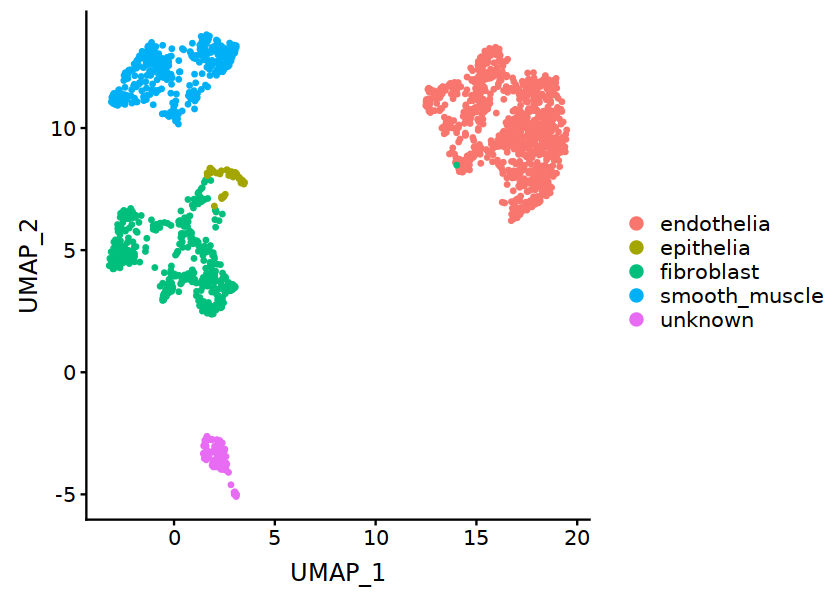

In [108]:
DimPlot(tumor_obj, group.by="cell_type")

## Marker Analysis

In [124]:
write.csv(top_per_cluster,
          paste(paste(paste(paste("./analysis_results_3/",var1, sep=""),"_3/",sep=""),var1,sep=""),
                "_top10_sobj_markers_3.csv", sep=""))
write.csv(tumor_top_per_cluster,
          paste(paste(paste(paste("./analysis_results_3/",var1, sep=""),"_3/",sep=""),var1,sep=""),
                "_top10_tumor_markers_3.csv", sep=""))
write.csv(ntumor_top_per_cluster,
          paste(paste(paste(paste("./analysis_results_3/",var1, sep=""),"_3/",sep=""),var1,sep=""),
                "_top10_ntumor_markers_3.csv", sep=""))
write.csv(tumor.markers,
          paste(paste(paste(paste("./analysis_results_3/",var1, sep=""),"_3/",sep=""),var1,sep=""),
                "_all_tumor_markers_3.csv", sep=""))
write.csv(ntumor.markers,
          paste(paste(paste(paste("./analysis_results_3/",var1, sep=""),"_3/",sep=""),var1,sep=""),
                "_all_ntumor_markers_3.csv", sep=""))

In [125]:
cancer_genes_repo = read.csv("/home/unix/sjohri/valab_sjohri/projects/ex-vivo/data/cancer_genes.csv")
dim(cancer_genes_repo)

[1] 13922    87

In [126]:
ntumor_pat_matched_genes = cancer_genes_repo[cancer_genes_repo$symb %in% ntumor_top_per_cluster$gene,]
tumor_pat_matched_genes = cancer_genes_repo[cancer_genes_repo$symb %in% tumor_top_per_cluster$gene,]
dim(ntumor_pat_matched_genes)
dim(tumor_pat_matched_genes)

[1] 19 87

[1] 80 87

In [127]:
length(ntumor_top_per_cluster$gene)
length(tumor_top_per_cluster$gene)

[1] 20

[1] 90

In [128]:
write.csv(ntumor_pat_matched_genes, 
          paste(paste(paste(paste("./analysis_results_3/",var1, sep=""),"_3/",sep=""),var1,sep=""),
                "_ntumor_pat_gene_annots_3.csv", sep=""), 
          row.names = F)
write.csv(tumor_pat_matched_genes, 
          paste(paste(paste(paste("./analysis_results_3/",var1, sep=""),"_3/",sep=""),var1,sep=""),
                "_tumor_pat_gene_annots_3.csv", sep=""),
          row.names = F)

## Cell Cycle Analysis

In [130]:
# S-phase and G2M phase genes
s_genes <- cc.genes$s.genes
g2m_genes <- cc.genes$g2m.genes

In [132]:
sobj <- CellCycleScoring(sobj, s.features = s_genes, g2m.features = g2m_genes, set.ident = FALSE)
tumor_obj <- CellCycleScoring(tumor_obj, s.features = s_genes, g2m.features = g2m_genes, set.ident = FALSE)
ntumor_obj <- CellCycleScoring(ntumor_obj, s.features = s_genes, g2m.features = g2m_genes, set.ident = FALSE)

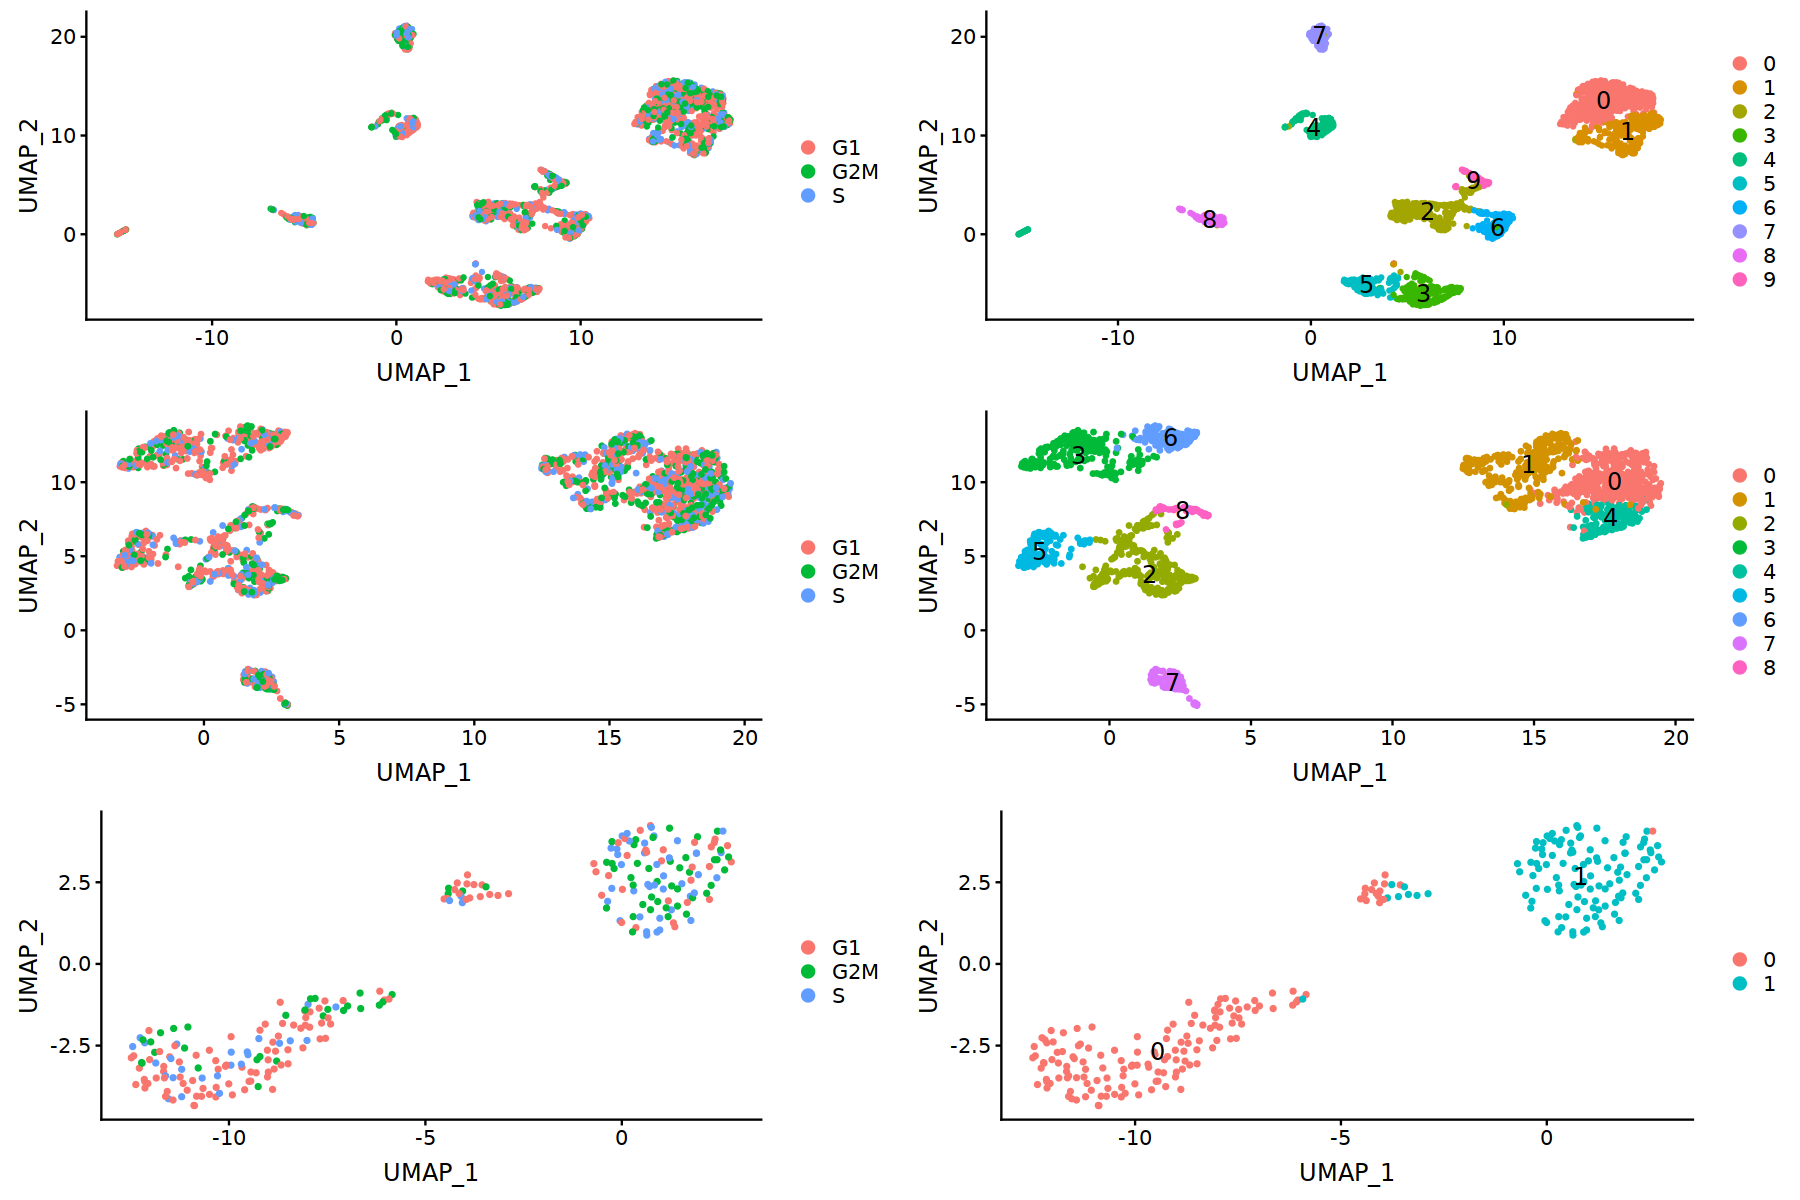

In [133]:
options(repr.plot.width=15, repr.plot.height=10, cex=10)
p1 <- DimPlot(sobj, reduction="umap", group.by="Phase")
p2 <- DimPlot(sobj, reduction = "umap", label=TRUE, label.size=5)
p3 <- DimPlot(tumor_obj, reduction="umap", group.by="Phase")
p4 <- DimPlot(tumor_obj, reduction = "umap", label=TRUE, label.size=5)
p5 <- DimPlot(ntumor_obj, reduction="umap", group.by="Phase")
p6 <- DimPlot(ntumor_obj, reduction = "umap", label=TRUE, label.size=5)
gridExtra::grid.arrange(p1,p2,p3,p4,p5,p6, nrow=3)

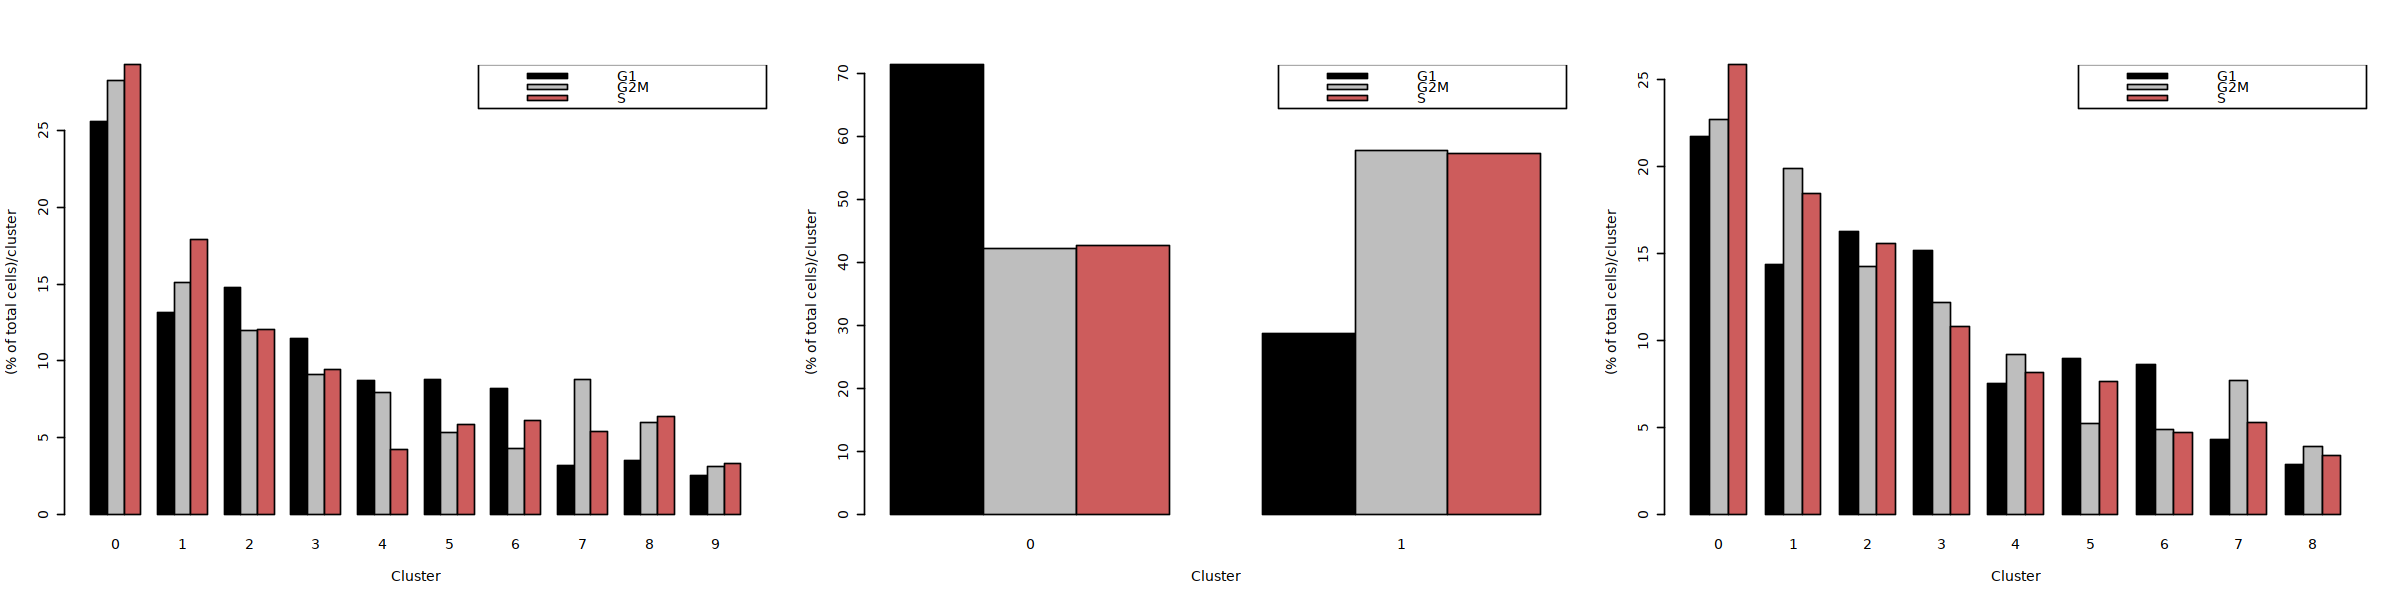

In [134]:
options(repr.plot.width=20, repr.plot.height=5, cex=10)

par(mfrow = c(1, 3))
#Barplot for sobj
cc_counts = table(sobj@meta.data$Phase,sobj@meta.data$seurat_clusters)

cc_counts[1,] = 100*cc_counts[1,]/sum(cc_counts[1,])
cc_counts[2,] = 100*cc_counts[2,]/sum(cc_counts[2,])
cc_counts[3,] = 100*cc_counts[3,]/sum(cc_counts[3,])

barplot(cc_counts,beside=T,col=c("black","gray","indianred"), ylab="(% of total cells)/cluster",xlab="Cluster")
legend("topright",c("G1","G2M","S"),fill=c("black", "gray", "indianred"))

#Barplot for ntumor
ntumor_cc_counts = table(ntumor_obj@meta.data$Phase,ntumor_obj@meta.data$seurat_clusters)

ntumor_cc_counts[1,] = 100*ntumor_cc_counts[1,]/sum(ntumor_cc_counts[1,])
ntumor_cc_counts[2,] = 100*ntumor_cc_counts[2,]/sum(ntumor_cc_counts[2,])
ntumor_cc_counts[3,] = 100*ntumor_cc_counts[3,]/sum(ntumor_cc_counts[3,])

barplot(ntumor_cc_counts,beside=T,col=c("black","gray","indianred"), ylab="(% of total cells)/cluster",xlab="Cluster")
legend("topright",c("G1","G2M","S"),fill=c("black", "gray", "indianred"))

#Barplot for tumor
tumor_cc_counts = table(tumor_obj@meta.data$Phase,tumor_obj@meta.data$seurat_clusters)

tumor_cc_counts[1,] = 100*tumor_cc_counts[1,]/sum(tumor_cc_counts[1,])
tumor_cc_counts[2,] = 100*tumor_cc_counts[2,]/sum(tumor_cc_counts[2,])
tumor_cc_counts[3,] = 100*tumor_cc_counts[3,]/sum(tumor_cc_counts[3,])

barplot(tumor_cc_counts,beside=T,col=c("black","gray","indianred"), ylab="(% of total cells)/cluster",xlab="Cluster")
legend("topright",c("G1","G2M","S"),fill=c("black", "gray", "indianred"))

par(mfrow = c(1, 1))

## More QC Checks

In [135]:
genes.dissoc <- c("ATF3", "BTG2", "CEBPB", "CEBPD", "CXCL3", "CXCL2", "CXCL1", "DNAJA1", "DNAJB1", 
                  "DUSP1", "EGR1", "FOS", "FOSB", "HSP90AA1", "HSP90AB1", "HSPA1A", "HSPA1B", "HSPA1A",
                  "HSPA1B", "HSPA8", "HSPB1", "HSPE1", "HSPH1", "ID3", "IER2", "JUN", "JUNB", "JUND",
                  "MT1X", "NFKBIA", "NR4A1", "PPP1R15A", "SOCS3", "ZFP36")
sobj <- AddModuleScore(sobj, features = list(genes.dissoc), ctrl = 20, name = "genes_dissoc")
tumor_obj <- AddModuleScore(tumor_obj, features = list(genes.dissoc), ctrl = 20, name = "genes_dissoc")
ntumor_obj <- AddModuleScore(ntumor_obj, features = list(genes.dissoc), ctrl = 20, name = "genes_dissoc")

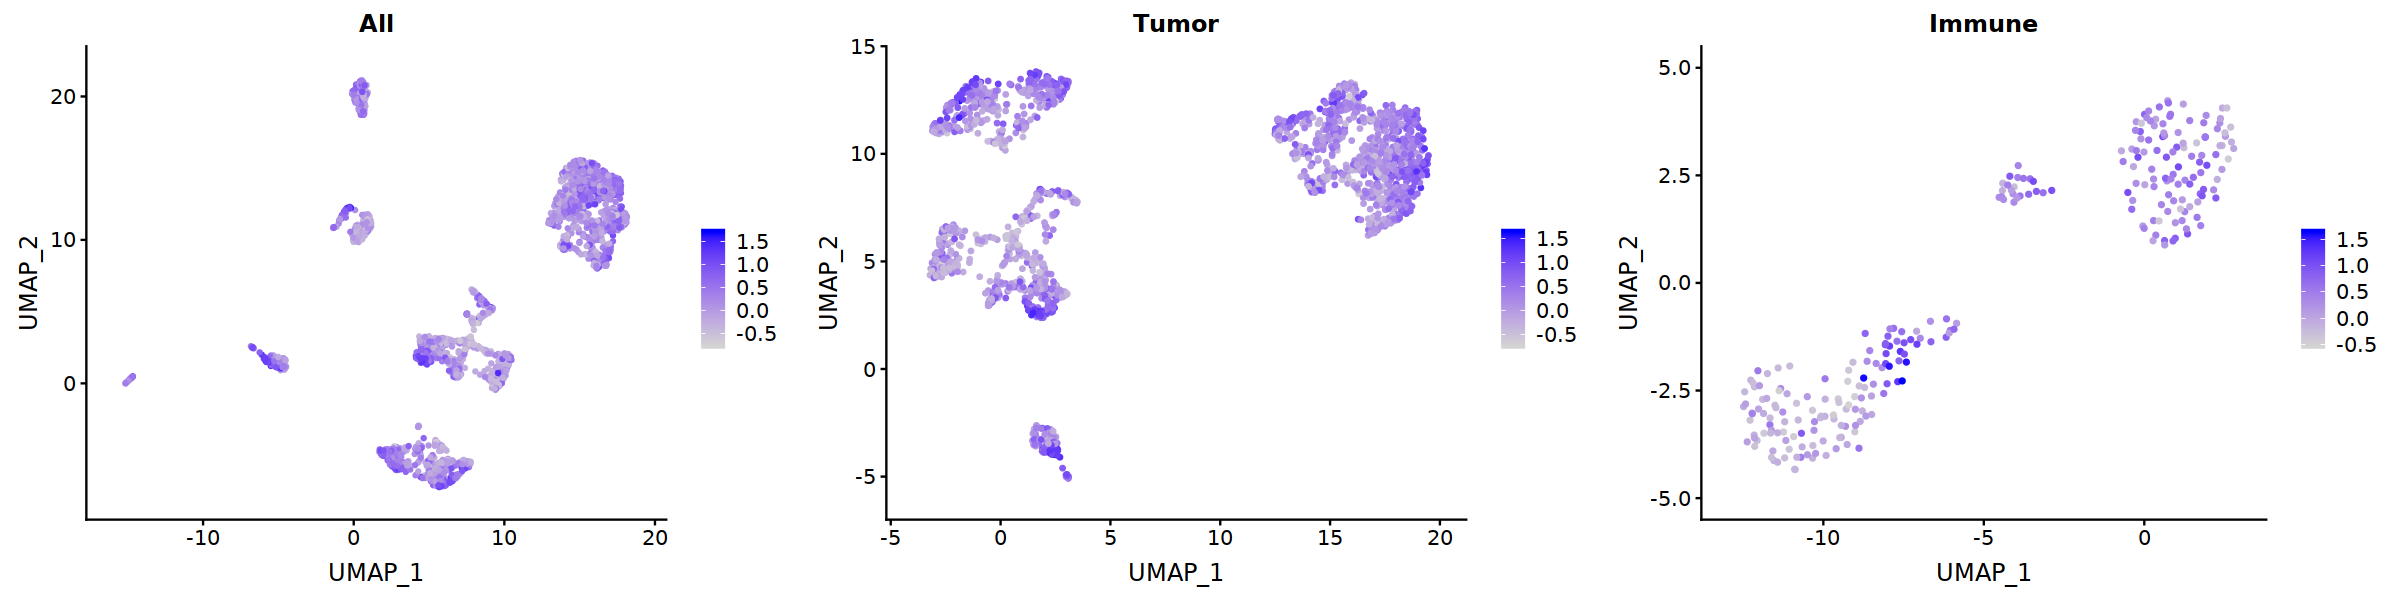

In [136]:
options(repr.plot.width=20, repr.plot.height=5, cex=10)
p1 <- FeaturePlot(sobj, reduction="umap", features="genes_dissoc1") + labs(title = "All")
p2 <- FeaturePlot(tumor_obj, reduction="umap", features="genes_dissoc1") + labs(title = "Tumor")
p3 <- FeaturePlot(ntumor_obj, reduction="umap", features="genes_dissoc1") + labs(title = "Immune")
gridExtra::grid.arrange(p1,p2,p3, nrow=1)

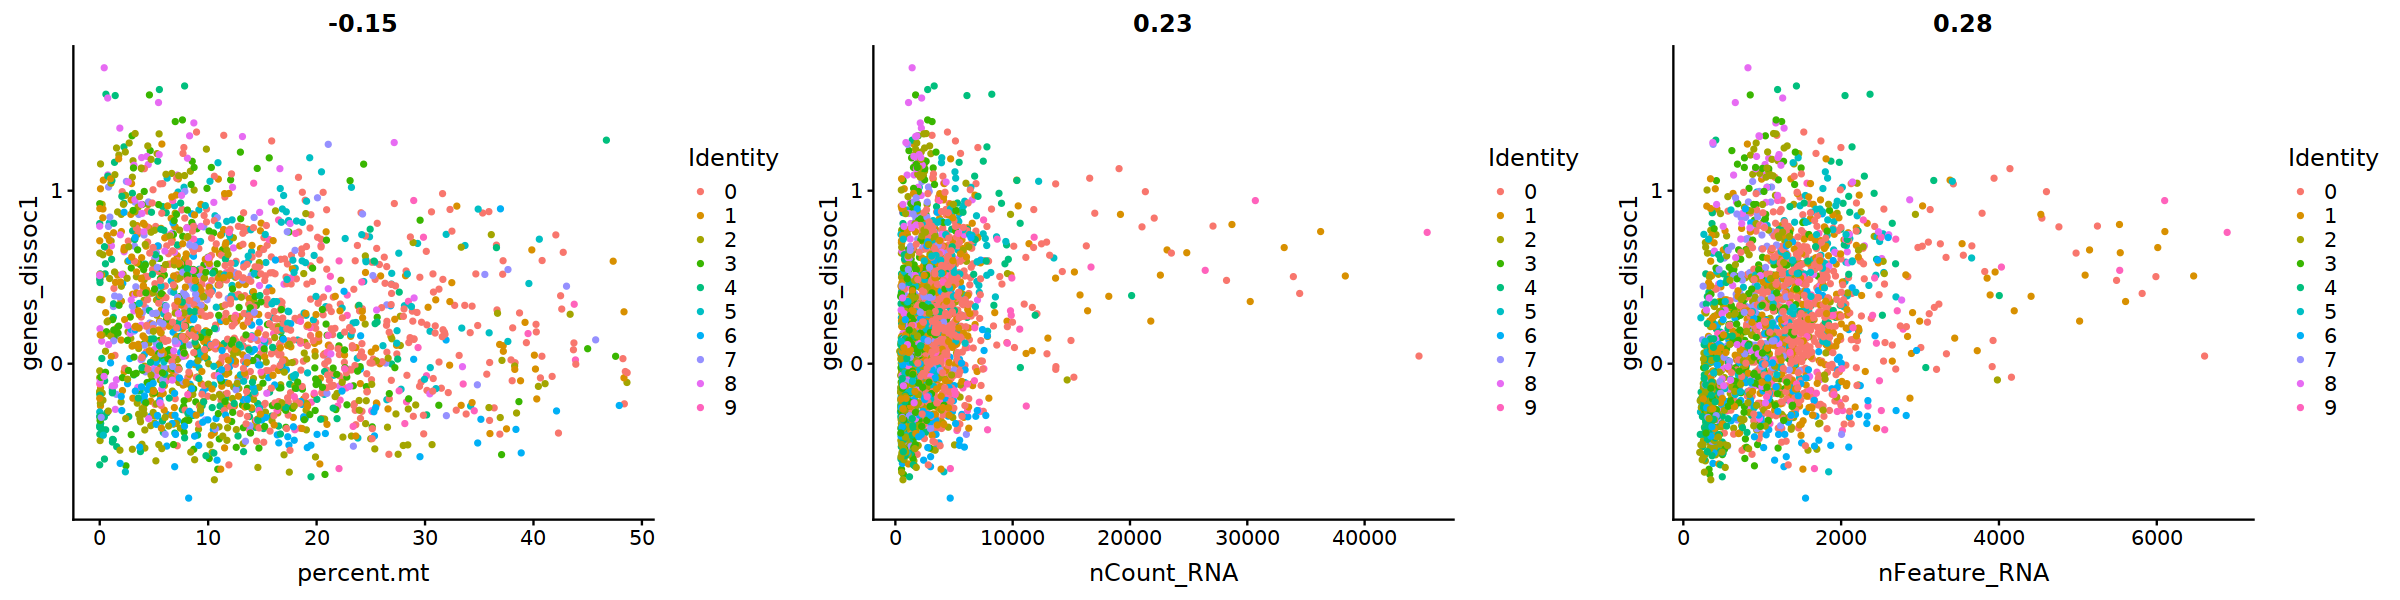

In [137]:
options(repr.plot.width=20, repr.plot.height=5, cex=10)
p1 <- FeatureScatter(sobj, feature1 = "percent.mt", feature2 = "genes_dissoc1")
p2 <- FeatureScatter(sobj, feature1 = "nCount_RNA", feature2 = "genes_dissoc1")
p3 <- FeatureScatter(sobj, feature1 = "nFeature_RNA", feature2 = "genes_dissoc1")
gridExtra::grid.arrange(p1,p2,p3, nrow=1)

## InferCNV Part 2

For differentiating between tumor and stromal cells. Code and Vignette: https://github.com/broadinstitute/infercnv. Needs to be done on Terra because very memory intensive and interactive jobs crash.

In [138]:
#InferCNV metadata files for PC

df = subset(tumor_obj@meta.data, select="seurat_clusters")

# Change the format of Cluster column
df$seurat_clusters= paste0("Cluster",df$seurat_clusters)

# Shift the index to a row of dataframe
df <- cbind(newColName = rownames(df), df)
rownames(df) <- 1:nrow(df)

# Reset the name of Cluster column
colnames(df) = c("NAME TYPE","Sample group")

write.table(df,
            file= paste(paste(paste(paste("./analysis_results_3/",var1, sep=""),"_3/",sep=""),var1,sep=""),
                "_tumorobj_infercnv_metadata_pc_3.txt", sep=""),
            sep="\t", row.names = F, quote=F, col.names=F)

In [139]:
#InferCNV counts
write.table(tumor_obj@assays$RNA@counts, 
            paste(paste(paste(paste("./analysis_results_3/",var1, sep=""),"_3/",sep=""),var1,sep=""),
                "_tumorobj_counts_3.txt", sep=""),
            sep="\t", quote=F)

## GeneCards

In [140]:
library(GeneBook)

In [141]:
sobj_gene_func_desc = data.frame(symbol = character(),
                                   type = character(),
                                   description = character(),
                                   uniprot = character(),
                                   entrez = character(),
                                   gene_card = character(),
                                   tocris = character(),
                                   civic = character()
                                  )
for (x in top_per_cluster$gene)
    {
    temp = GeneCard_Symbol_Details(x)
    sobj_gene_func_desc = rbind(sobj_gene_func_desc,temp)
}

In [142]:
ntumor_gene_func_desc = data.frame(symbol = character(),
                                   type = character(),
                                   description = character(),
                                   uniprot = character(),
                                   entrez = character(),
                                   gene_card = character(),
                                   tocris = character(),
                                   civic = character()
                                  )
for (x in ntumor_top_per_cluster$gene)
    {
    temp = GeneCard_Symbol_Details(x)
    ntumor_gene_func_desc = rbind(ntumor_gene_func_desc,temp)
}

In [143]:
tumor_gene_func_desc = data.frame(symbol = character(),
                                   type = character(),
                                   description = character(),
                                   uniprot = character(),
                                   entrez = character(),
                                   gene_card = character(),
                                   tocris = character(),
                                   civic = character()
                                  )
for (x in tumor_top_per_cluster$gene)
    {
    temp = GeneCard_Symbol_Details(x)
    tumor_gene_func_desc = rbind(tumor_gene_func_desc,temp)
}

In [144]:
write.csv(sobj_gene_func_desc,
          paste(paste(paste(paste("./analysis_results_3/",var1, sep=""),"_3/",sep=""),var1,sep=""),
                "_sobj_gene_desc_3.csv", sep=""),
          row.names = F)
write.csv(ntumor_gene_func_desc,
          paste(paste(paste(paste("./analysis_results_3/",var1, sep=""),"_3/",sep=""),var1,sep=""),
                "_ntumor_gene_desc_3.csv", sep=""),
          row.names = F)
write.csv(tumor_gene_func_desc,
          paste(paste(paste(paste("./analysis_results_3/",var1, sep=""),"_3/",sep=""),var1,sep=""),
                "_tumor_gene_desc_3.csv", sep=""),
          row.names = F)

## Appending parameters to csv

Basically appends parameters (like percent.mt, no of PCs, no of cells per compartment etc) to a CSV file. Easier to analyse later

In [145]:
df=read.csv(file = "./analysis_results_3/params_3.txt", sep="\t")
x = c(as.character(Sys.time()),var1,var2,var3,var4,var5,do.call(paste, c(as.list(var6), sep=",")),
      var7,var8,do.call(paste, c(as.list(var9), sep = ",")),var10,var11)

In [146]:
write.table(cbind(df,x), "./analysis_results_3/params_3.txt", sep="\t", quote=F, row.names=F)

## Saving Objects

In [147]:
saveRDS(sobj, file = paste(paste("./robj/", var1, sep=""), "_sobj.rds", sep=""))
saveRDS(tumor_obj, file = paste(paste("./robj/", var1, sep=""), "_tumor_obj.rds", sep=""))
saveRDS(ntumor_obj, file = paste(paste("./robj/", var1, sep=""), "_ntumor_obj.rds", sep=""))

In [ ]:
# # Based on InferCNV results
# tumor_clust = 
# tumor_confirmed_cells = WhichCells(tumor_obj, idents=tumor_clust)
# stromal_confirmed_cells = WhichCells(tumor_obj, idents=tumor_clust, invert = TRUE)
# saveRDS(tumor_obj[,colnames(tumor_obj) %in% tumor_confirmed_cells], file = paste(paste("./robj/", var1, sep=""), "_confirmed_tumor.rds", sep=""))
# saveRDS(tumor_obj[,colnames(tumor_obj) %in% stromal_confirmed_cells], file = paste(paste("./robj/", var1, sep=""), "_confirmed_stromal.rds", sep=""))